# Peer-graded Assignment: Описательный анализ данных

Часто при работе с пользовательскими данными приходится сталкиваться с тем, что данные предоставляются для работы без описания. При этом не известно, что содержательно представляют собой те или иные признаки, а известны лишь их типы: числовые, категориальные, номинальные переменные. Такие ситуации - не редкость при работе с «чувствительными» данными, например, в сфере банковской аналитики, HR-аналитики, сфере телекоммуникаций, страхования, здравоохранения, недвижимости или ритейла. Тем не менее, с такими данным нужно уметь работать, и нужно уметь проводить на них классические этапы анализа, в частности описательный анализ данных и визуализацию. Именно этим мы займемся на первой неделе.


В этом задании мы потренируемся делать описательный анализ и визуализацию так называемых «закрытых» данных - данных, которые предоставляются для анализа и построения моделей без описания. Выборка, с которой мы будем работать прилагается.

* Метки классов (здесь `1` соответствует классу `отток`, `-1` - классу `не отток`) – `orange_small_churn_labels.train`
* Данные (предоставлены без описания, однако известно, что первые 190 переменных являются числовыми, а оставшиеся 40 - категориальными) – `orange_small_churn_data.train`

Скачайте эти файлы [на странице задания](https://www.coursera.org/learn/data-analysis-project/peer/roSOe/opisatiel-nyi-analiz-dannykh) и переходите к выполнению задачи! Результатом выполнения задания является jupyter notebook. Перед отправкой результата убедитесь, что вы выполнили все пункты из задания и это можно понять из вашего notebook'а. Проверьте, что код написан понятно и аккуратно - это поможет вашим сокурсником лучше понять, что вы сделали, и оценить вашу работу.

## Инструкции

1\. Загрузите данные `orange_small_churn_data.train` и `orange_small_churn_labels.train`

In [1]:
import pandas as pd
import random
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
%matplotlib inline

churn_data_frame = pd.read_csv("..\..\Data\orange_small_churn_data.train", ",")
churn_labels_frame = pd.read_csv("..\..\Data\orange_small_churn_labels.train", header=None)
churn_data_frame.shape

(40000, 230)

In [2]:
churn_labels_frame.shape

(40000, 1)

2\. Рассчитайте доли классов `отток` и `не отток`.

In [3]:
def show_proportion_data(frame):
    proportion_plot = frame.plot(
        kind="hist",
        title="Labels proportion",
        figsize=(2,3),
        legend=False)
    proportion_plot.set_xlabel("Label value")
    proportion_plot.set_ylabel("Label frequency")
    not_churn_proportion = float(frame[frame[0] == -1].shape[0])/float(frame.shape[0])
    churn_proportion = float(frame[frame[0] == 1].shape[0])/float(frame.shape[0])
    print ("Доля ответов класса \"отток\": %.4f%%\nДоля ответов класса \"не отток\": %.4f%%\nКласса \"отток\" меньше в %.4f раз" % (churn_proportion, not_churn_proportion, not_churn_proportion/churn_proportion))

Доля ответов класса "отток": 0.0744%
Доля ответов класса "не отток": 0.9256%
Класса "отток" меньше в 12.4409 раз


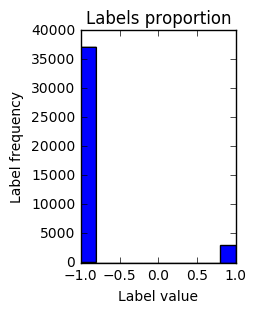

In [4]:
show_proportion_data(churn_labels_frame)

**По долям ответов класса "отток" и "не отток" видно, что выборка сильно перекошена и наблюдений класса "отток" существенно меньше.**
**Повторим данные класса "отток" 11 раз, чтобы сбалансировать выборку**

Доля ответов класса "отток": 0.4910%
Доля ответов класса "не отток": 0.5090%
Класса "отток" меньше в 1.0367 раз


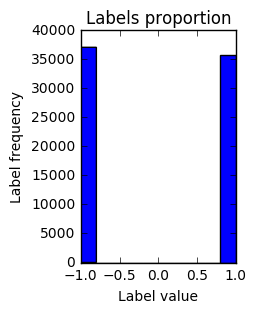

In [5]:
churn_only_labels = churn_labels_frame[churn_labels_frame[0] == 1]
churn_indices = list(churn_only_labels.index)
churn_only_frame = churn_data_frame.loc[churn_indices,:]
churn_balanced_frame = churn_data_frame.copy()
churn_balanced_labels = churn_labels_frame.copy()
for i in range(0, 11):
    churn_balanced_frame = pd.concat([churn_balanced_frame, churn_only_frame], ignore_index=True)
    churn_balanced_labels = pd.concat([churn_balanced_labels, churn_only_labels], ignore_index=True)
show_proportion_data(churn_balanced_labels)

3\. Рассчитайте корреляции переменных с целевой функцией и проанализируйте полученные данные.

Обратите внимание на то, что целевая функция предсталвляет собой бинарную переменную. Теоретически, это не помешает рассчиать, например, корреляцию Пирсона между непрерывной переменной и целевой функцией, онднако анализиоовать полученные результаты будет сложно, корреляция Пирсона просто не рассчитана на такое применение. Кто уже забыл, как действовать в такой ситуации - вспоминить можно вот здесь: https://www.coursera.org/teach/stats-for-data-analysis/content/edit/lecture/prX3S/video-subtitles

**Поскольку признаки и целевая функция имеют разные типы (численный или категориальный для признаков и бинарный для ответов). Поэтому корреляции Пирсона и Спирмена применять нельзя. Можно посчитать меру силы взаимосвязи по формуле**
$$E(X1 |X2 = 1)−E(X1 |X2 = -1)$$
**Матожидание в выборке приблизим средним, тогда получим**
$$\frac{\sum_{i=1}^n{{(x_{i}|y_{i}=1)}}}{k} - \frac{\sum_{i=1}^n{{(x_{i}|y_{i}=-1)}}}{\ell}$$
где $k$ - количество наблюдений с $y=1$, а $\ell$ - количество наблюдений с $y=-1$

**Можно взять от полученных значений модуль, т.к. большое отрицательное значение будет характеризовать обратную взаимосвязь и отсортировать значения по убыванию**

In [6]:
def split_frame(frame, n_columns, c_columns):
    n_frame = frame[n_columns].copy()
    c_frame = frame[c_columns].copy()
    # Посчитаем средние по колонкам
    numeric_means = n_frame.mean(axis=0, skipna=True)
    # Оставим только те колонки, в которых среднее значение не равно NaN, т.к. в таких колонках совсем нет значений
    numeric_means = numeric_means.dropna()
    n_frame = n_frame[list(numeric_means.index)]
    # Заполним пропущенные численные значения средними
    n_frame = n_frame.fillna(numeric_means, axis=0)
    # Заполним пропущенные категориальные значения строками "NaV" (Not a value)
    c_frame = c_frame.fillna("NaV")
    return (n_frame, c_frame)

def calculate_interrelations(frame, labels, first_class, second_class):
    # Выделим индексы отток/не отток
    first_indices = list(labels[labels[0] == first_class].index)
    second_indices = list(labels[labels[0] == second_class].index)
    # Средние значения в матрице значений "отток" по колонкам
    first_class_means = frame.loc[first_indices,:].mean(axis=0)
    # Средние значения в матрице значений "не отток" по колонкам
    second_class_means = frame.loc[second_indices,:].mean(axis=0)
    # Меры взаимосвязи
    interrelations = (first_class_means-second_class_means).abs().sort_values(ascending=False)
    return (interrelations,first_indices,second_indices)

In [7]:
# Выделим отдельно числовые и категориальные колонки.
numeric_columns = churn_balanced_frame.columns[:190]
categorial_columns = churn_balanced_frame.columns[190:]

numeric_frame, categorial_frame = split_frame(churn_data_frame, numeric_columns, categorial_columns)
numeric_balanced_frame, categorial_balanced_frame = split_frame(churn_balanced_frame, numeric_columns, categorial_columns)

# Меры взаимосвязи
balanced_interrelations, churn_balanced_indices, not_churn_balanced_indices = calculate_interrelations(
    numeric_balanced_frame,
    churn_balanced_labels,
    1,
    -1)
interrelations, churn_indices, not_churn_indices = calculate_interrelations(
    numeric_frame,
    churn_labels_frame,
    1,
    -1)

4\. Визуализируйте данные: рассмотрите топ 20 числовых переменных, наиболее сильно коррелирующих с целевой функцией. Для этих переменных постройте:
* Распределения в разрезе классов
* Отобразите объекты в координатах пар признаков

In [8]:
# Выделим топ 20 числовых признаков наиболее сильно коррелирующих с целевой переменной
# для сбалансированной и несбалансированной выборки.
top_balanced_columns = balanced_interrelations.head(20).index
top_columns = interrelations.head(20).index
# Выделим топ 10 числовых признаков наименее сильно коррелирующих с целевой переменной
# для сбалансированной и несбалансированной выборки.
bottom_balanced_columns = balanced_interrelations.tail(10).index
bottom_columns = interrelations.tail(10).index
class_descriptions = [(0, not_churn_balanced_indices, "not churn", "blue"), (1, churn_balanced_indices, "churn", "red")]

In [9]:
# Сравним получившиеся списки, чтобы убедиться, что после балансировки данные существенно не изменились.
print("Наиболее сильно коррелирующие признаки:")
print(pd.DataFrame({"original": list(top_columns), "balanced": list(top_balanced_columns)}))
print("Наименее сильно коррелирующие признаки:")
print(pd.DataFrame({"original": list(bottom_columns), "balanced": list(bottom_balanced_columns)}))

Наиболее сильно коррелирующие признаки:
   balanced original
0    Var113   Var113
1    Var153   Var153
2    Var131   Var131
3     Var38    Var38
4     Var76    Var76
5    Var149   Var149
6    Var134   Var134
7     Var81    Var81
8    Var133   Var133
9     Var69   Var163
10   Var163    Var69
11   Var177   Var177
12    Var53    Var53
13    Var94    Var94
14   Var125   Var125
15   Var114   Var180
16   Var180   Var114
17   Var111   Var111
18   Var124   Var124
19    Var10    Var10
Наименее сильно коррелирующие признаки:
  balanced original
0    Var27    Var27
1    Var67    Var67
2    Var26    Var26
3     Var4    Var90
4    Var90     Var4
5    Var29    Var29
6   Var116   Var116
7     Var2     Var2
8   Var138   Var138
9   Var118   Var118


In [10]:
def build_scatter_plots(frame, features, class_descriptions):
    """ Функция строит диаграммы рассеяния выбранных колонок датасета и подсвечивает классы цветами """
    for feature_idx, first_feature in enumerate(features):
        for second_feature_idx, second_feature in list(enumerate(features))[feature_idx+1:]:
            fig, axes = plt.subplots(
                nrows=1,
                ncols=3,
                sharey=True,
                figsize=(10, 4))
            for col_idx, indices, data_class, color in class_descriptions:
                axes[0].set(ylabel=second_feature)
                axes[1].set(xlabel=first_feature)
                axes[0].scatter(
                    frame.loc[indices,first_feature].as_matrix().flatten(),
                    frame.loc[indices,second_feature].as_matrix().flatten(),
                    color=color,
                    alpha=0.3)
                axes[col_idx+1].scatter(
                    frame.loc[indices,first_feature].as_matrix().flatten(),
                    frame.loc[indices,second_feature].as_matrix().flatten(),
                    color=color)
            plt.show()

In [11]:
def build_distribution_plots(frame, features, class_descriptions):
    """ Функция строит гистограммы распределений выбранных колонок датасета по классам """
    fig, axes = plt.subplots(
        nrows=int(len(features)/2),
        ncols=2,
        figsize=(10, 25))
    for feature_idx, col in enumerate(features):
        data = []
        colors = []
        labels = []
        for cl_idx, indices, data_class, color in class_descriptions:
            data.append(frame.loc[indices,col].as_matrix().flatten())
            colors.append(color)
            labels.append(data_class)
        ax = axes[int(feature_idx/2)][feature_idx%2]
        ax.hist(
            data,
            histtype='bar',
            color=colors,
            label=labels)
        ax.legend()
        ax.set_title(col)
    plt.show()

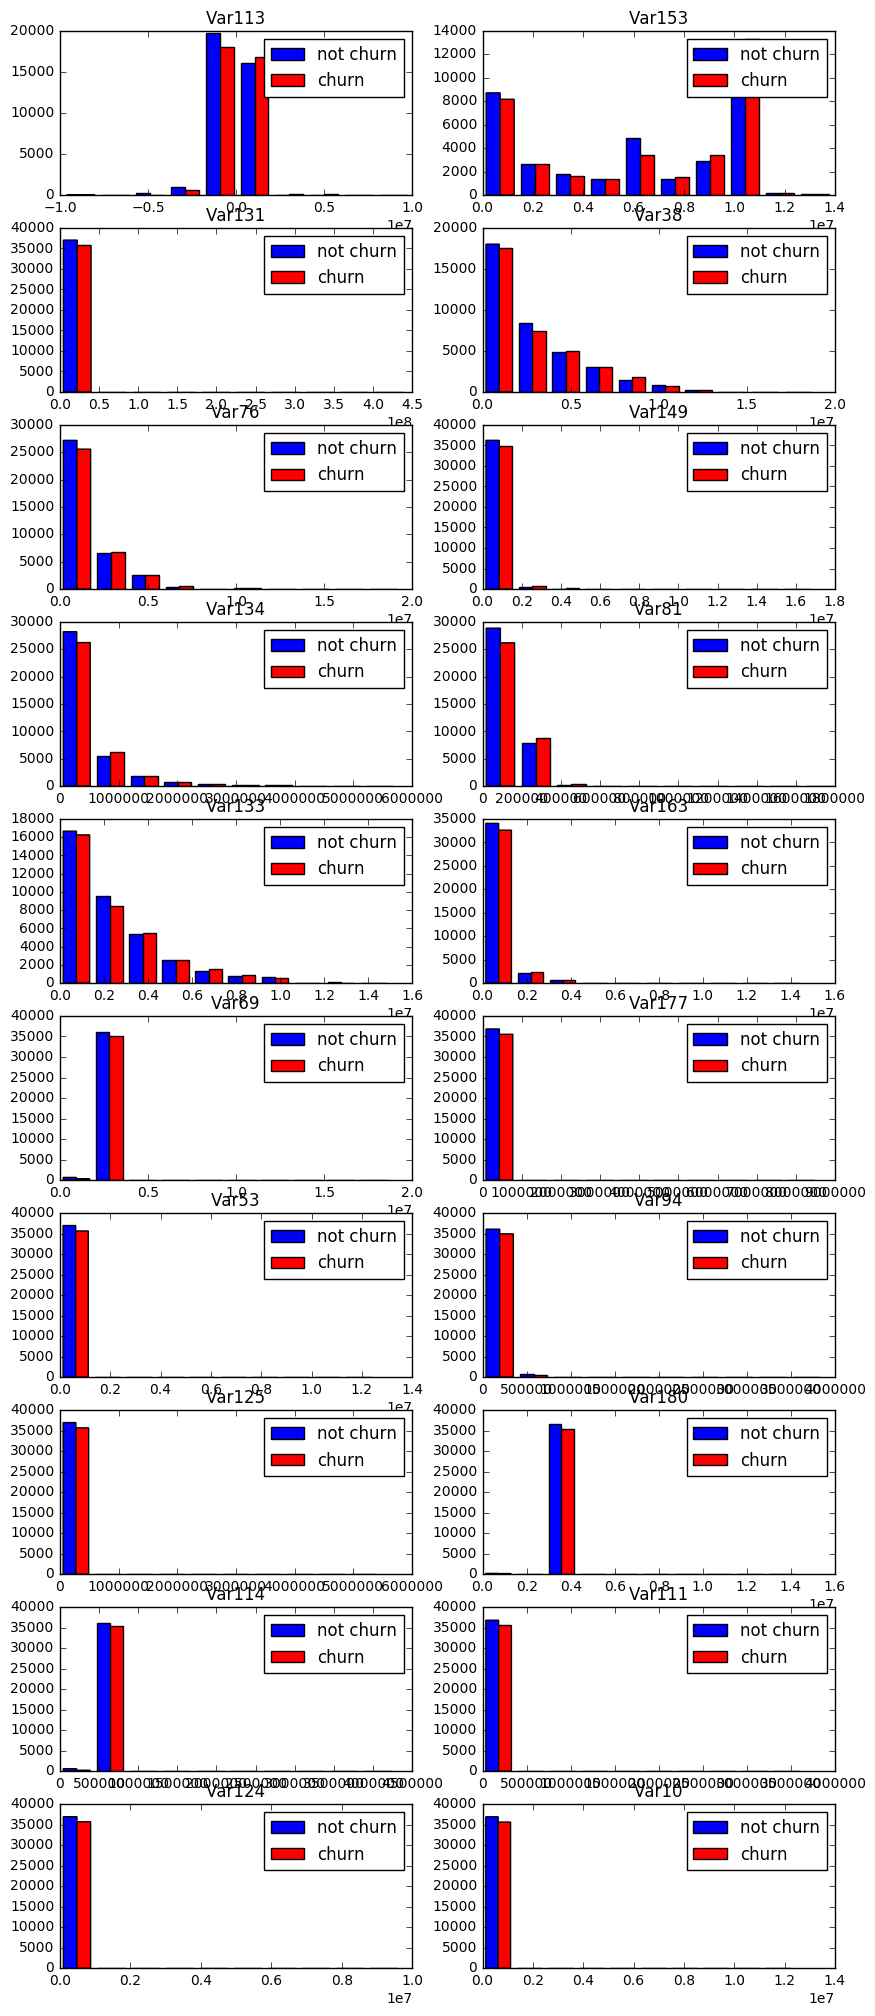

In [16]:
build_distribution_plots(numeric_balanced_frame, top_columns, class_descriptions)

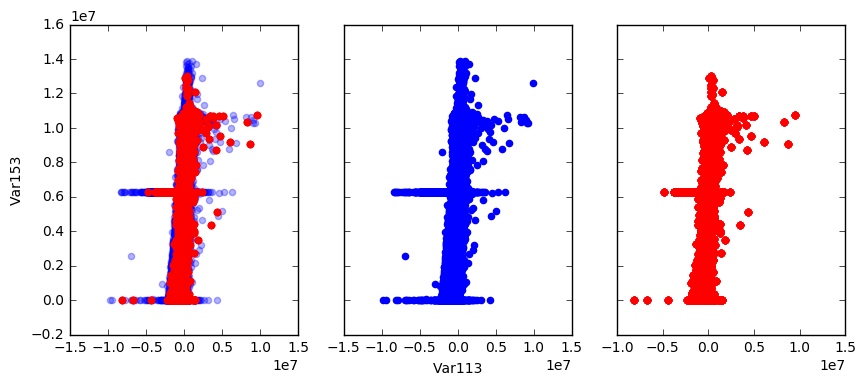

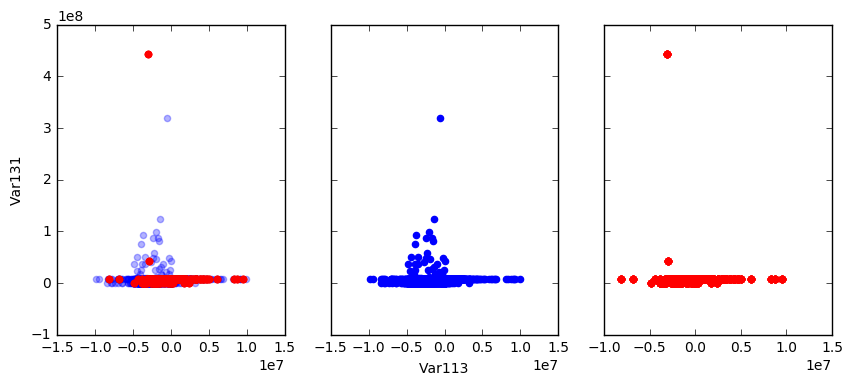

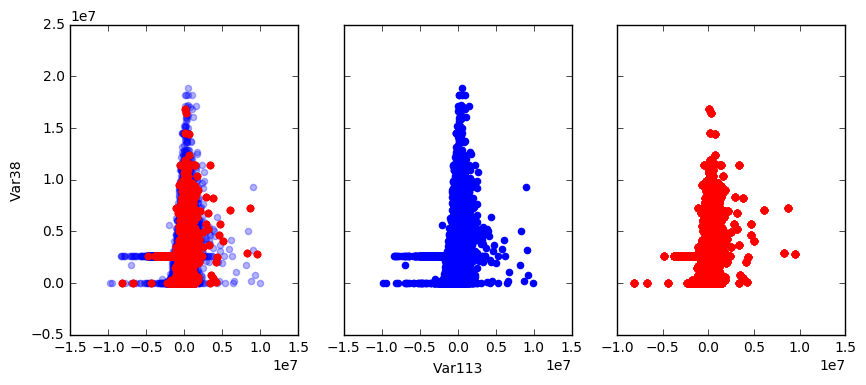

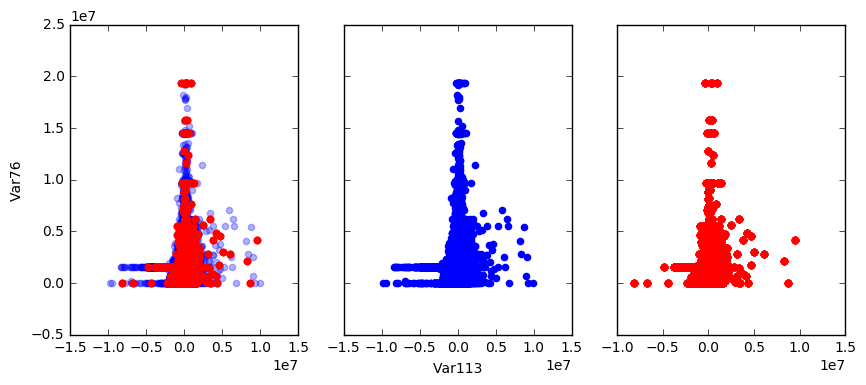

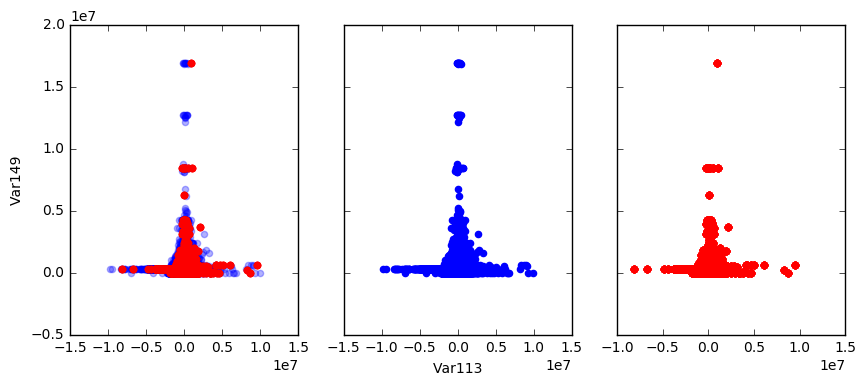

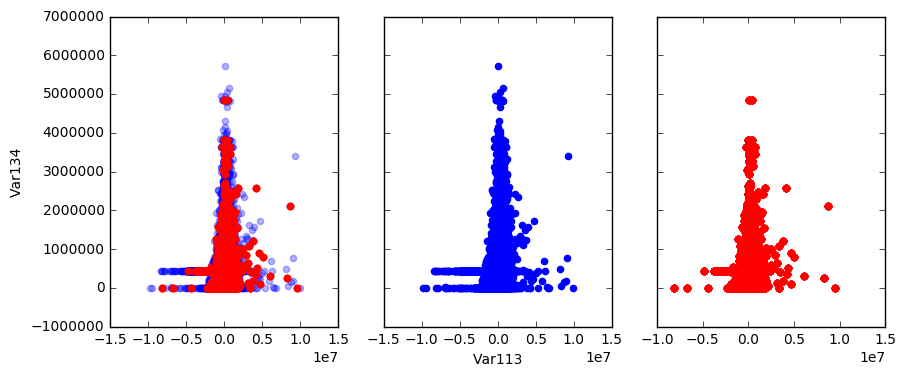

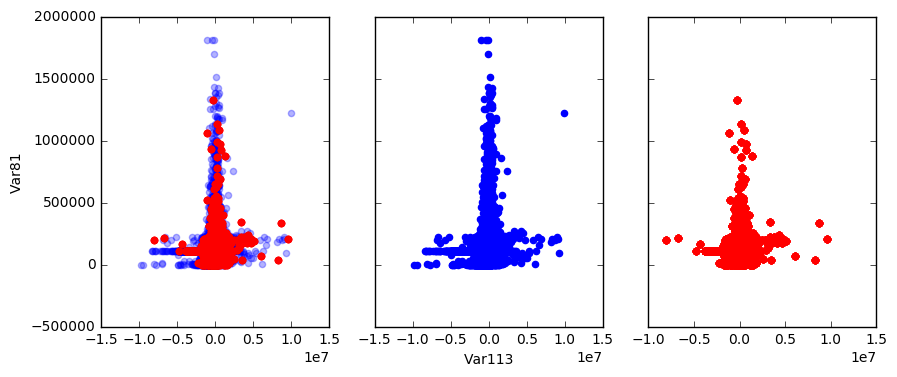

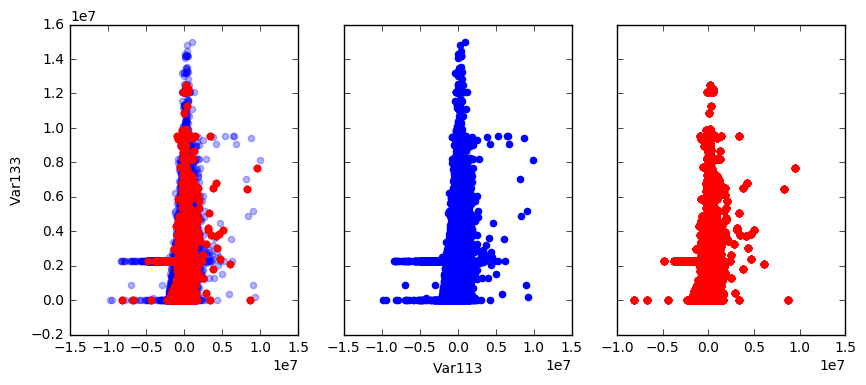

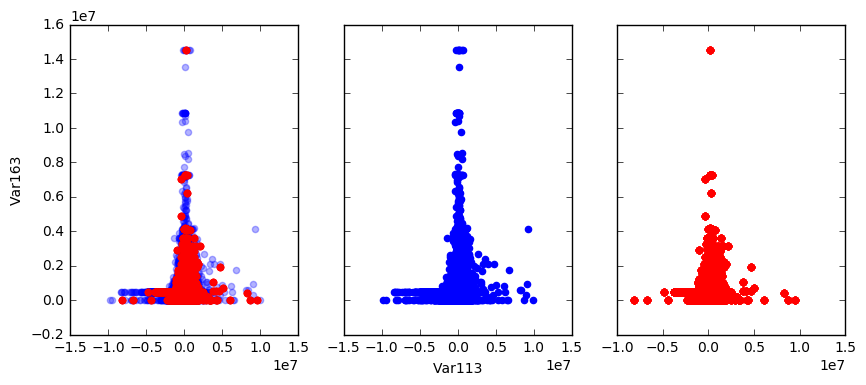

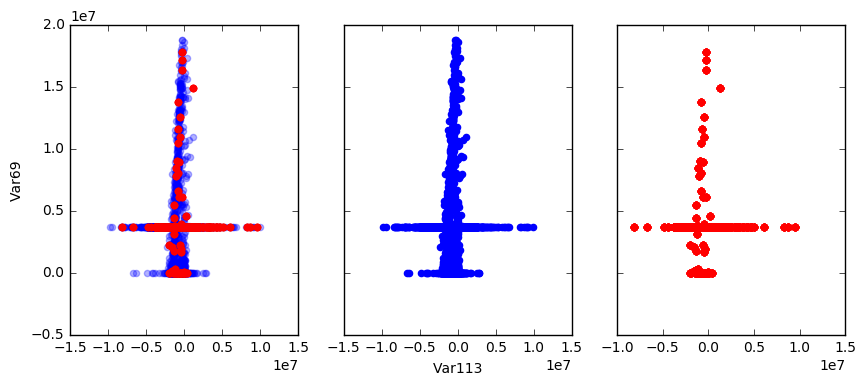

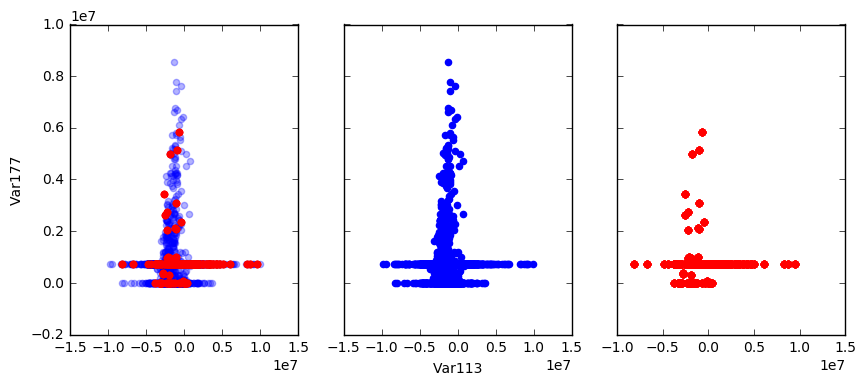

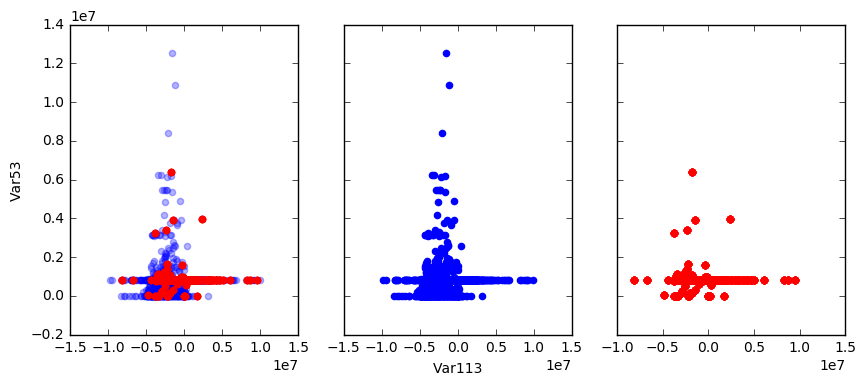

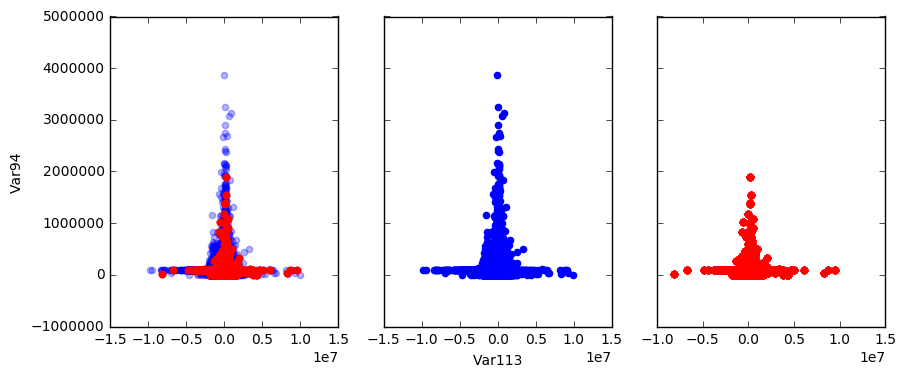

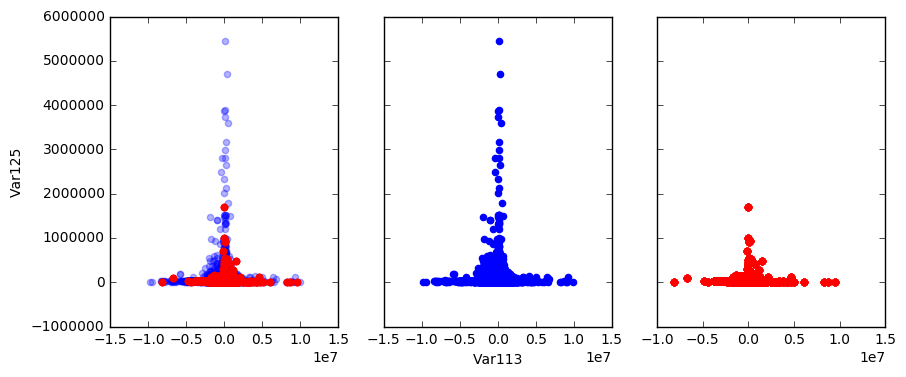

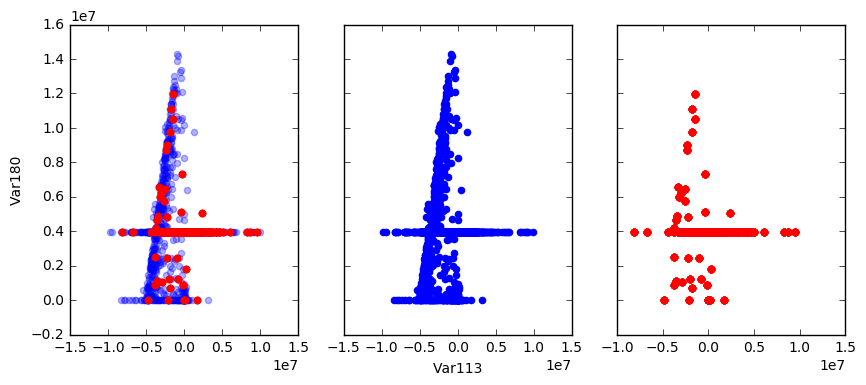

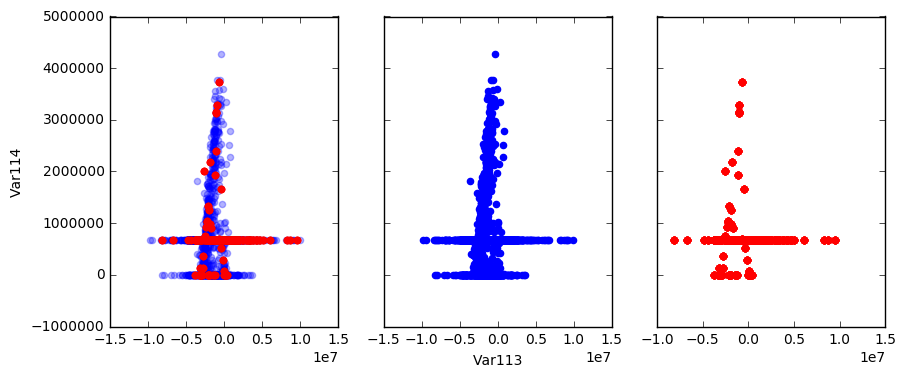

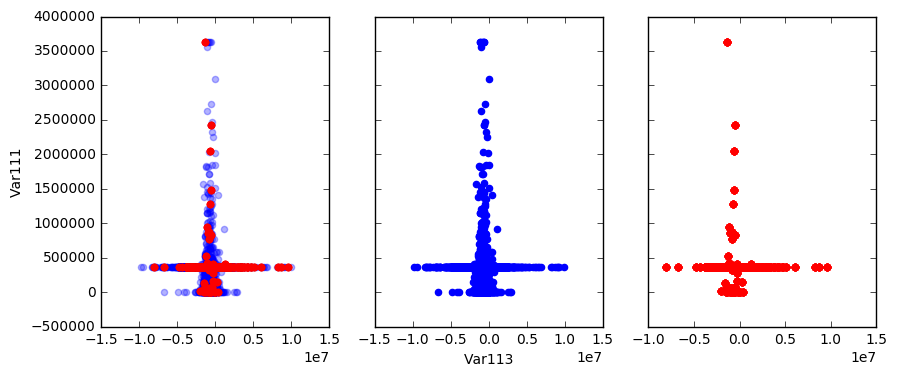

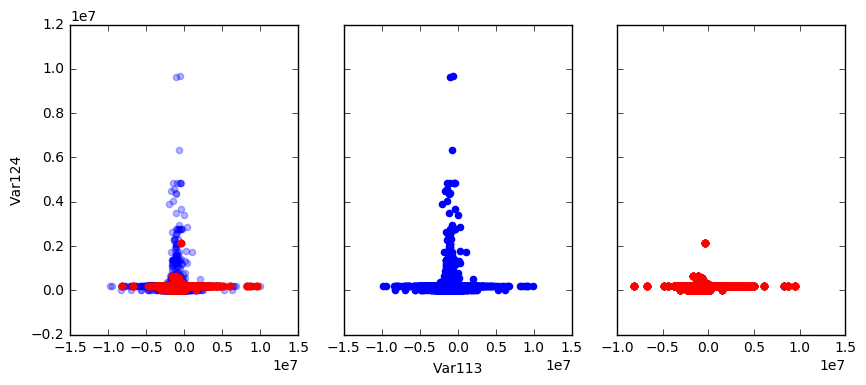

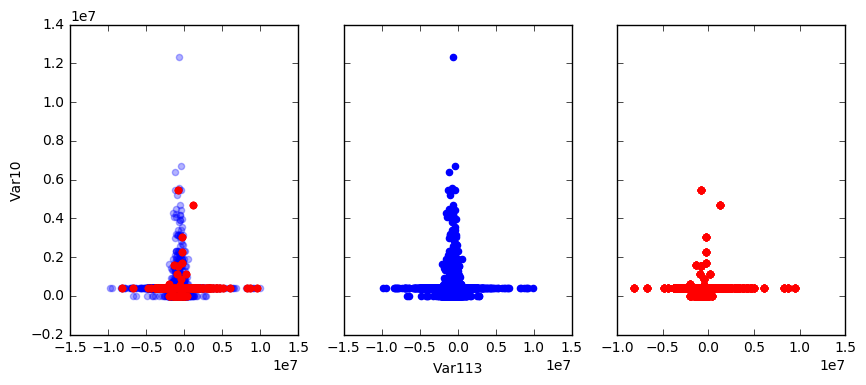

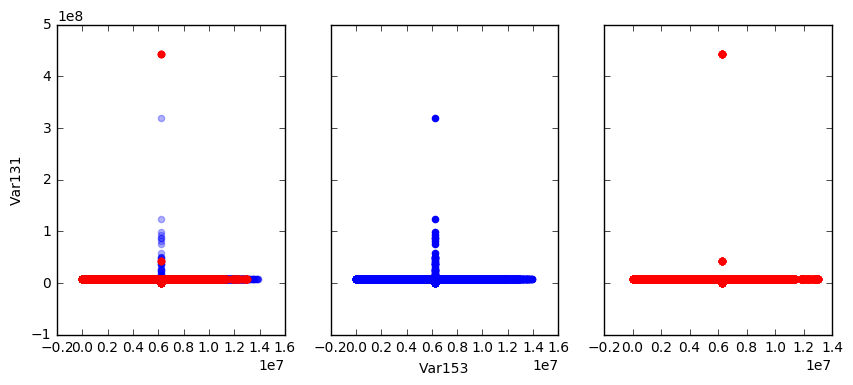

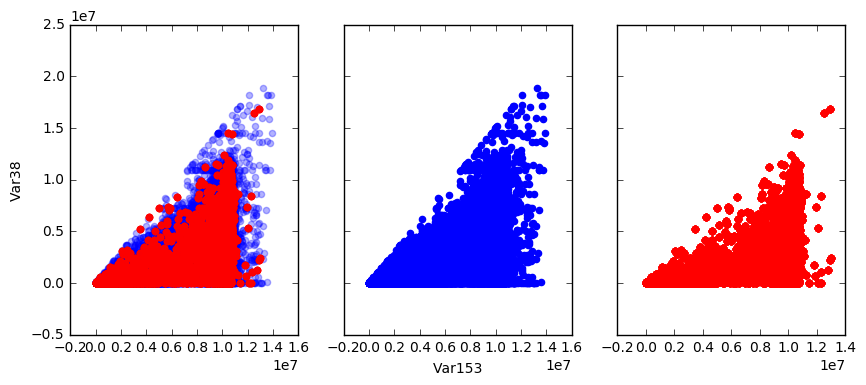

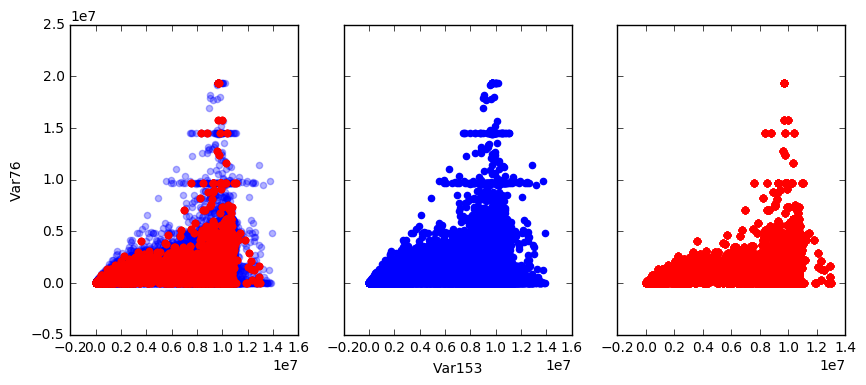

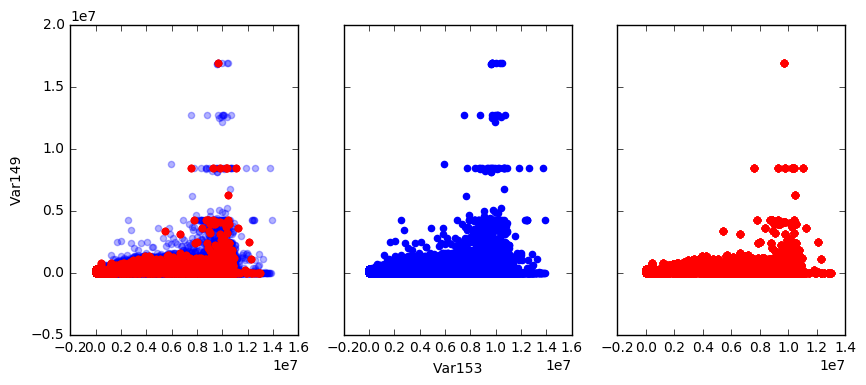

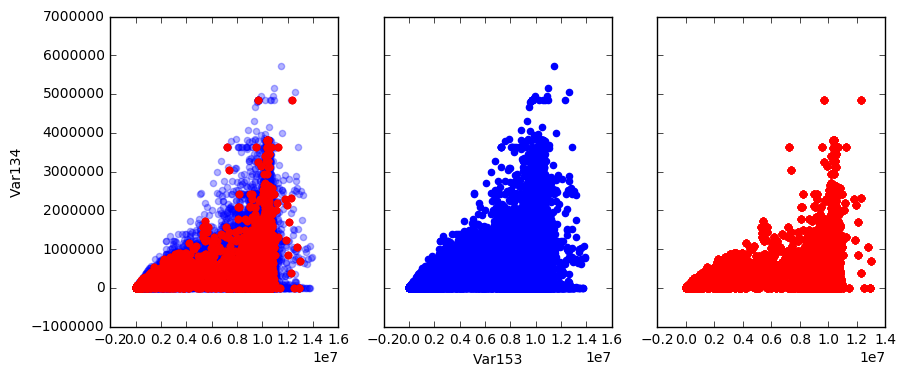

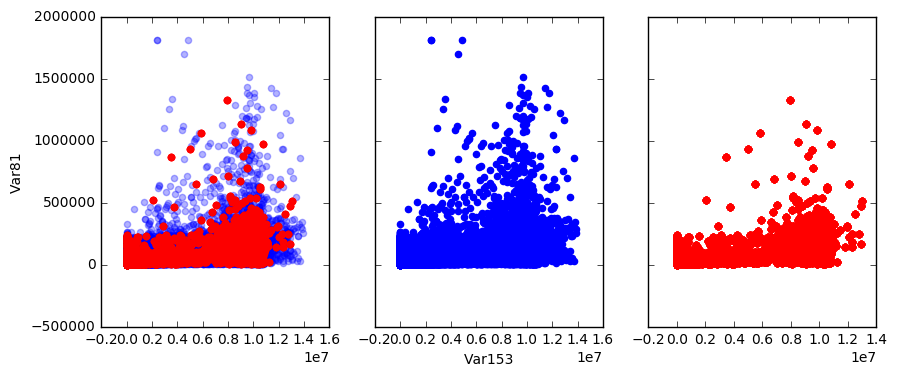

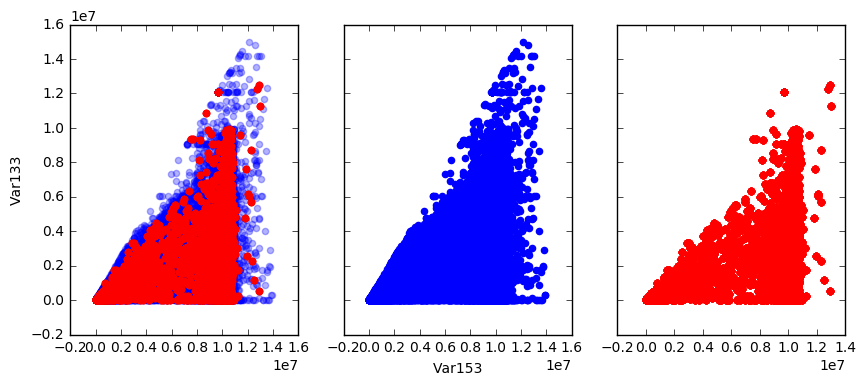

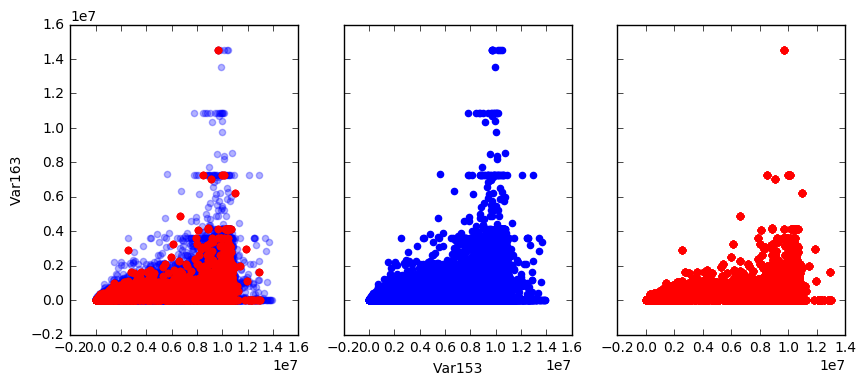

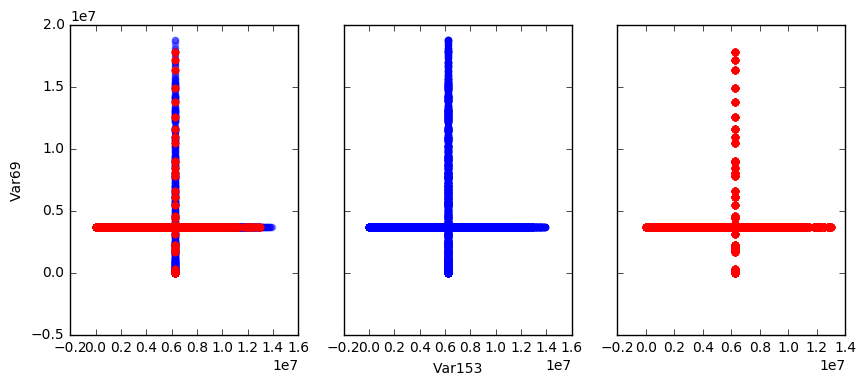

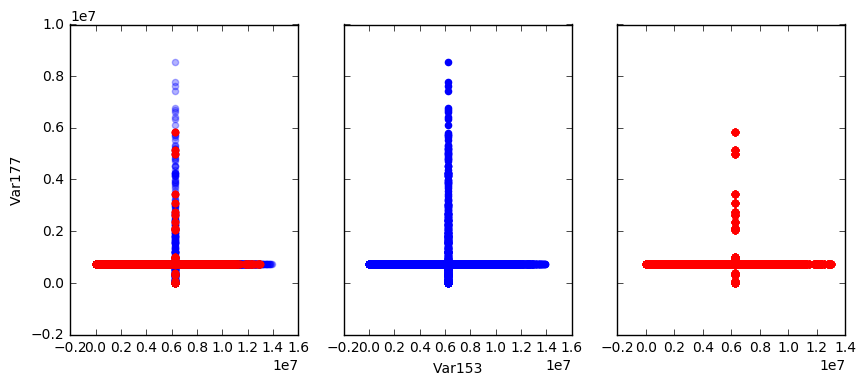

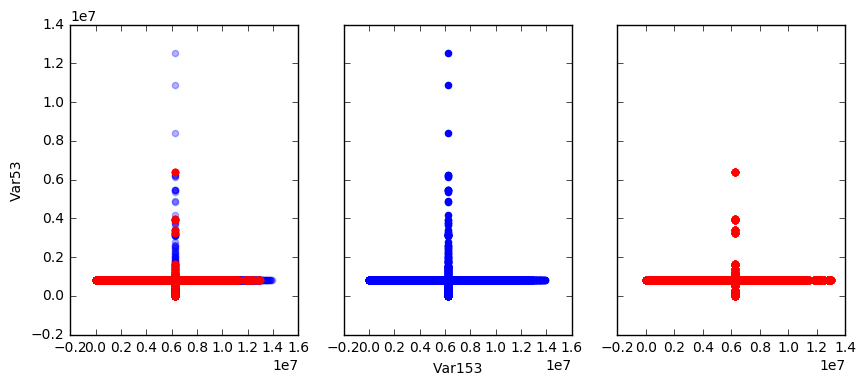

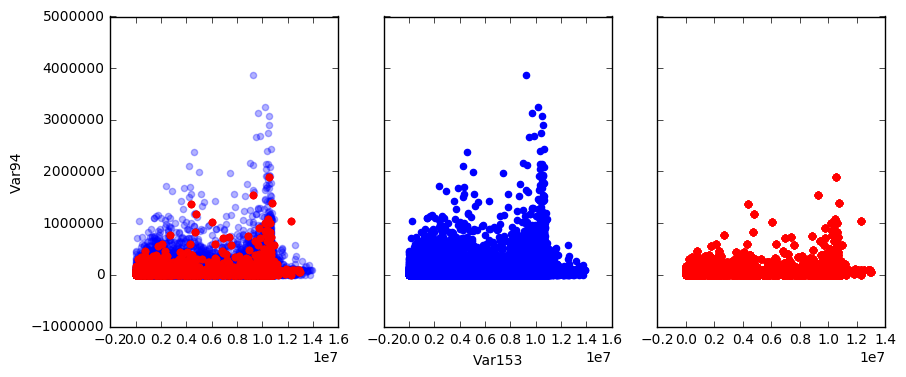

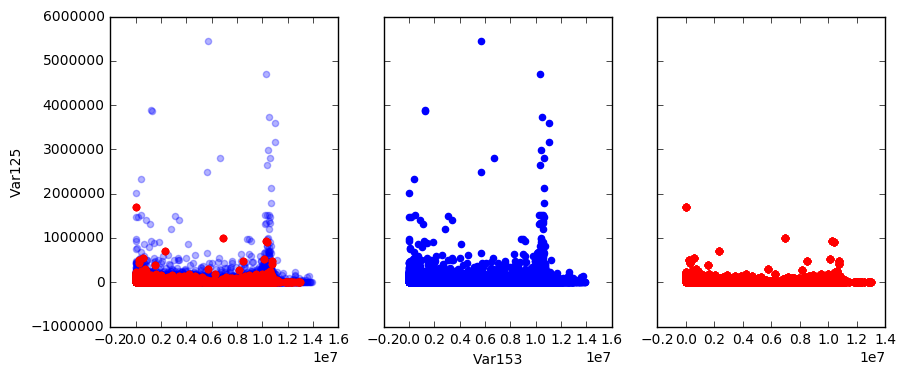

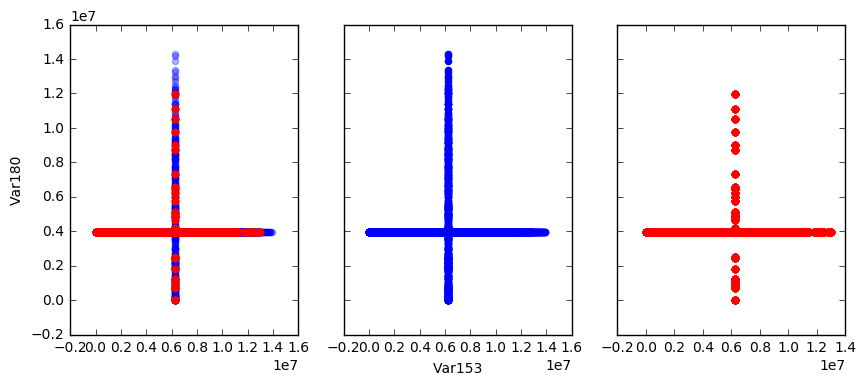

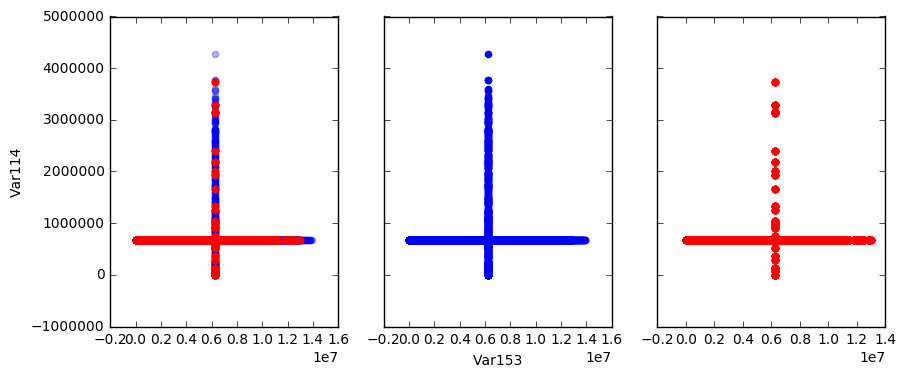

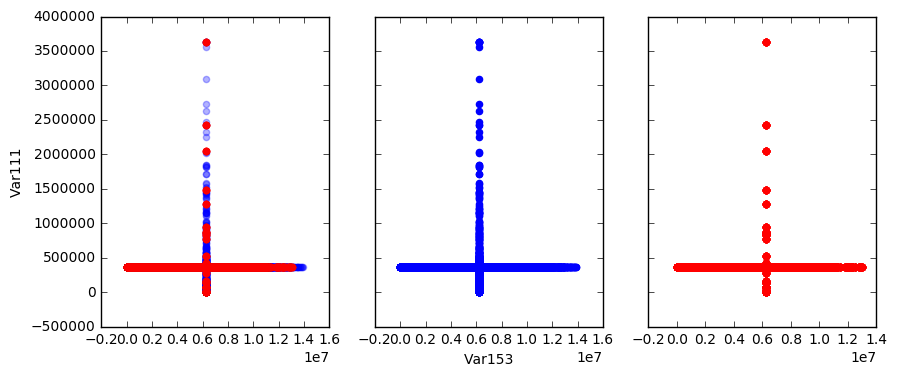

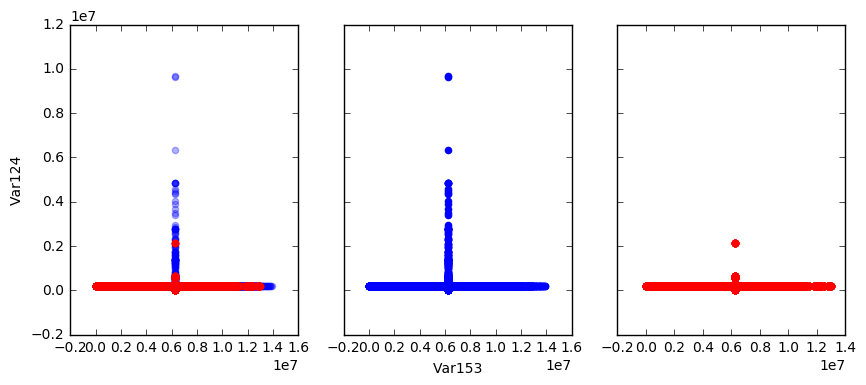

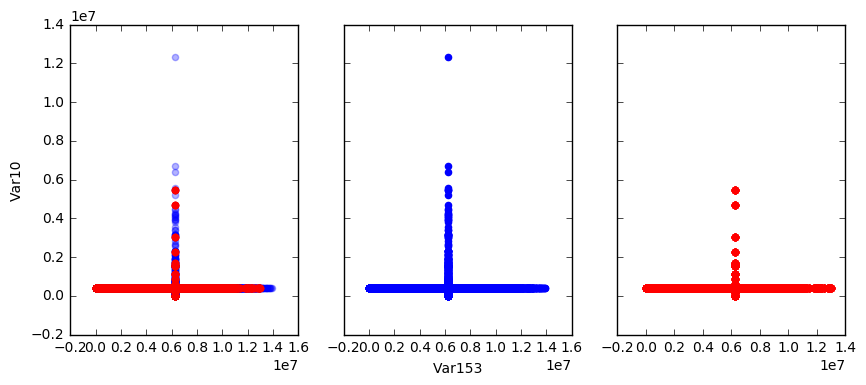

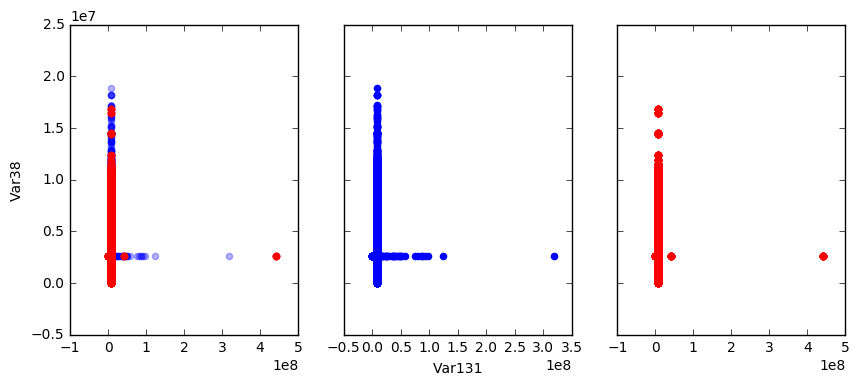

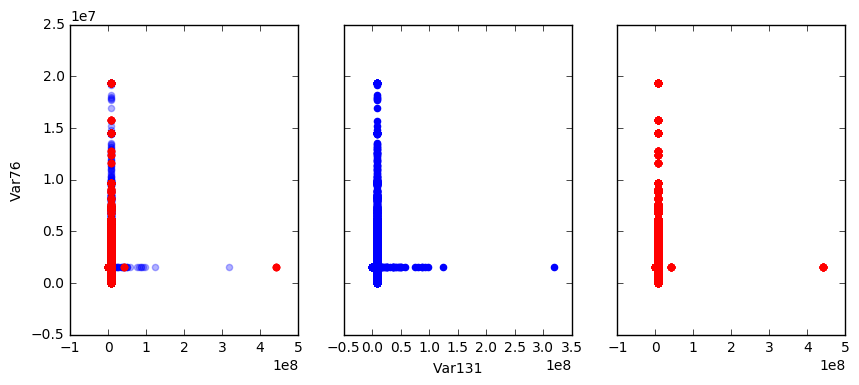

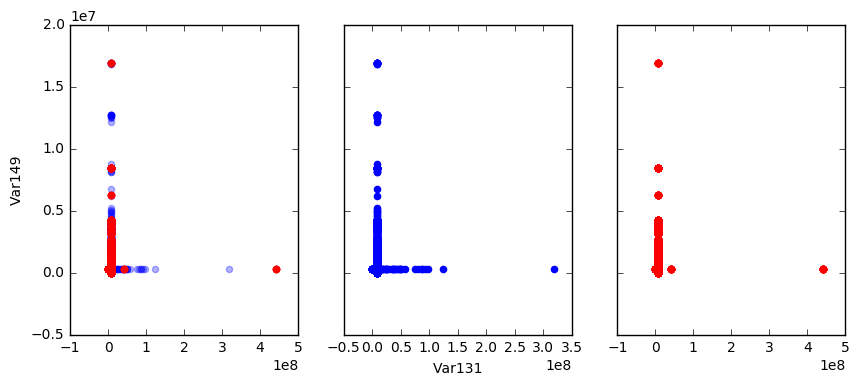

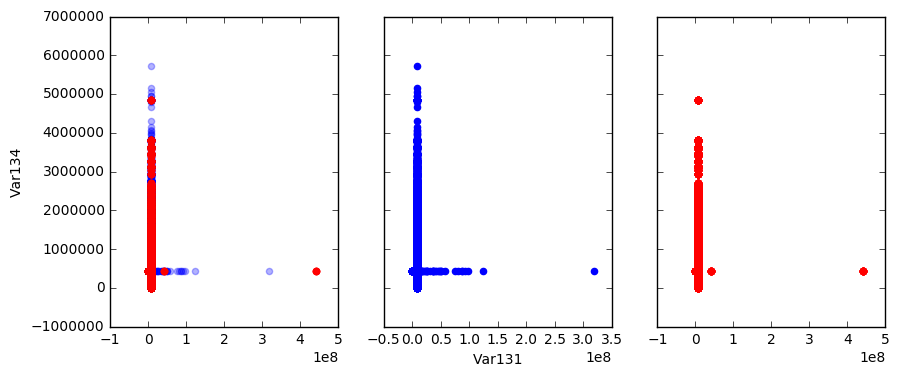

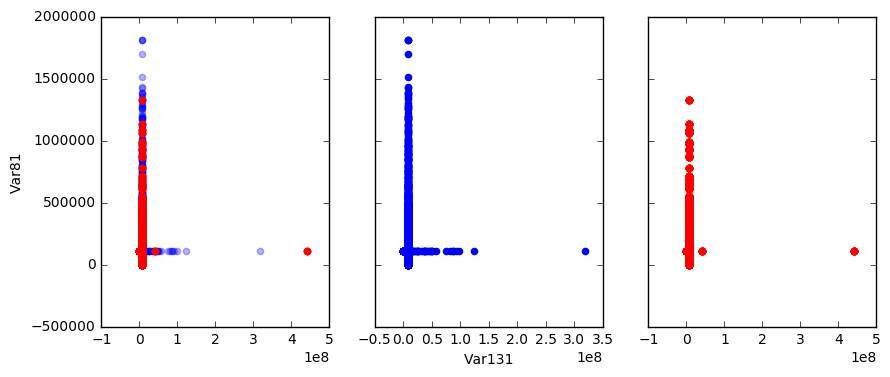

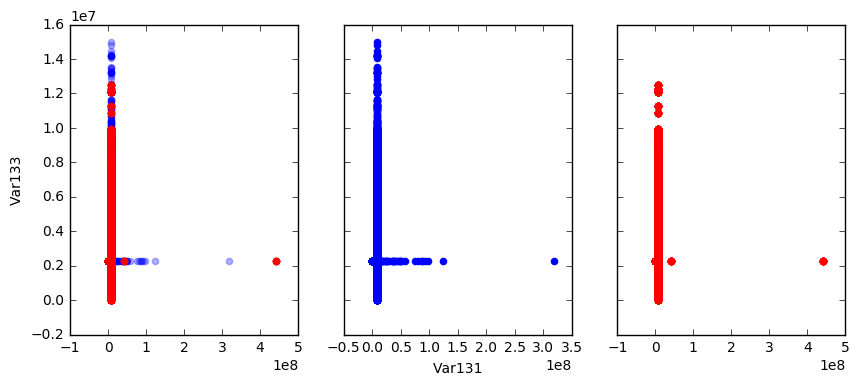

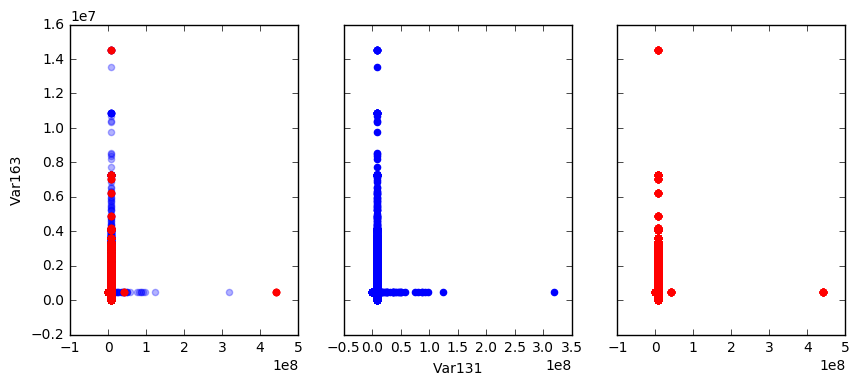

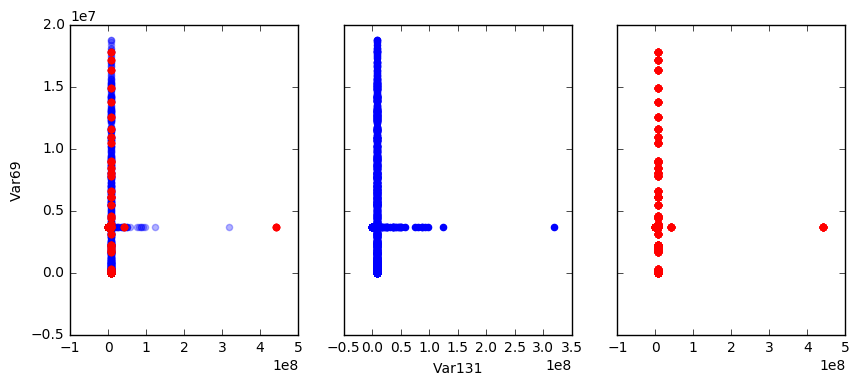

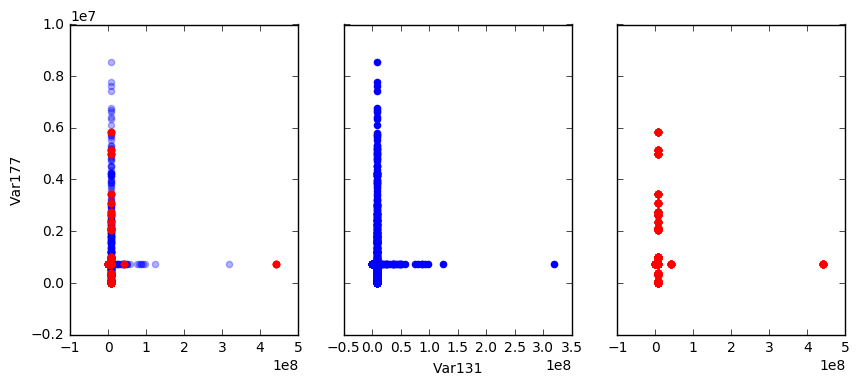

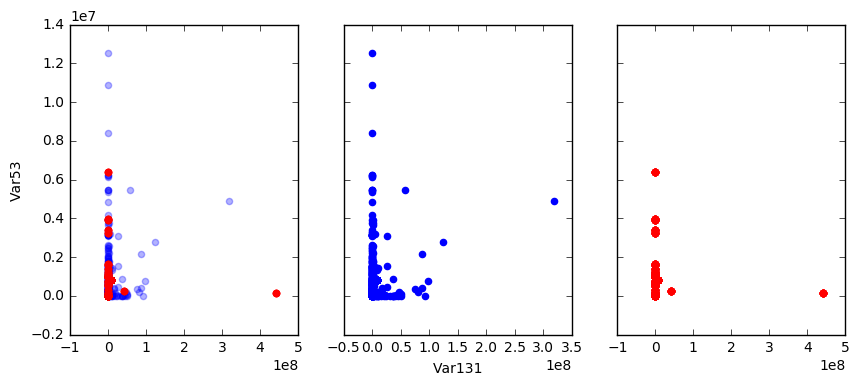

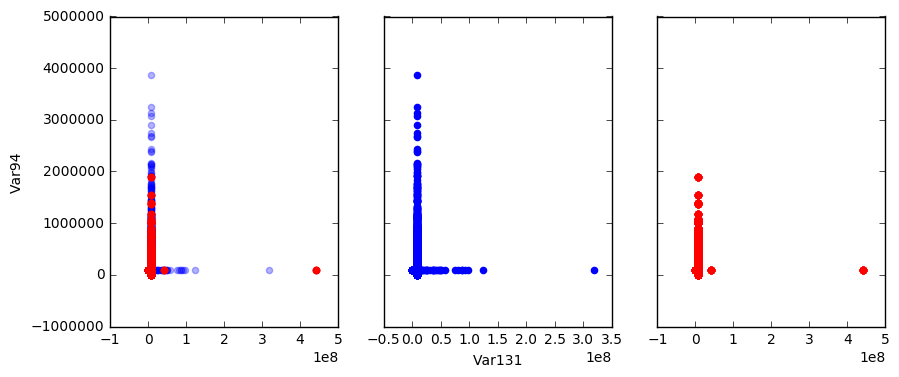

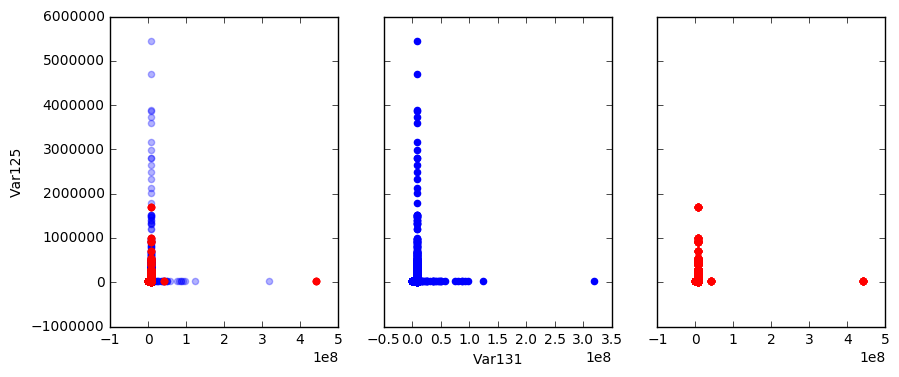

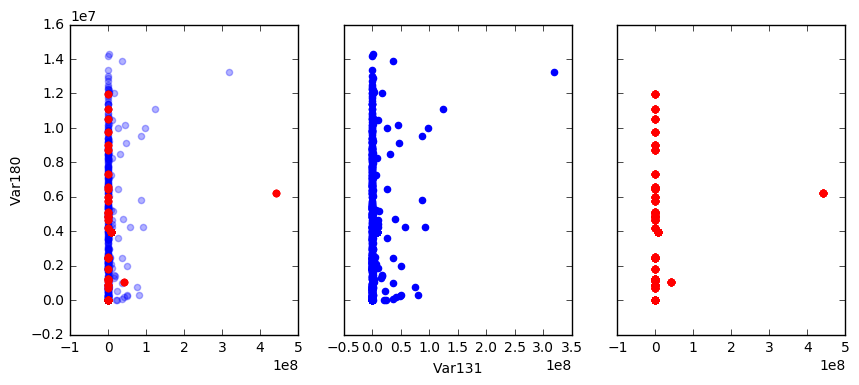

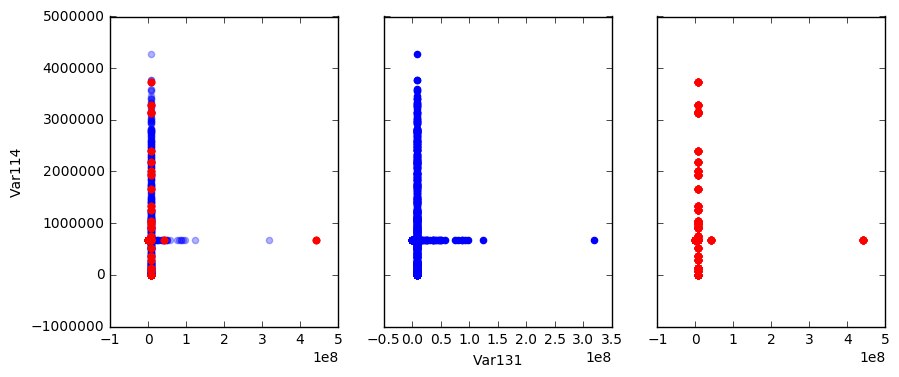

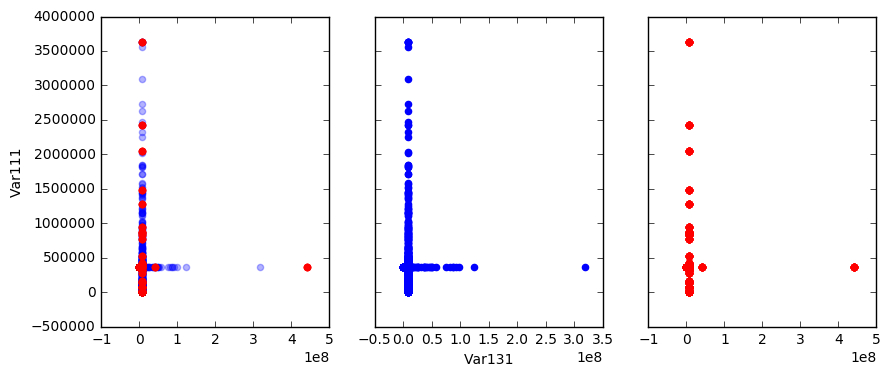

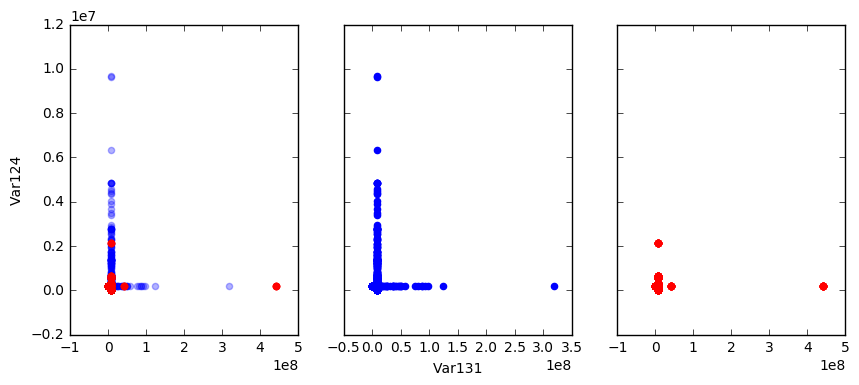

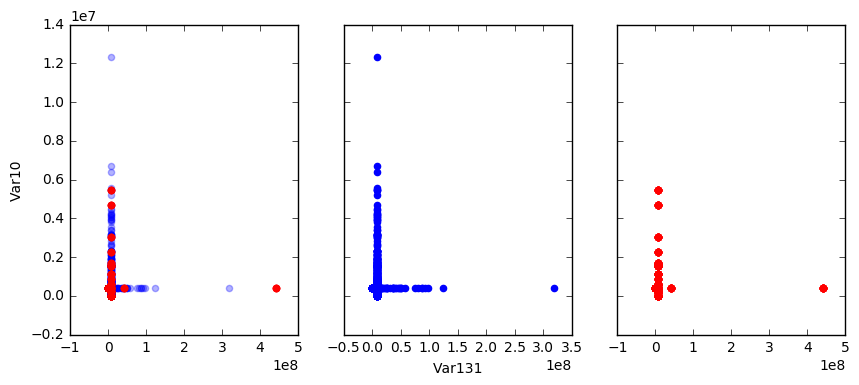

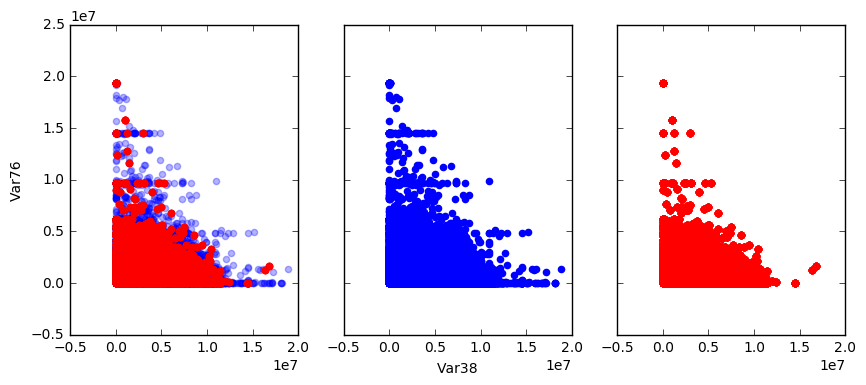

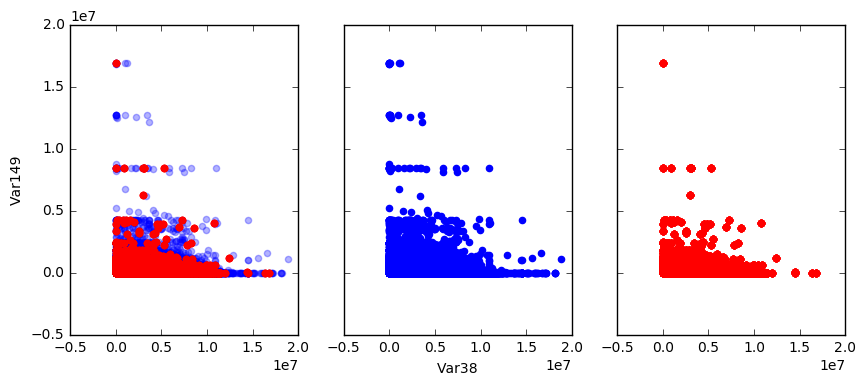

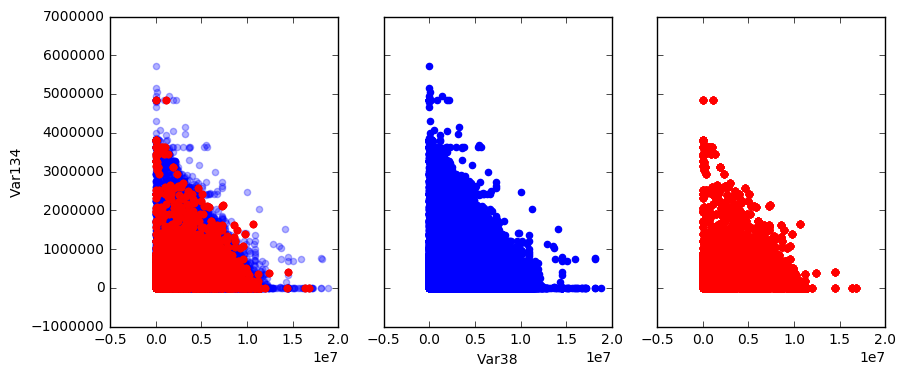

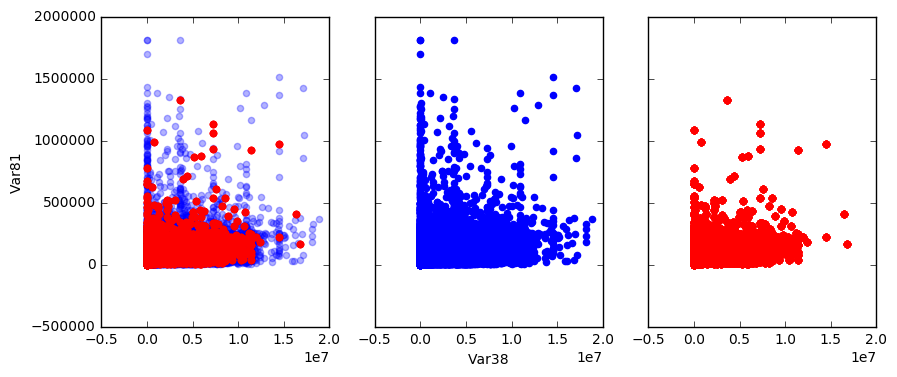

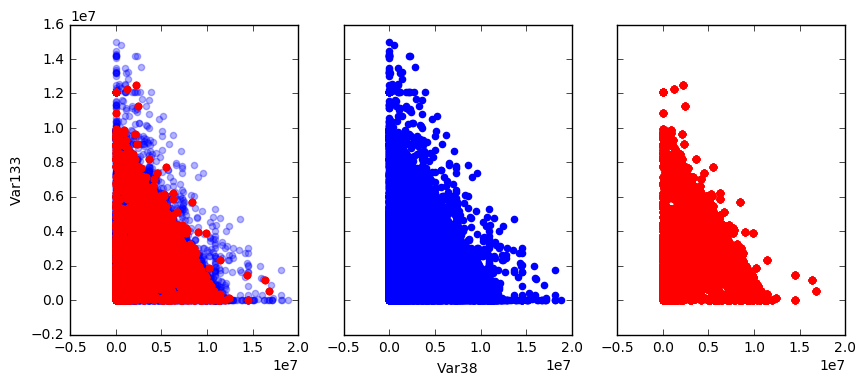

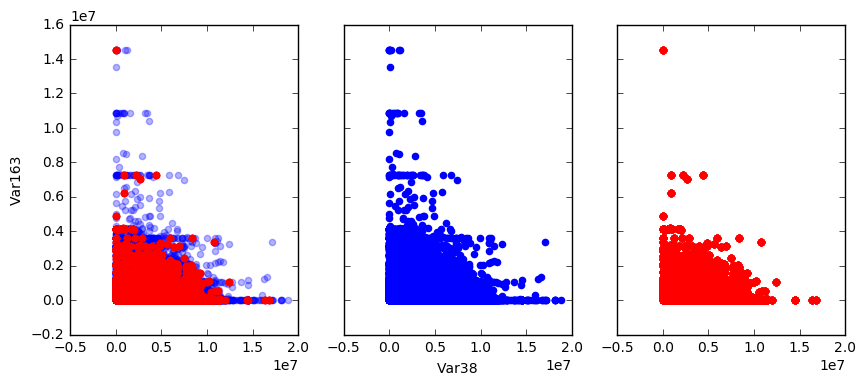

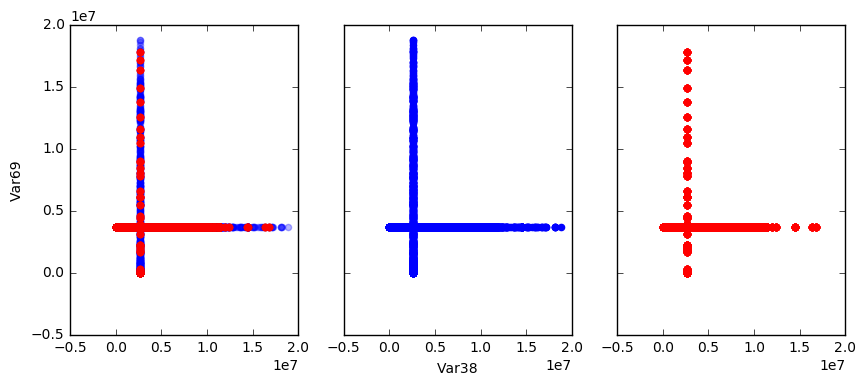

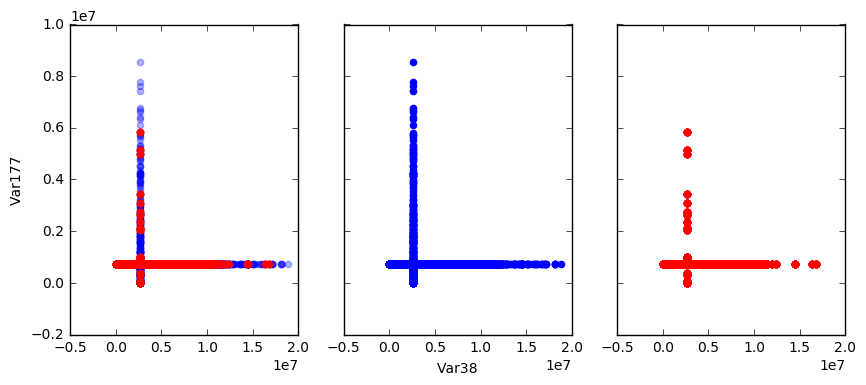

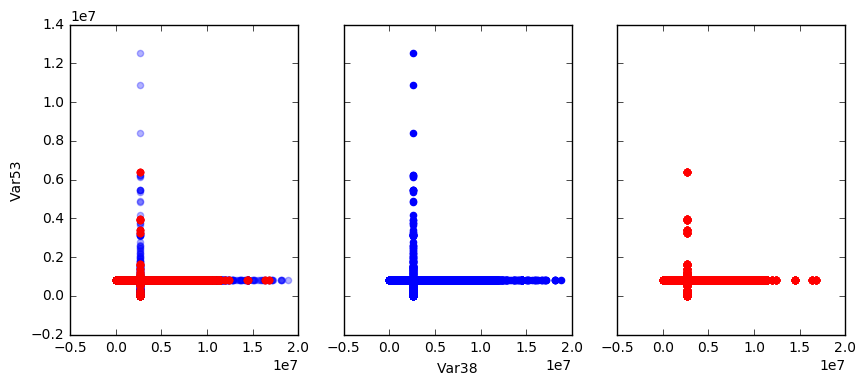

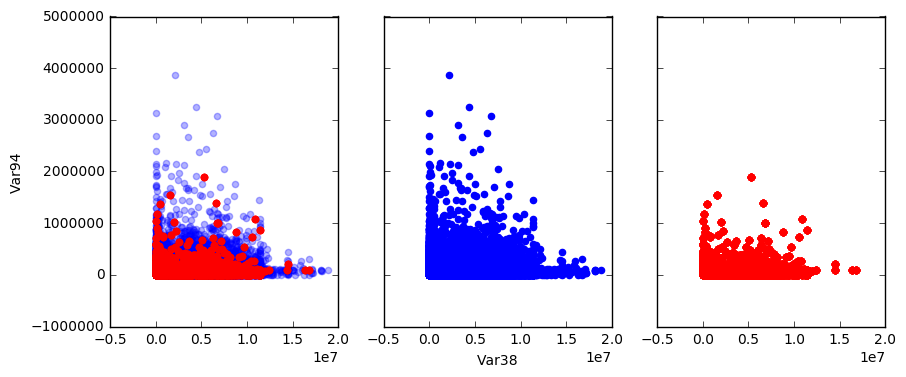

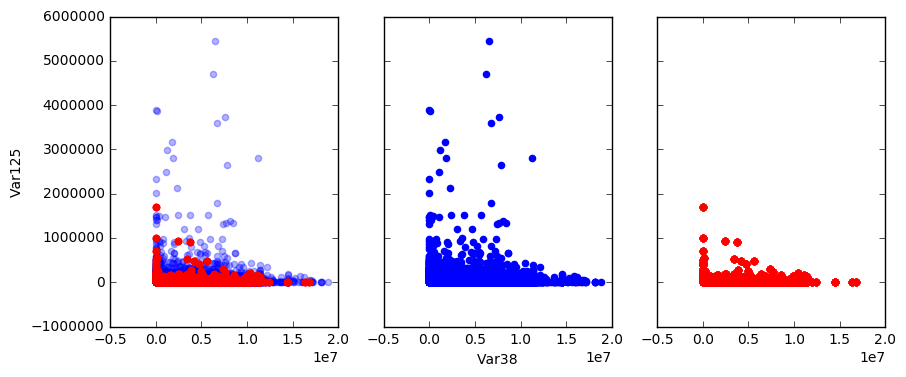

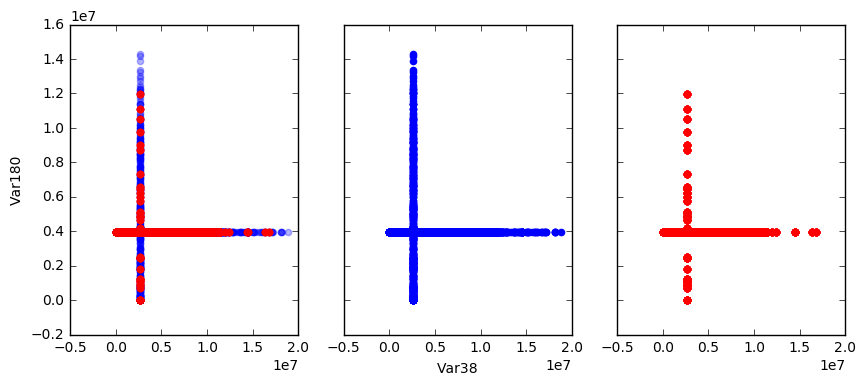

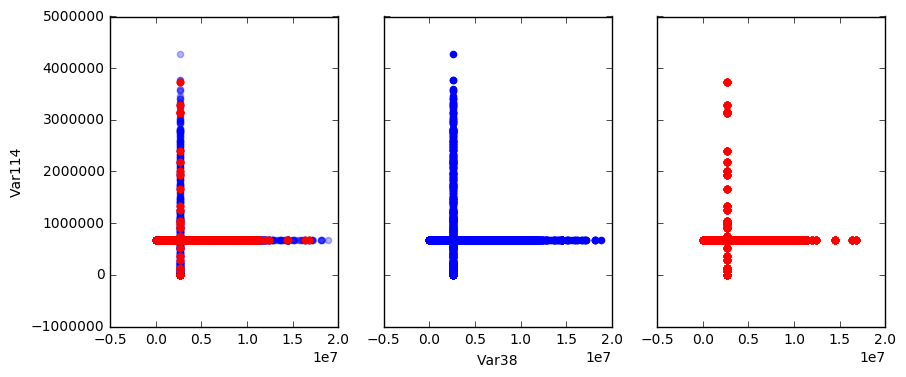

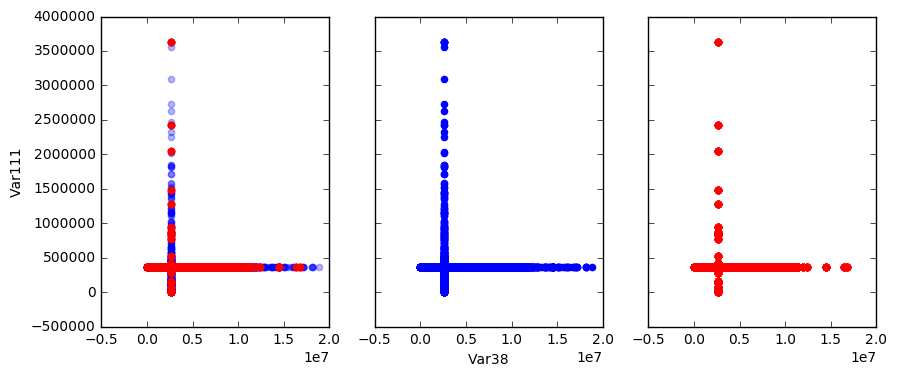

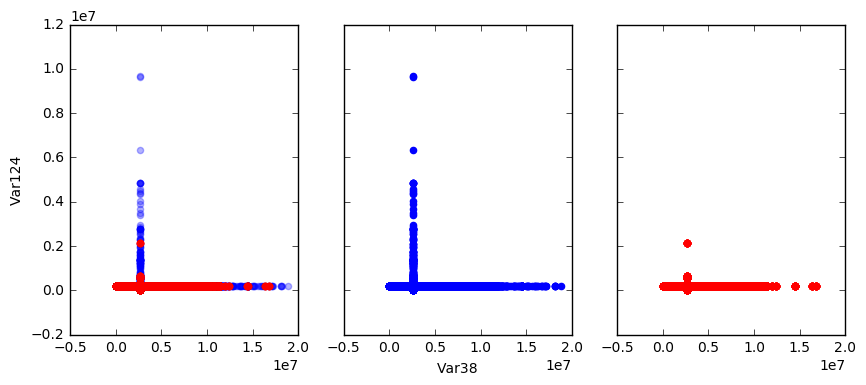

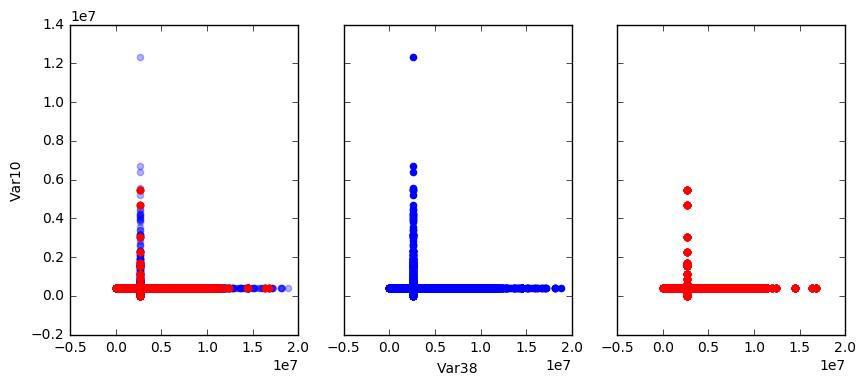

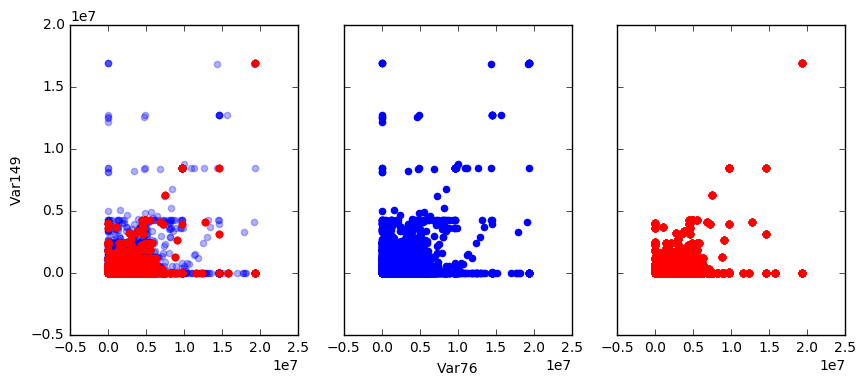

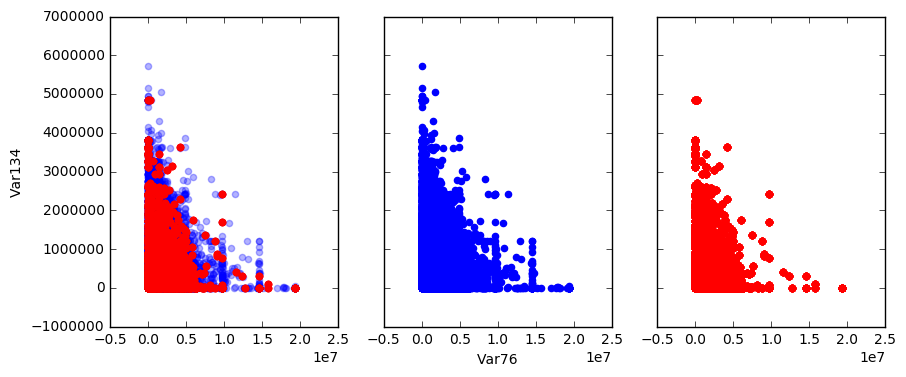

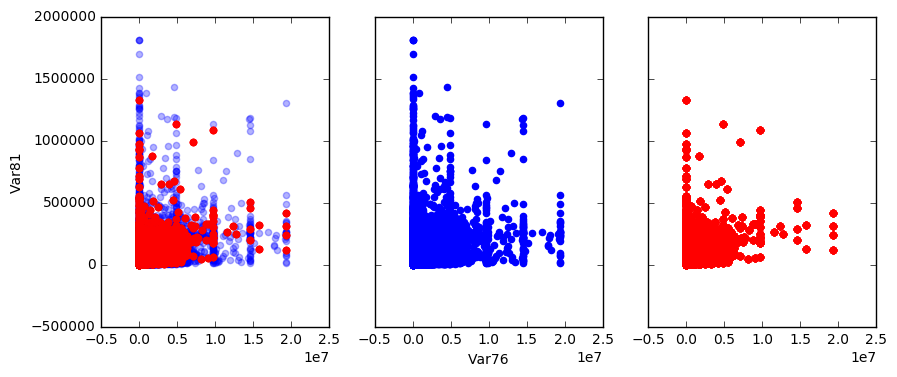

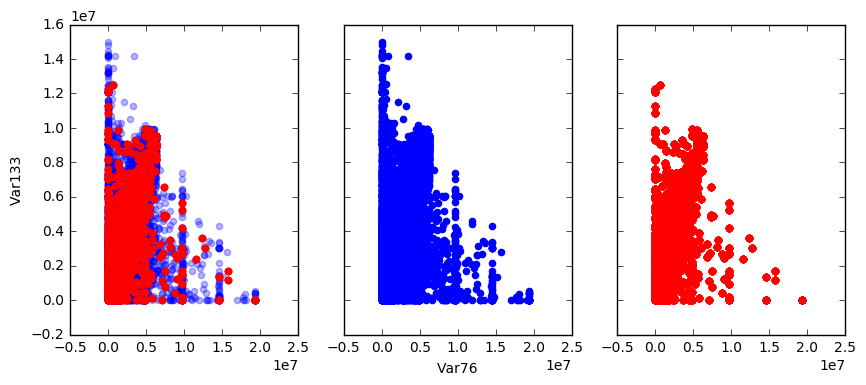

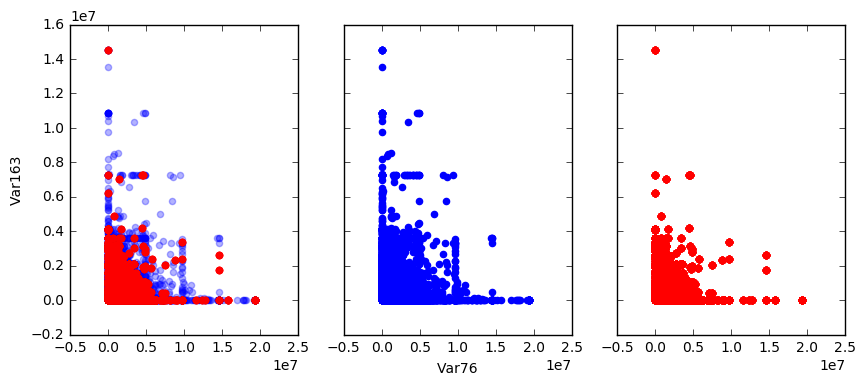

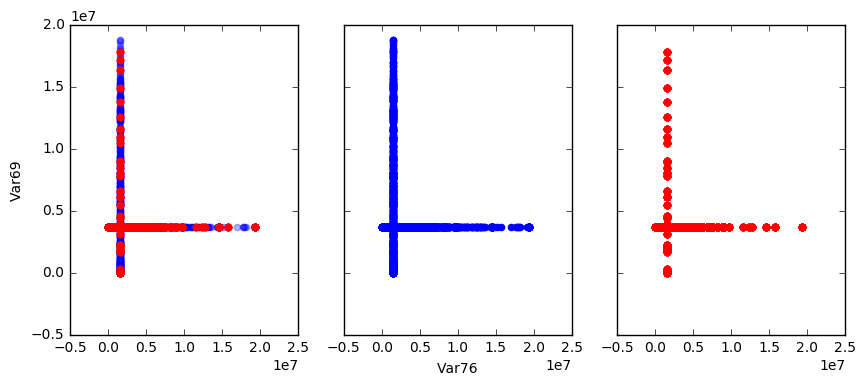

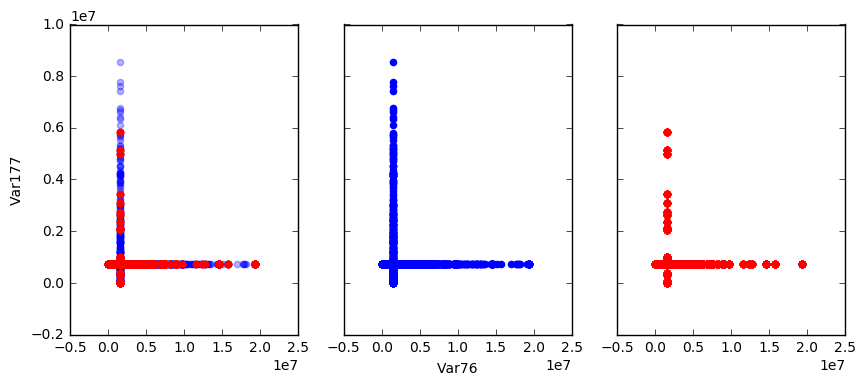

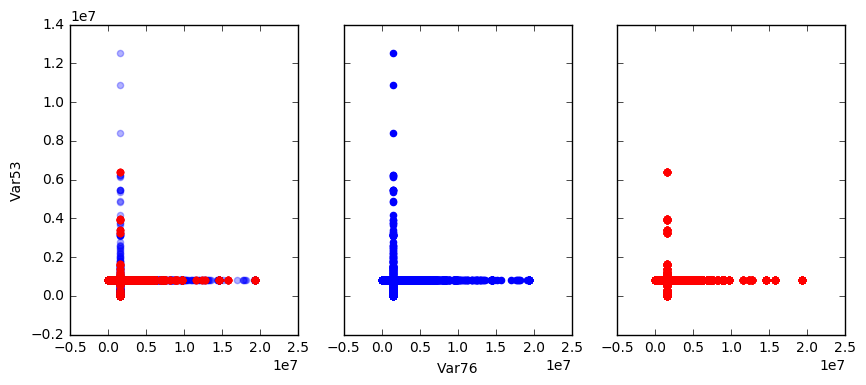

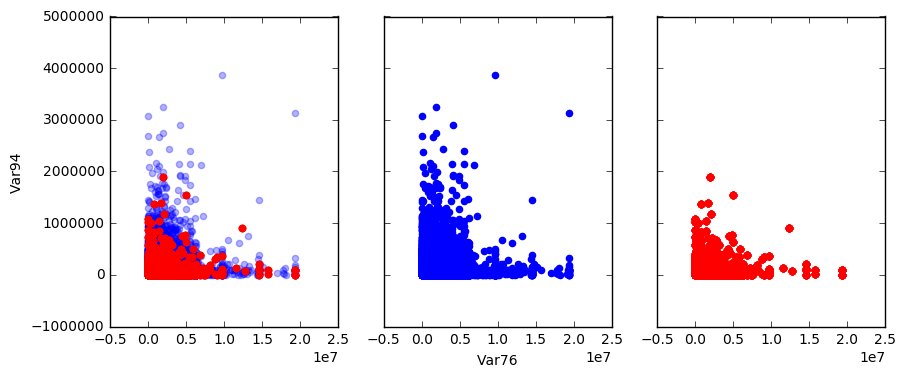

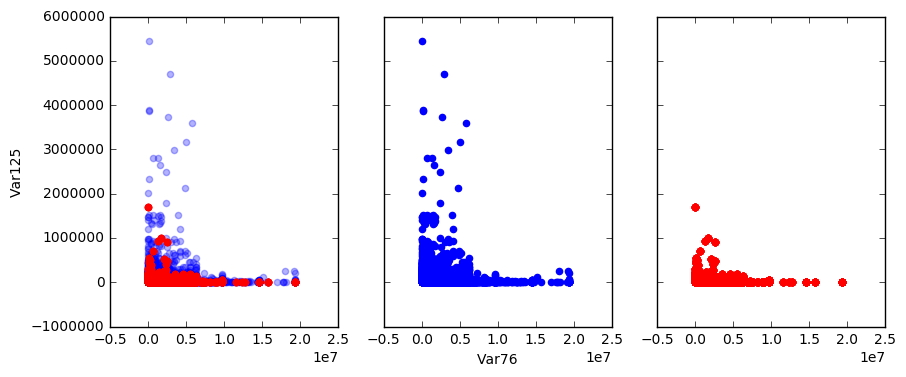

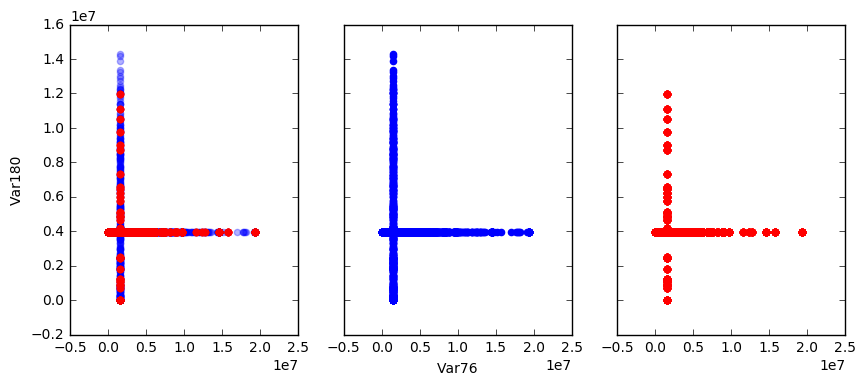

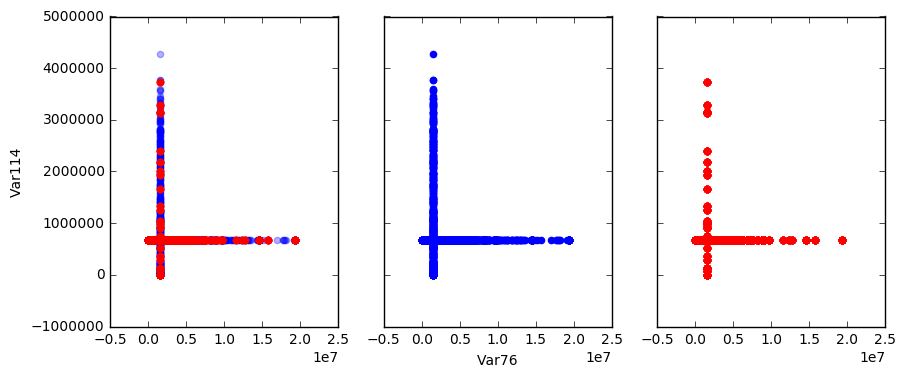

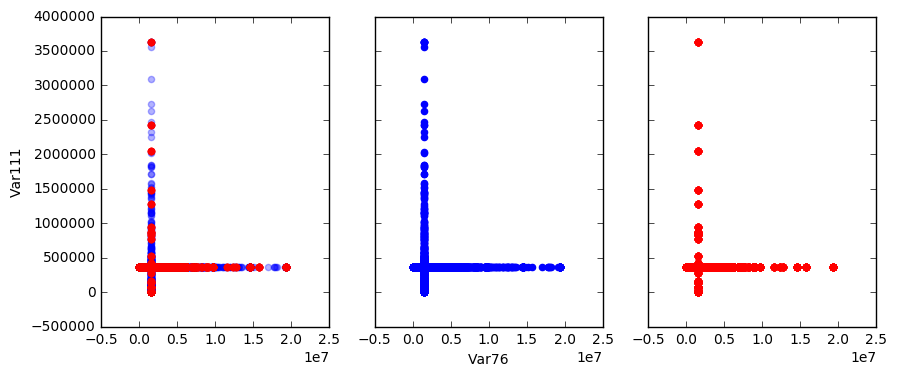

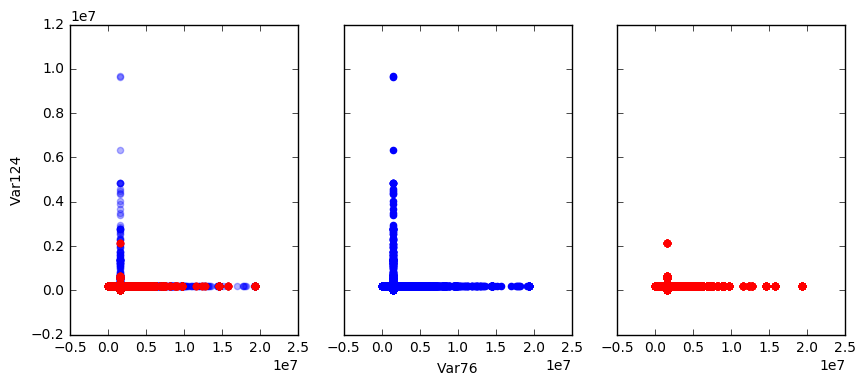

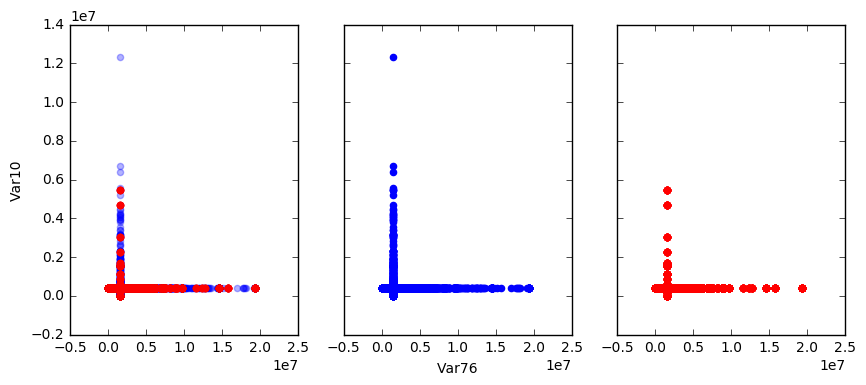

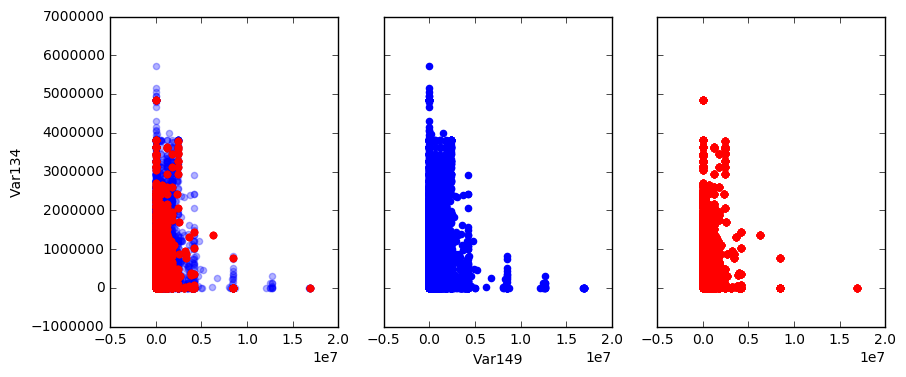

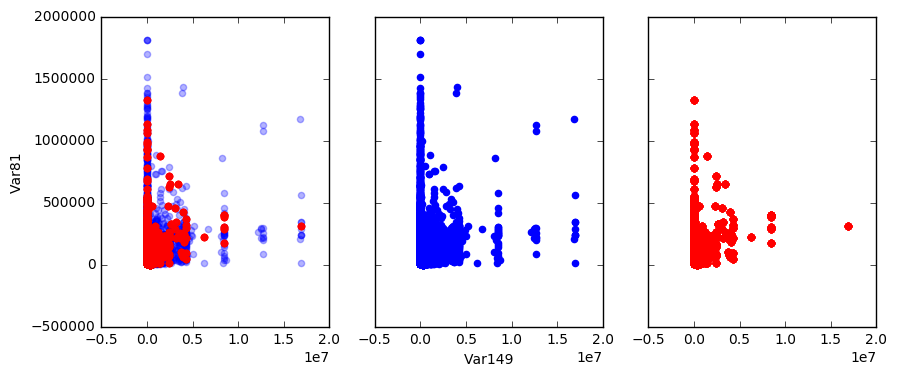

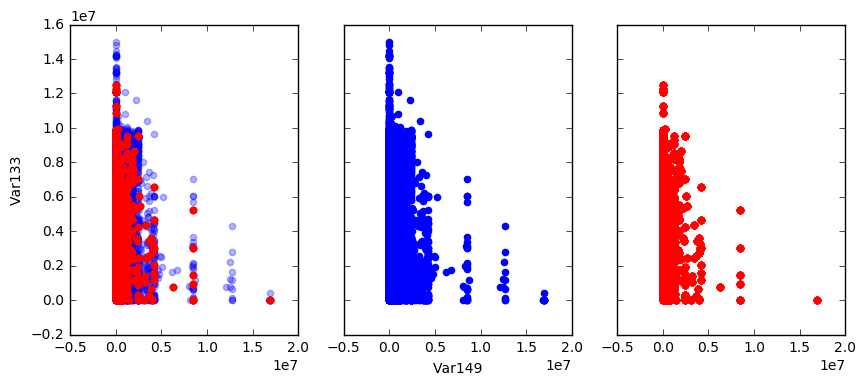

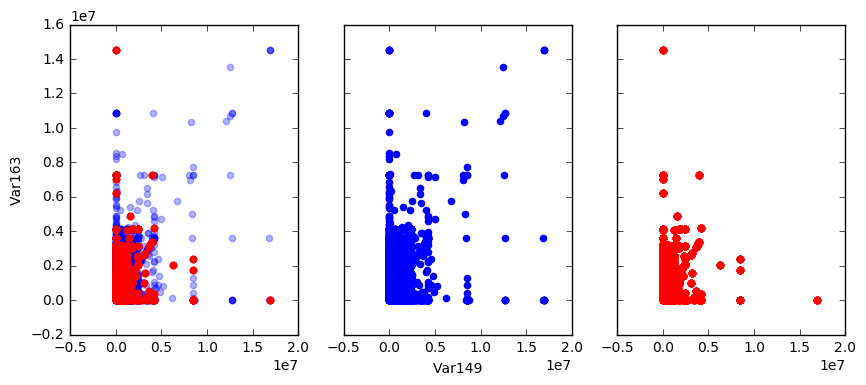

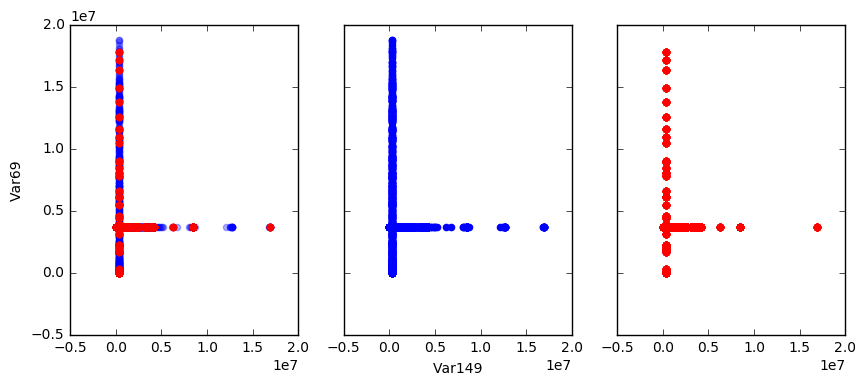

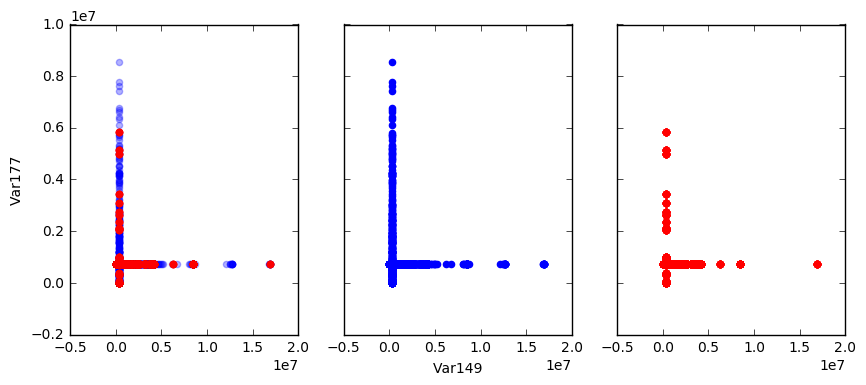

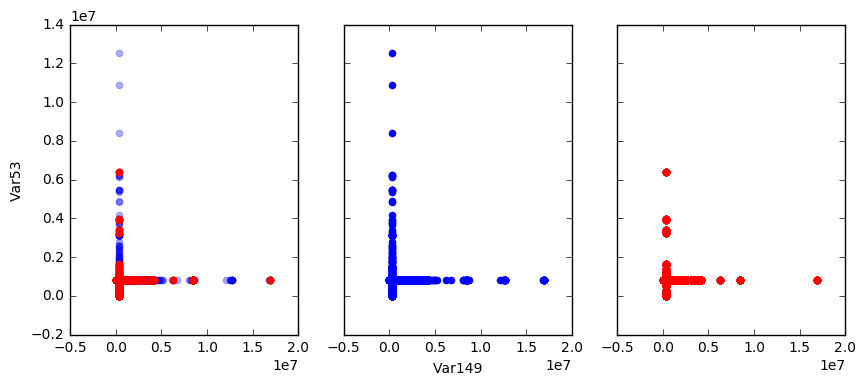

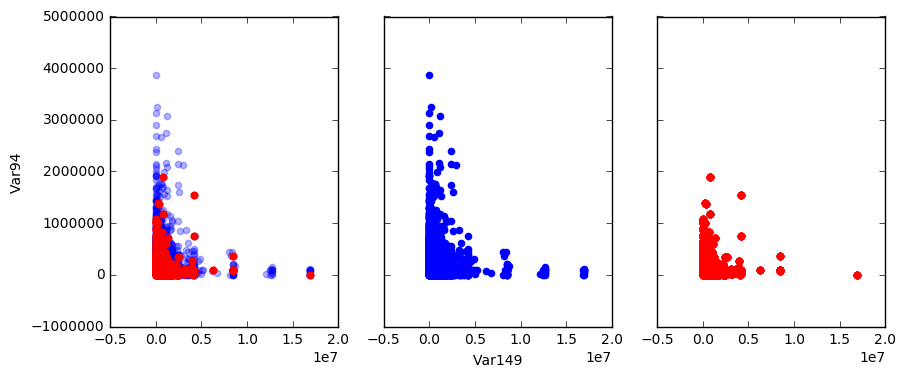

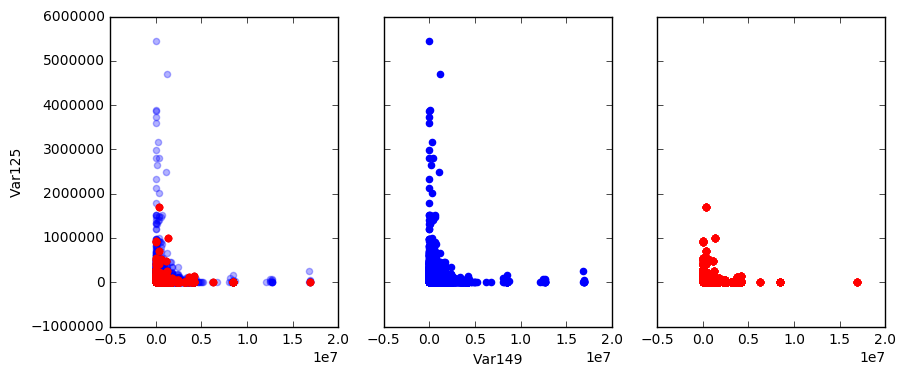

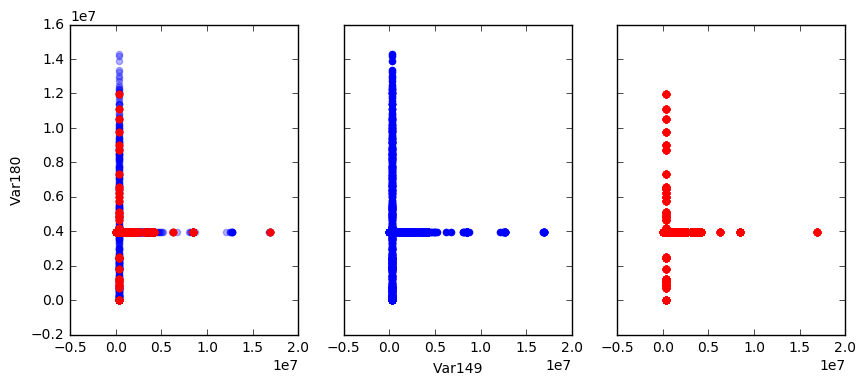

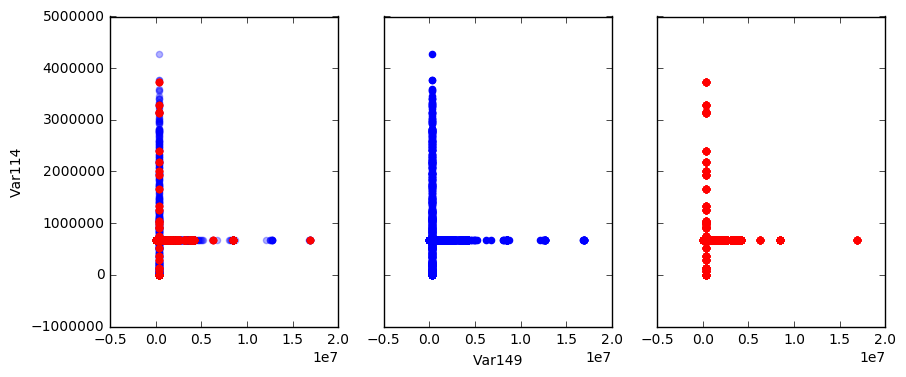

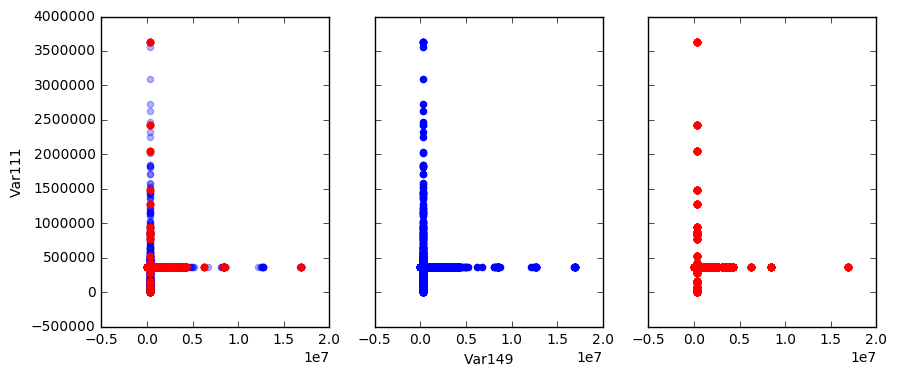

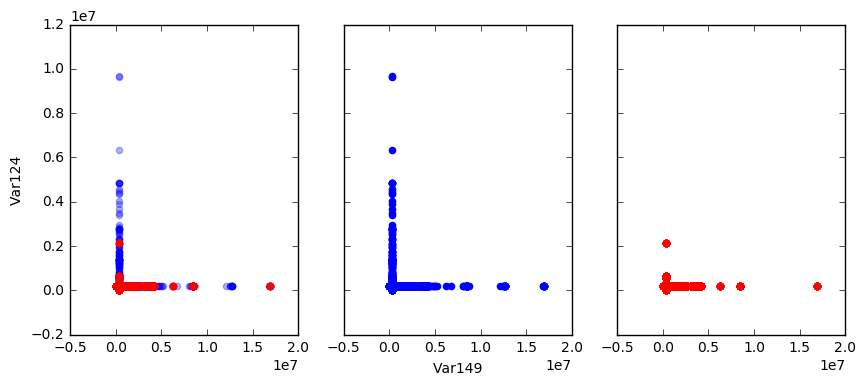

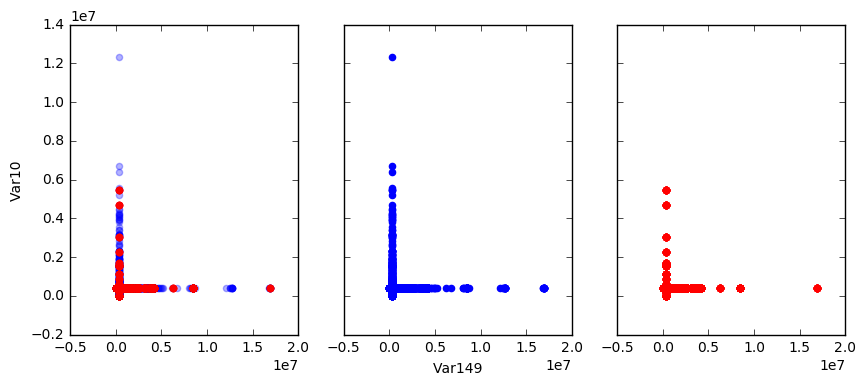

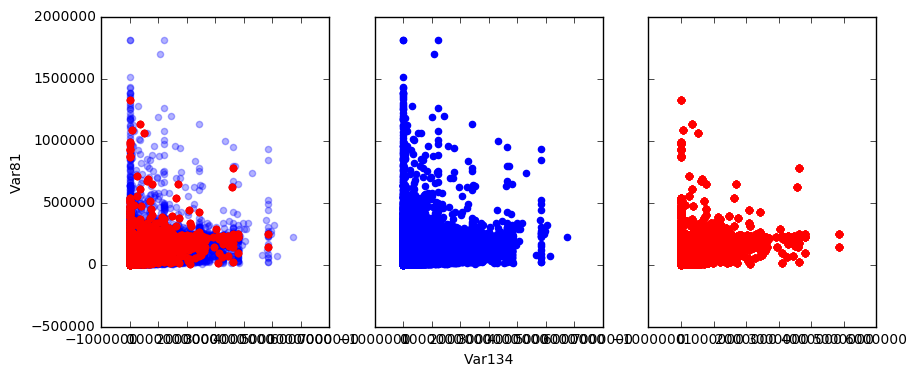

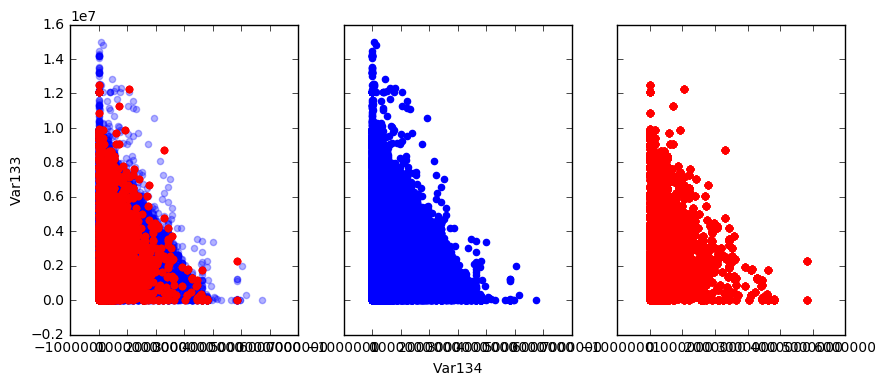

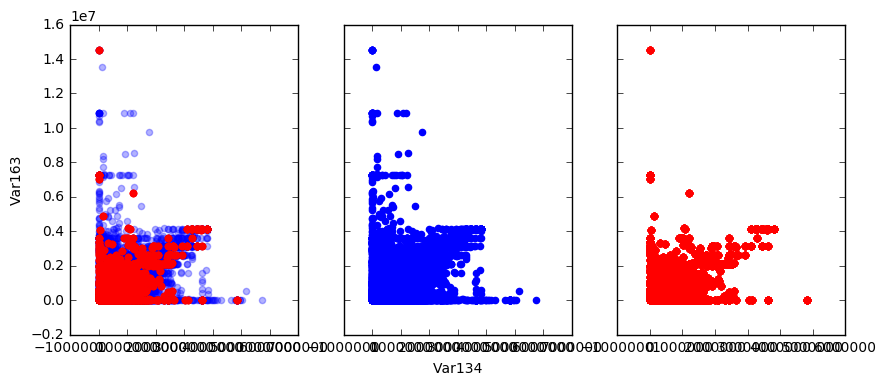

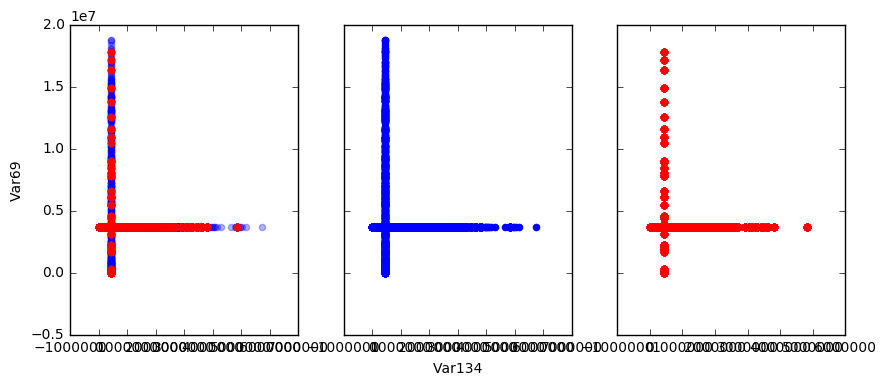

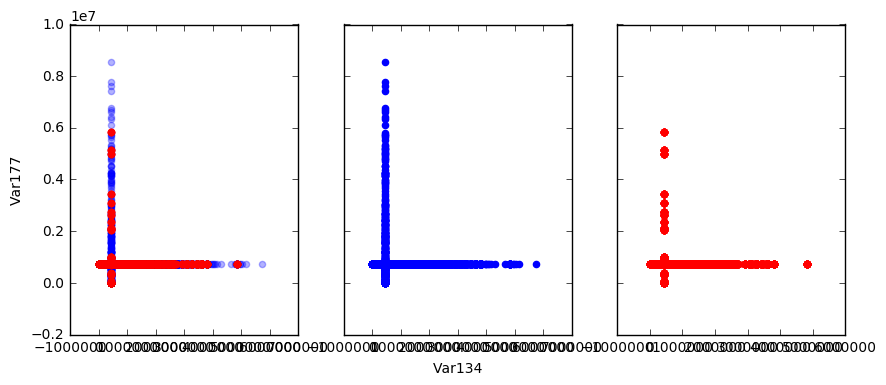

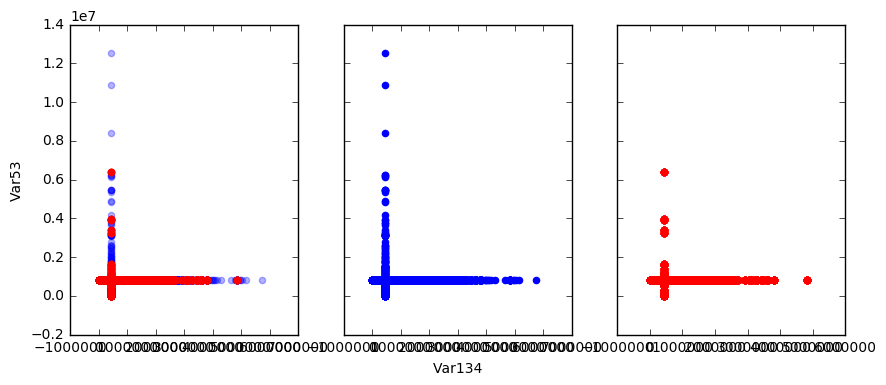

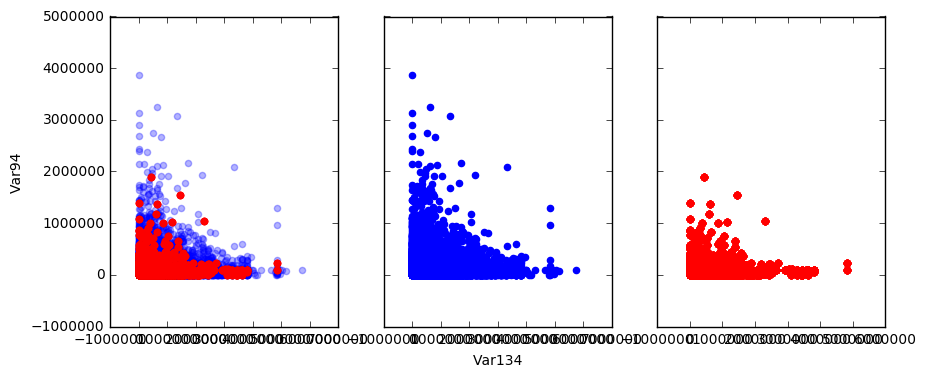

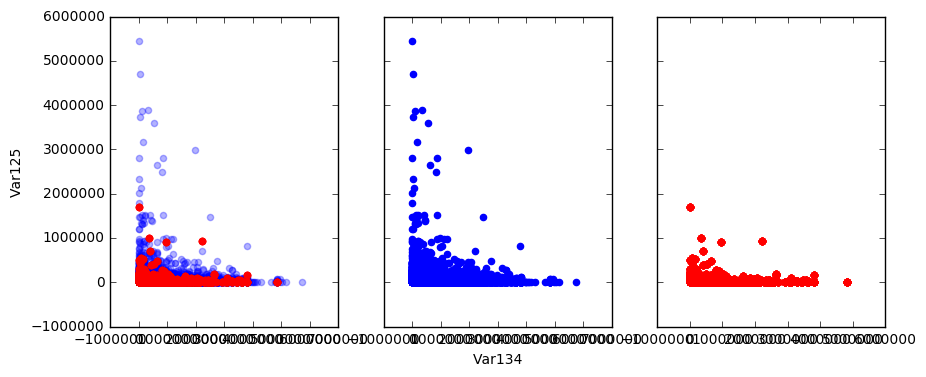

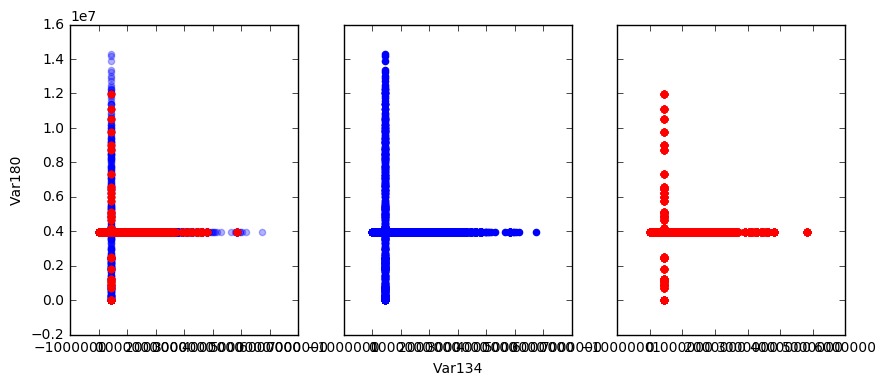

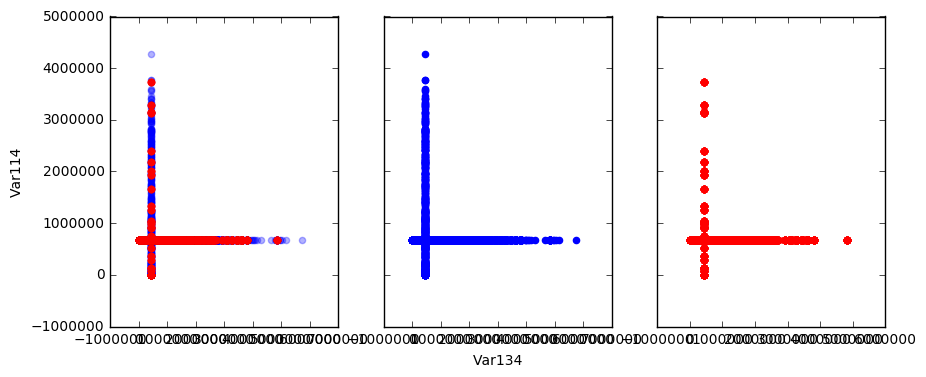

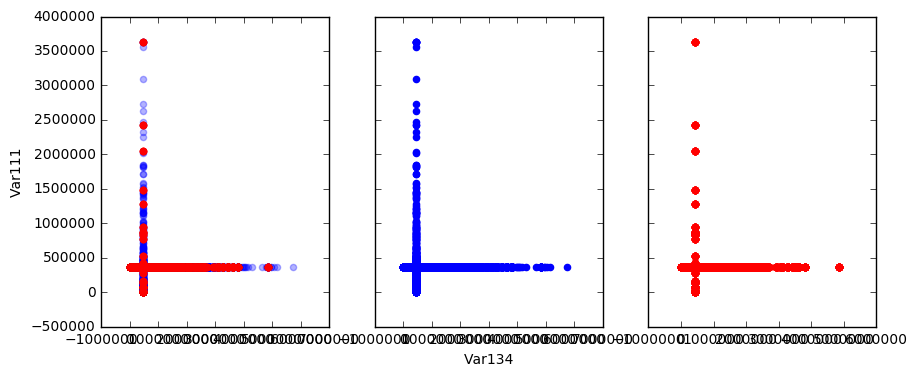

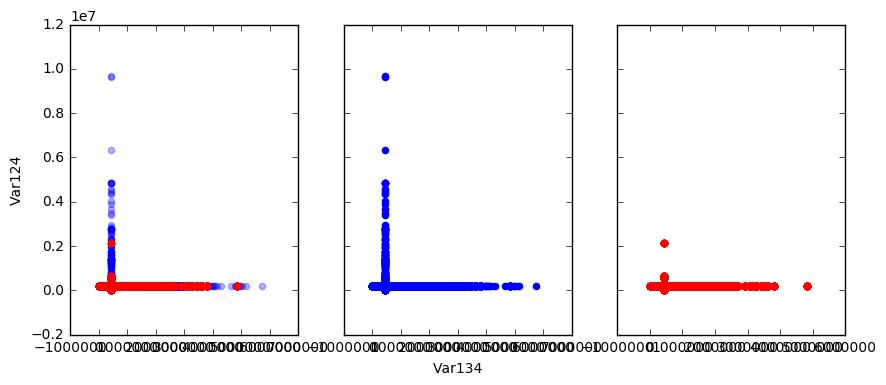

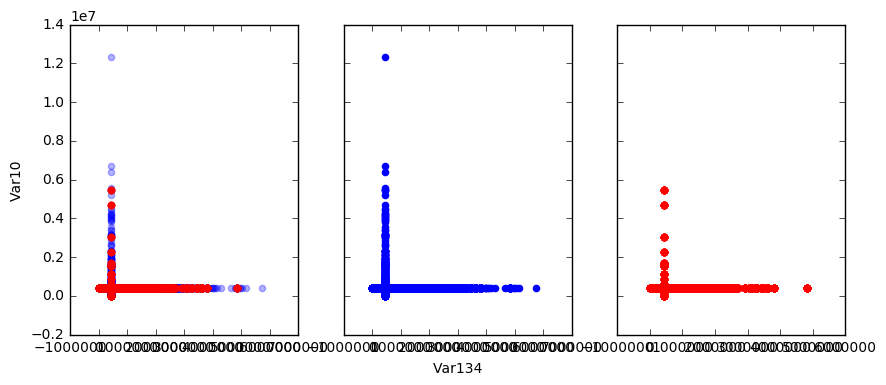

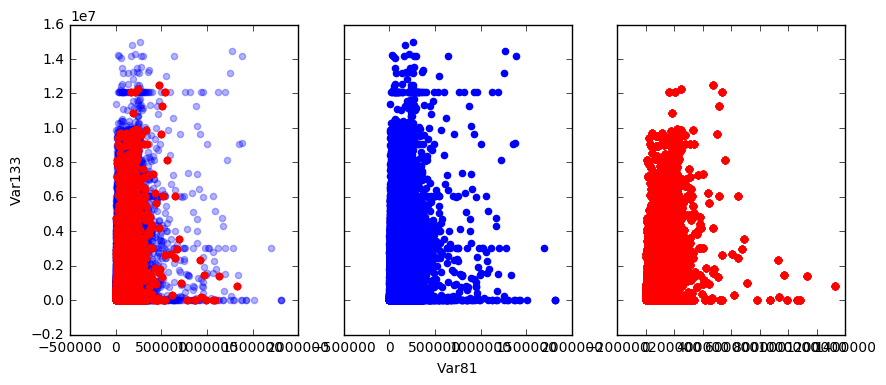

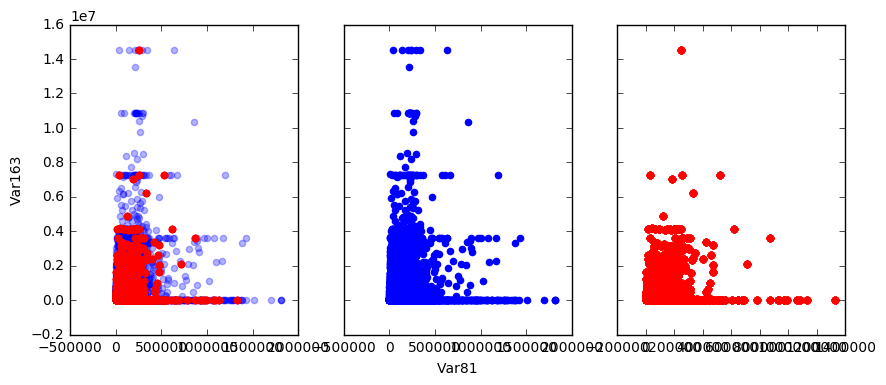

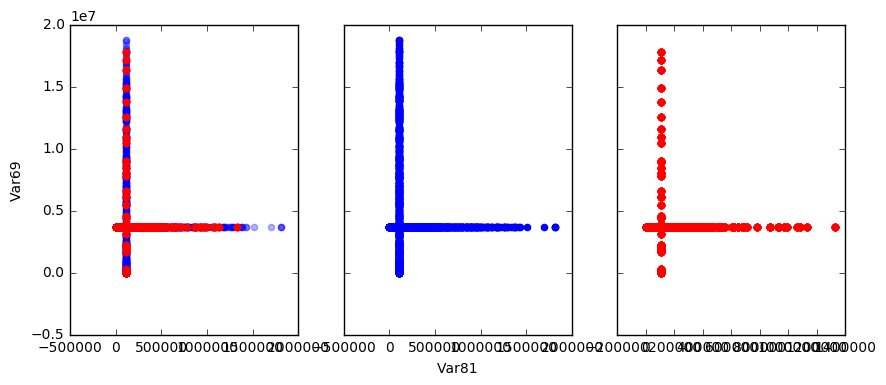

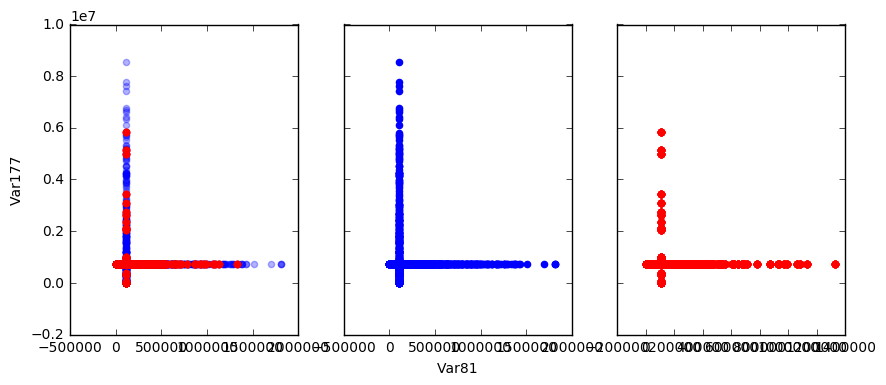

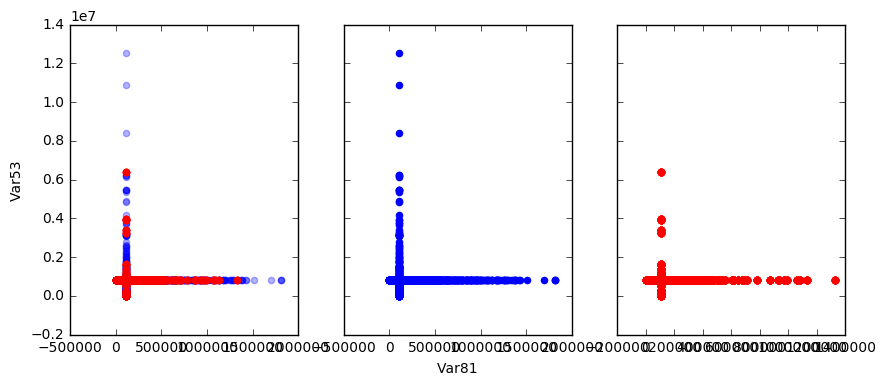

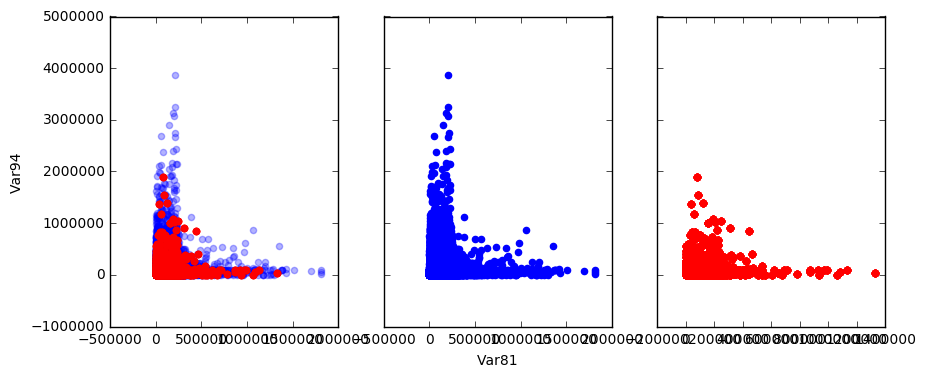

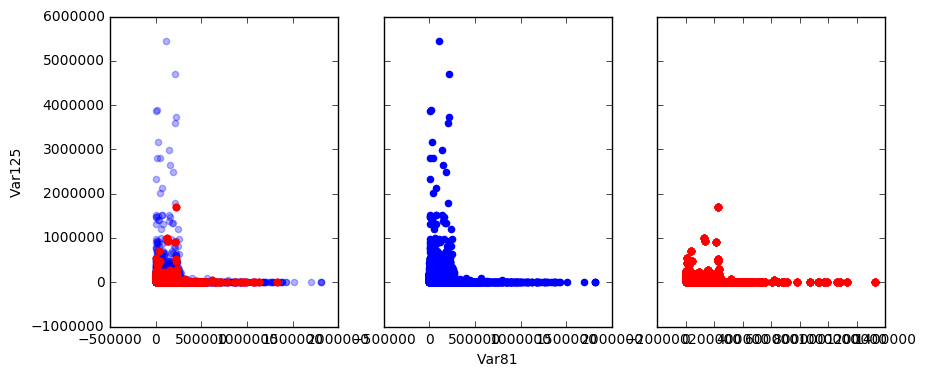

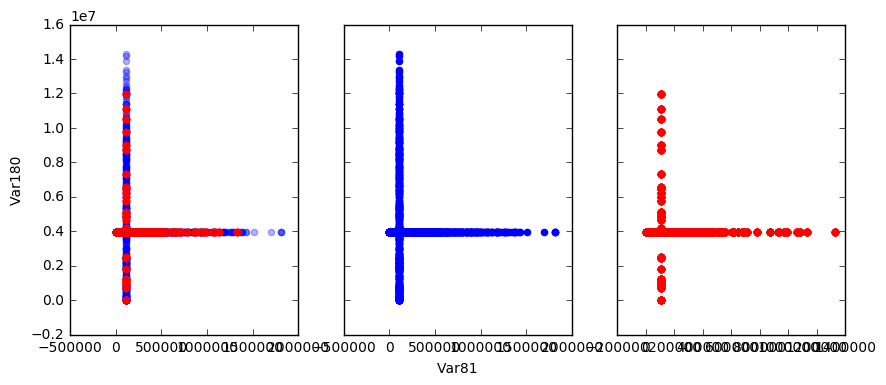

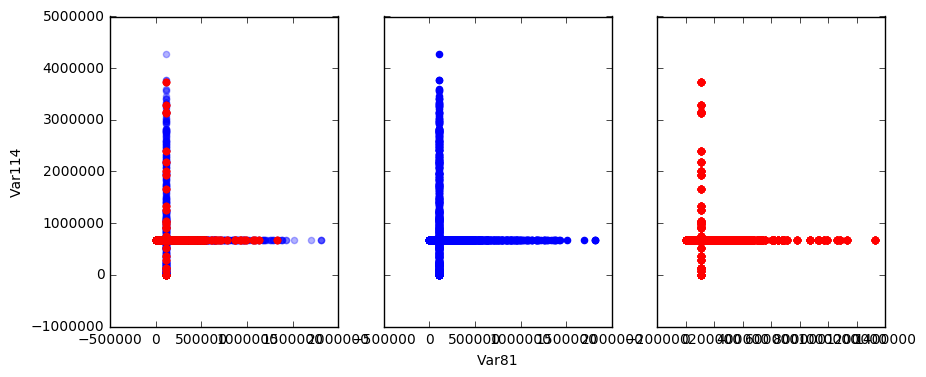

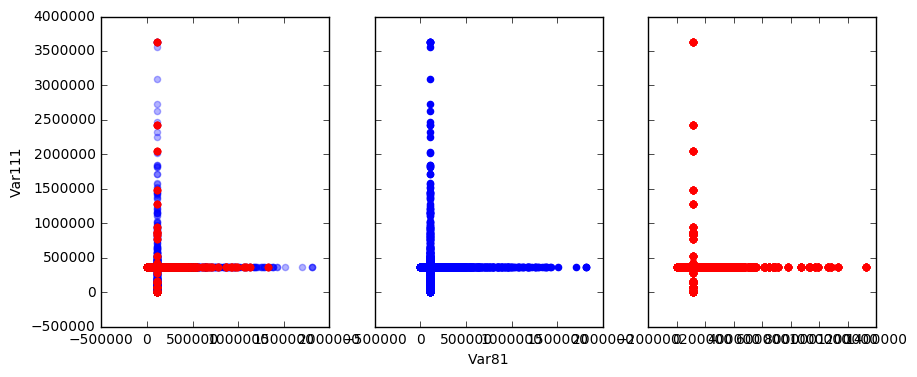

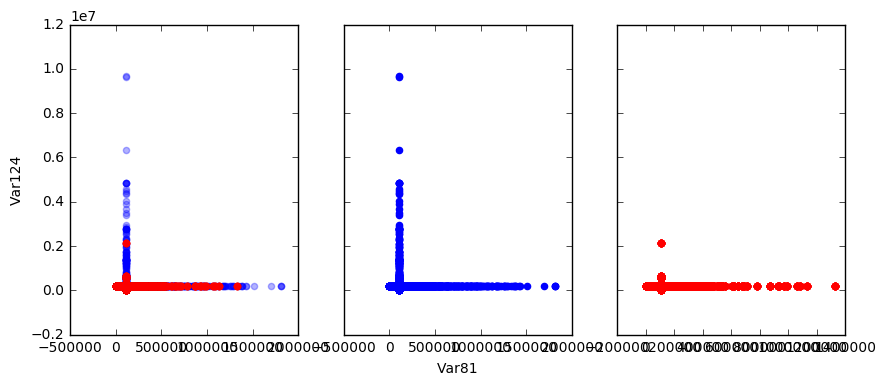

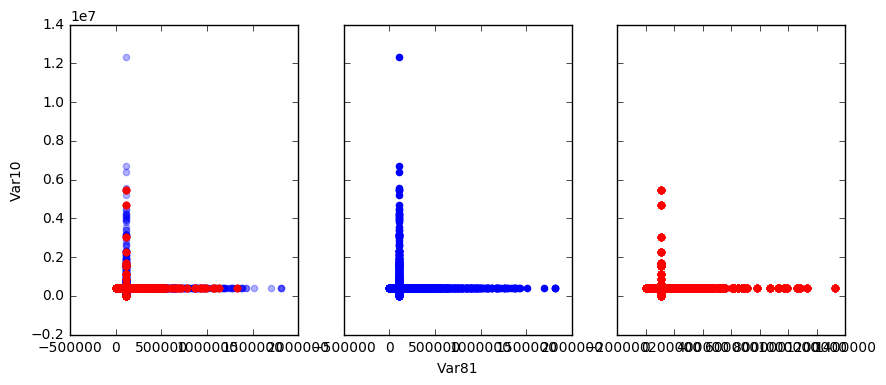

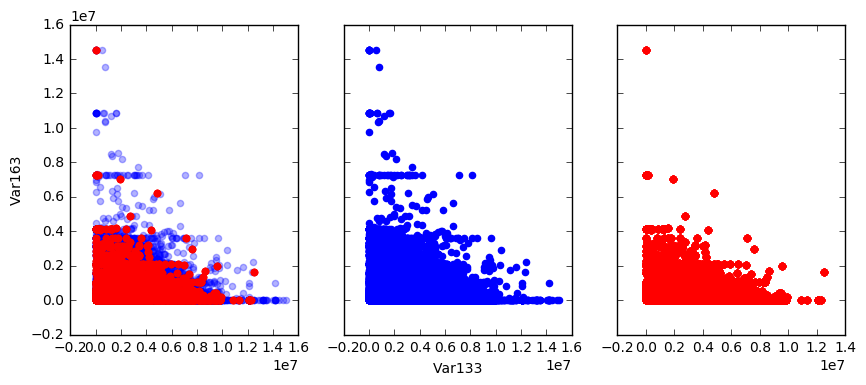

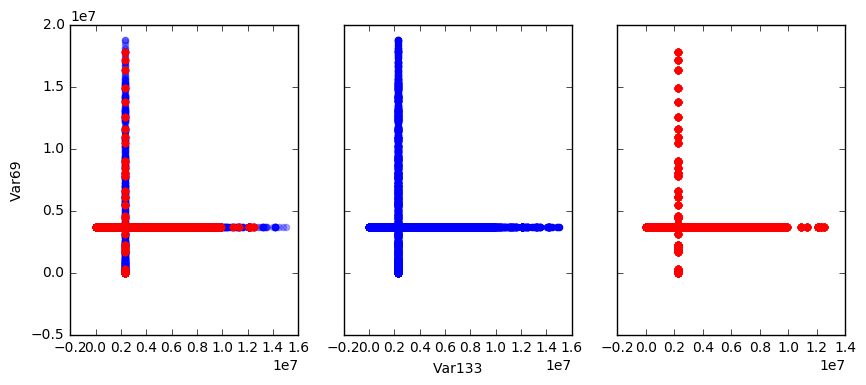

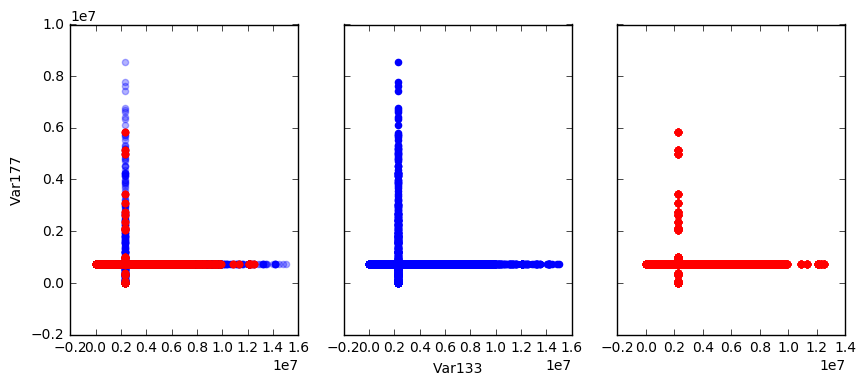

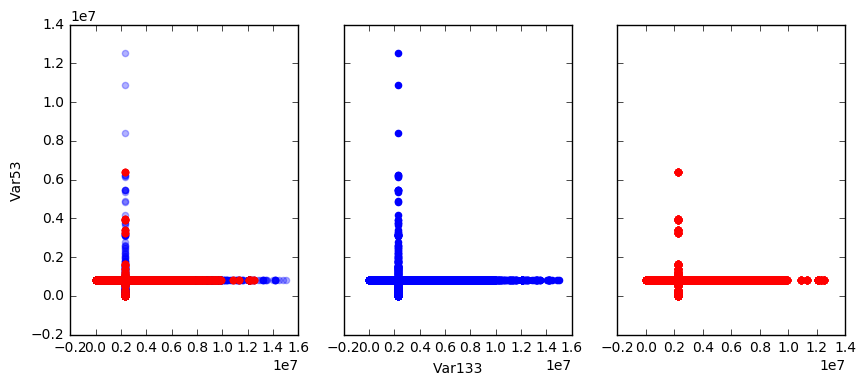

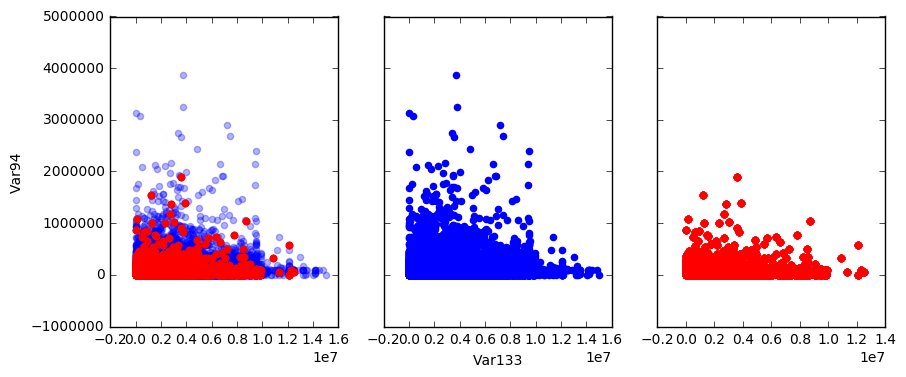

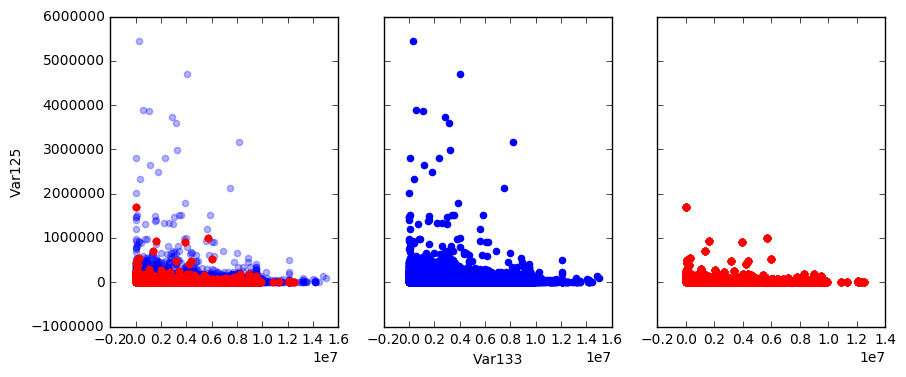

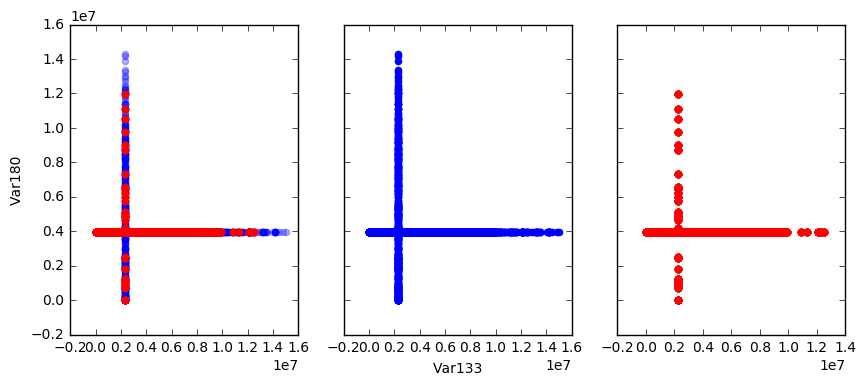

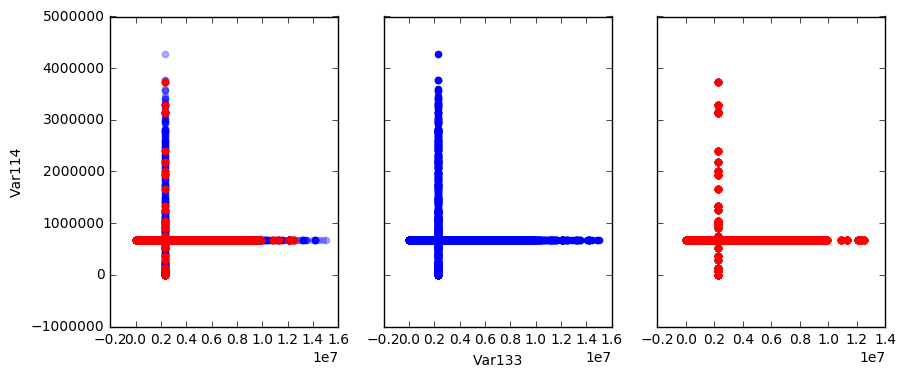

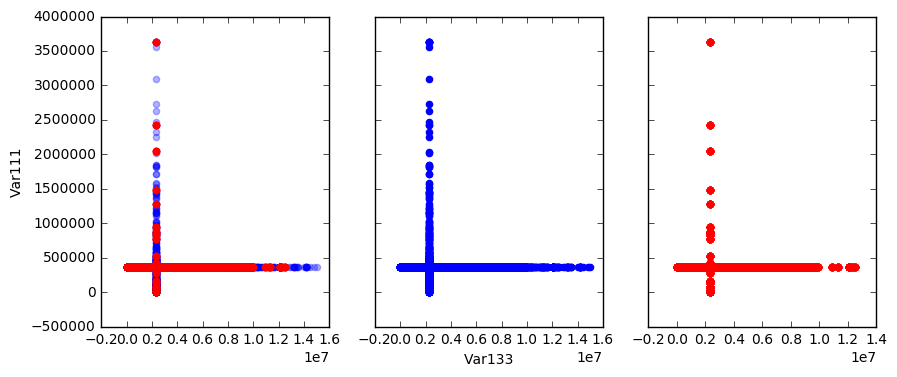

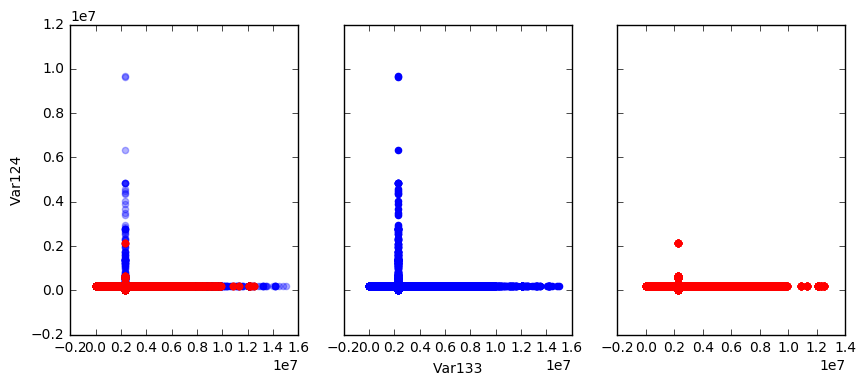

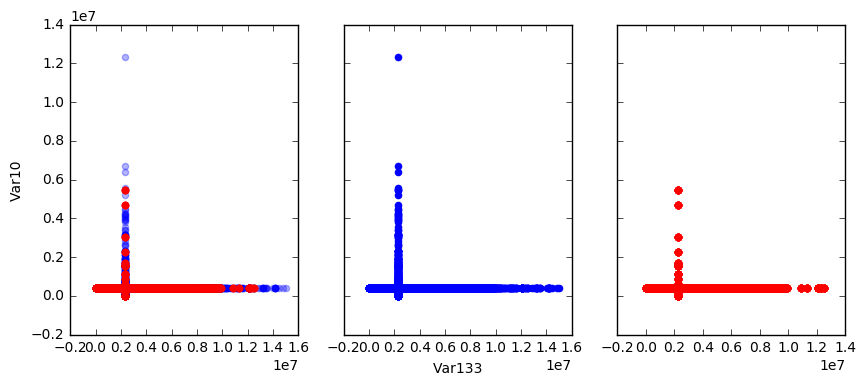

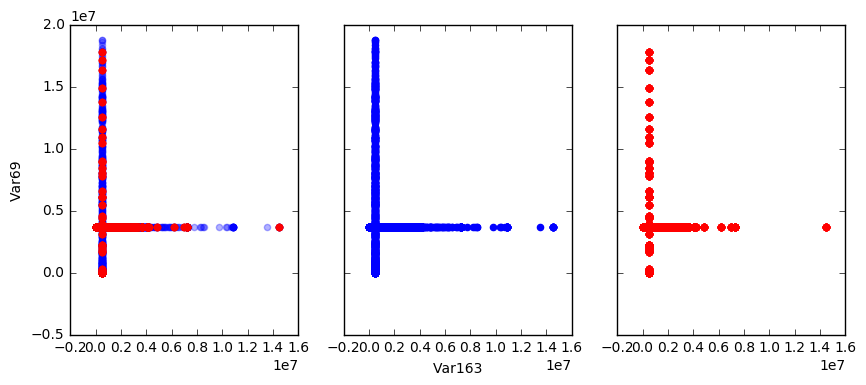

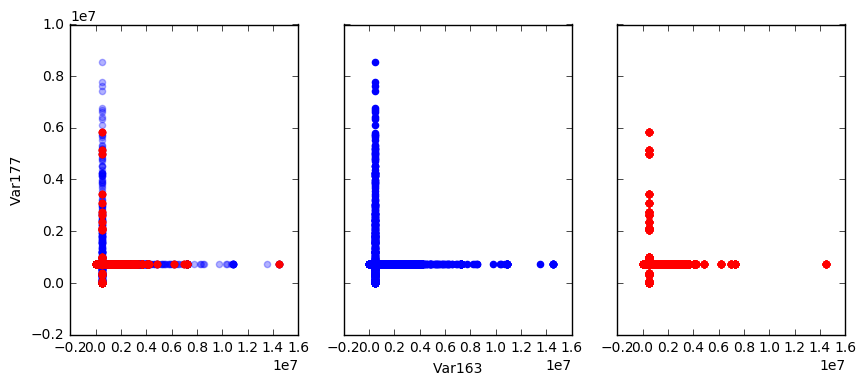

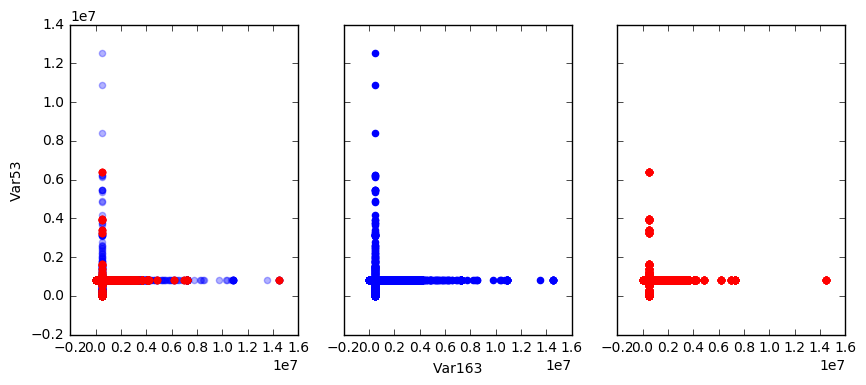

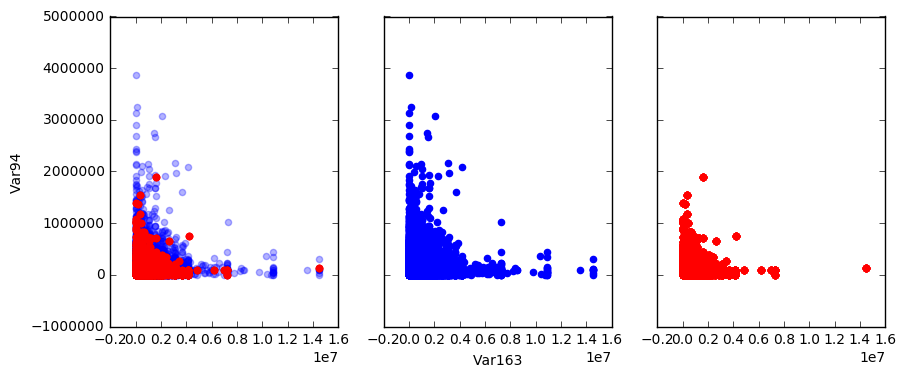

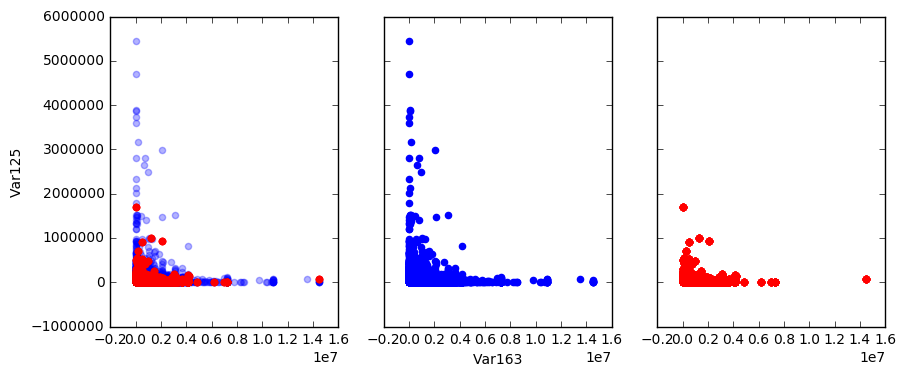

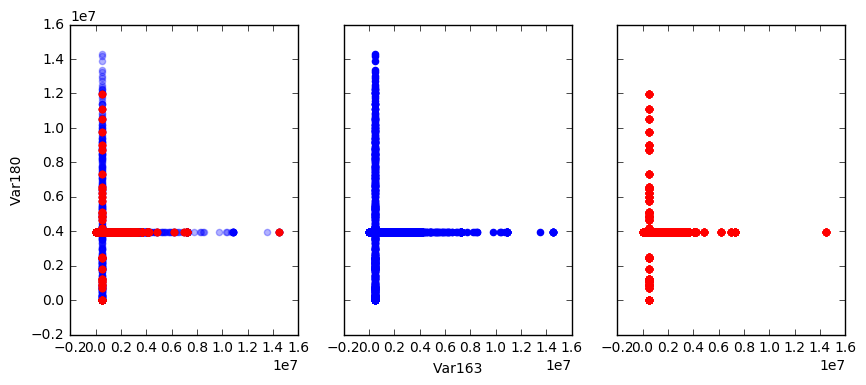

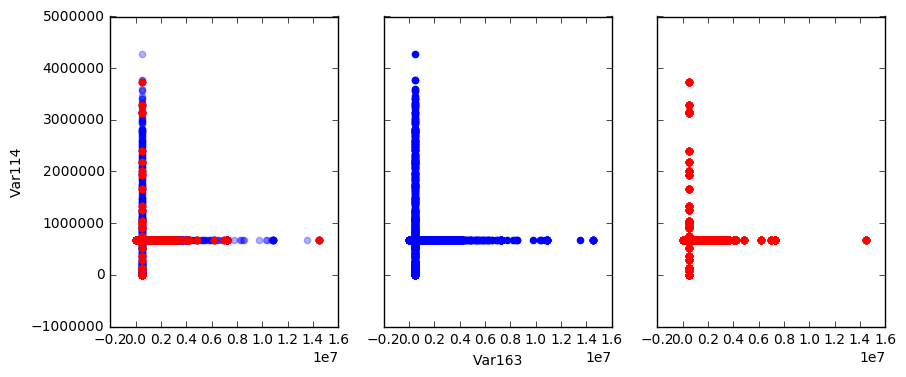

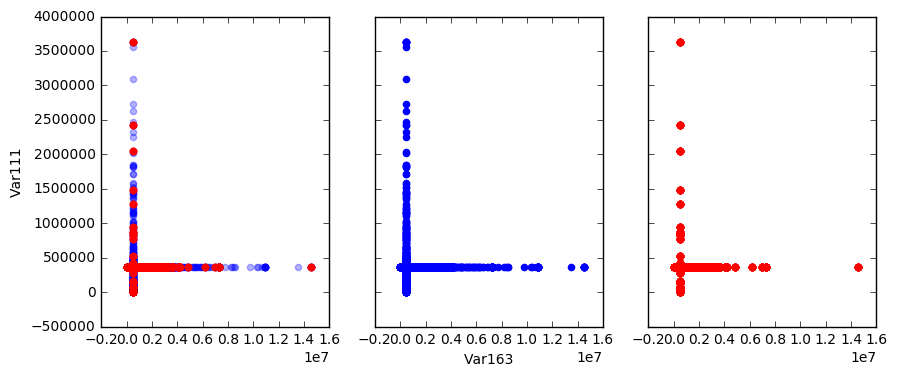

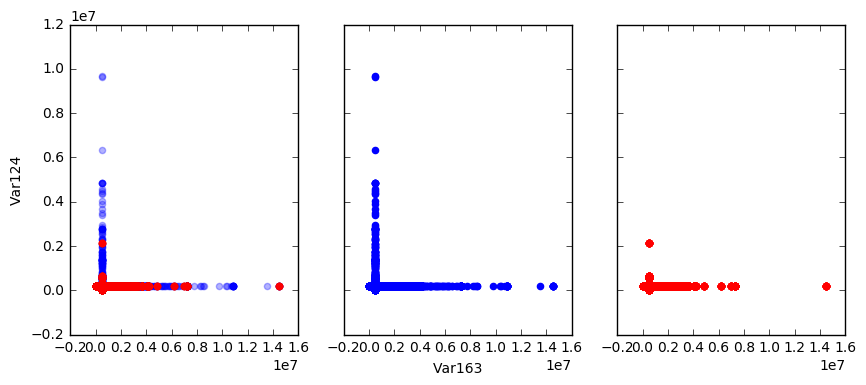

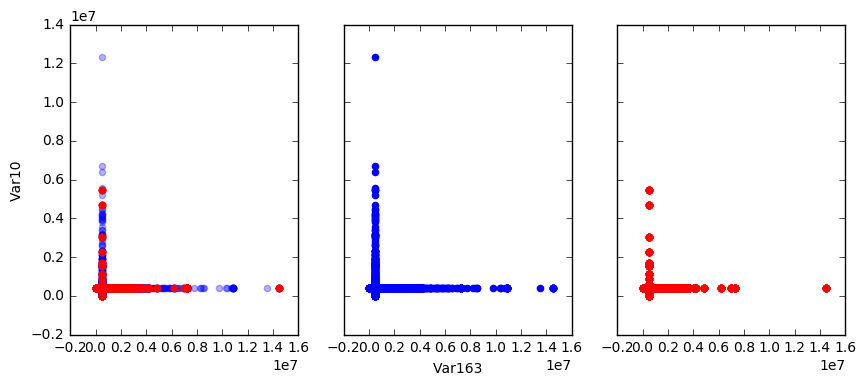

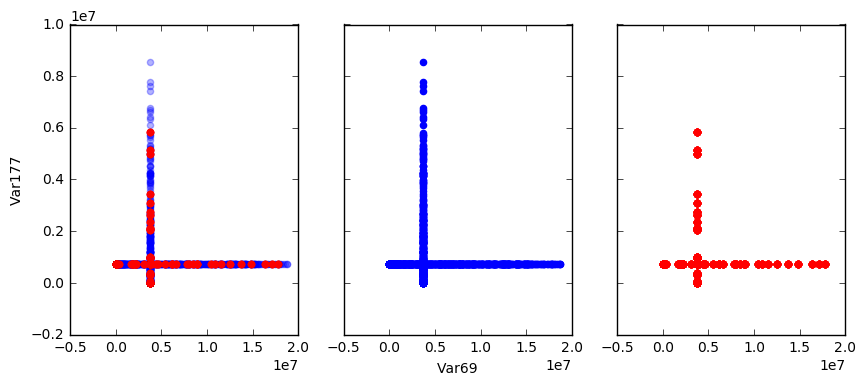

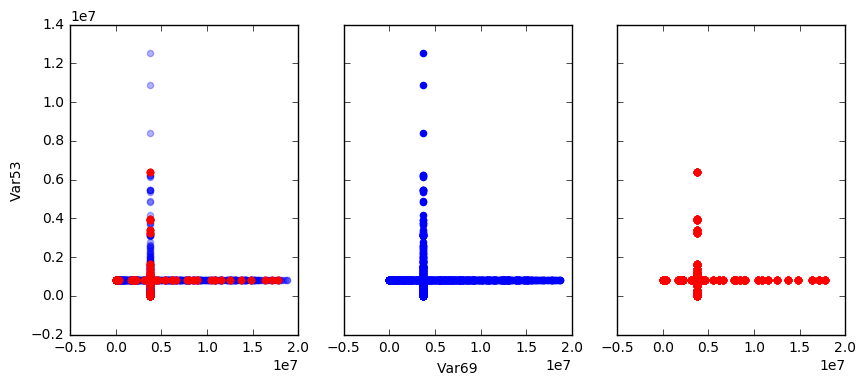

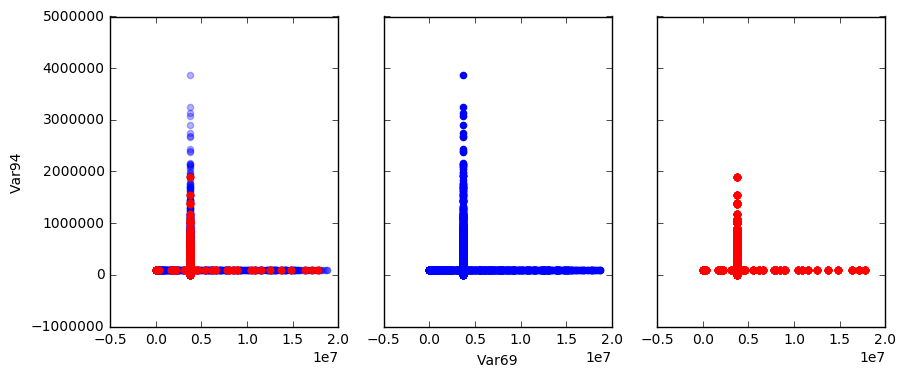

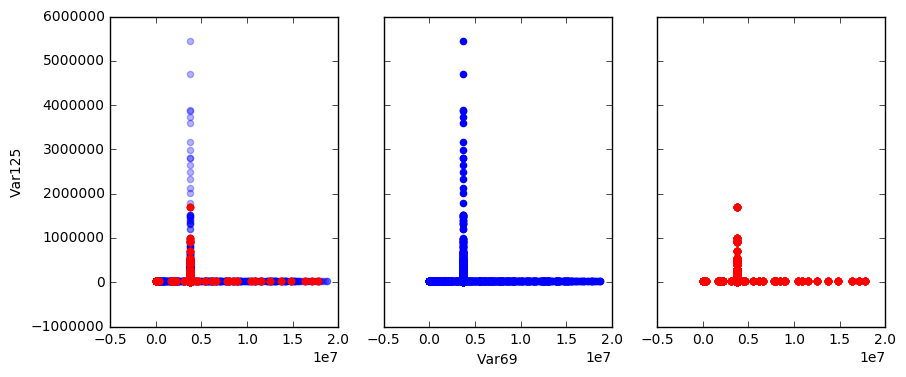

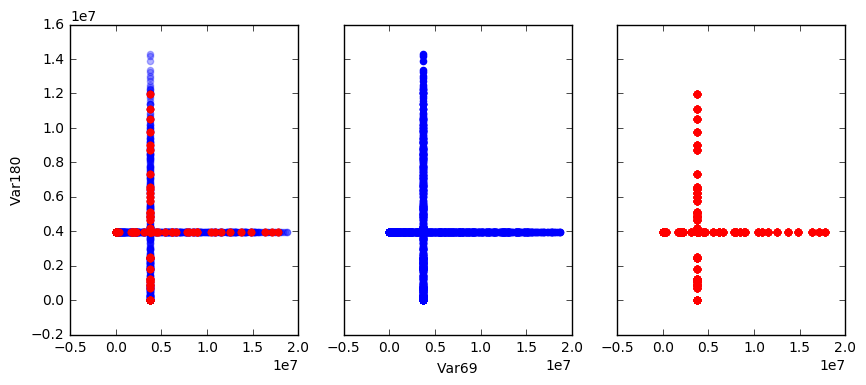

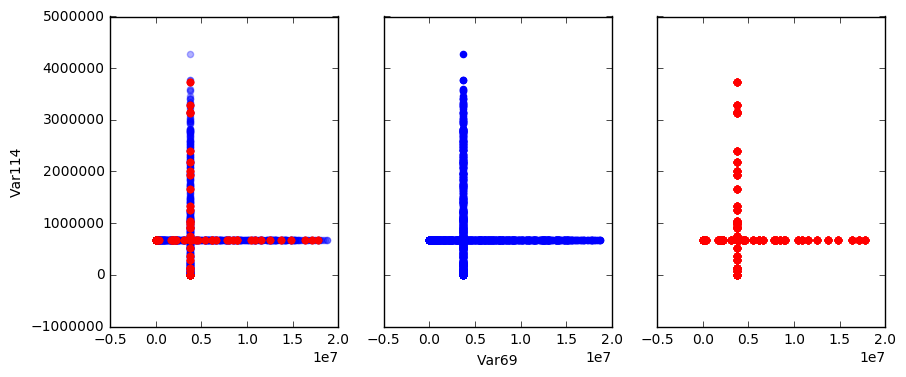

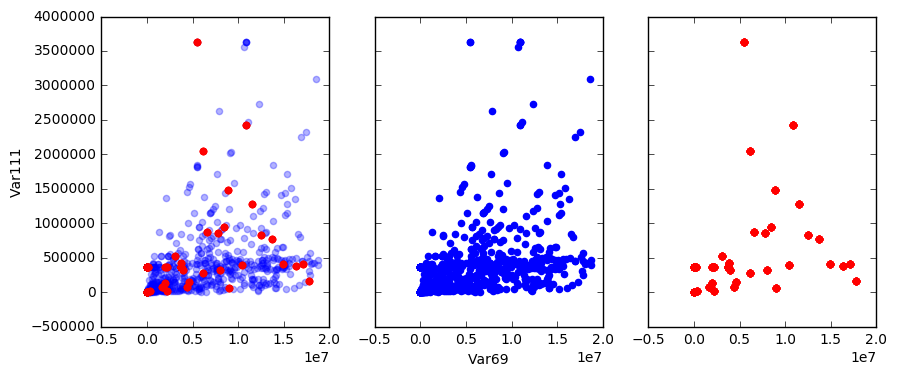

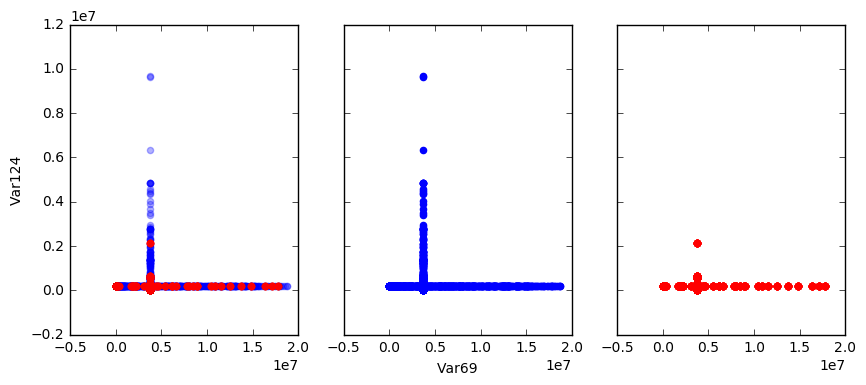

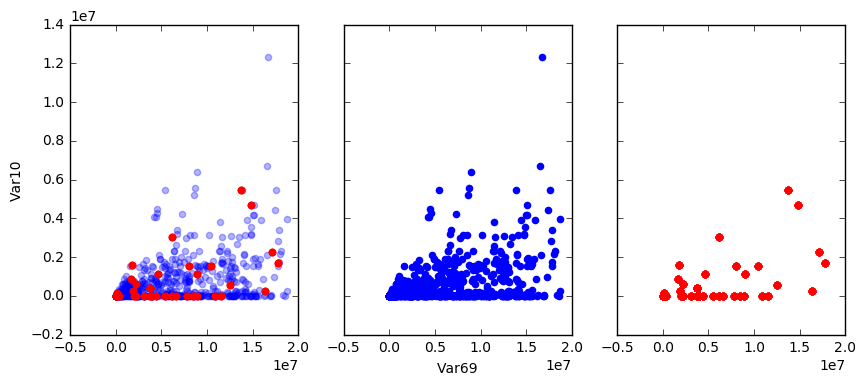

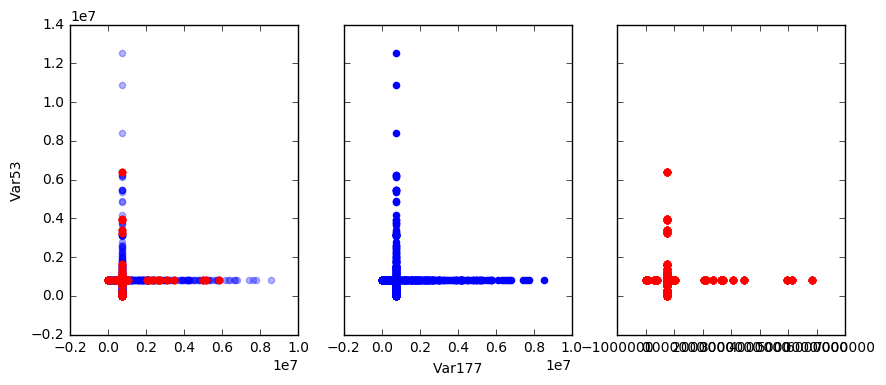

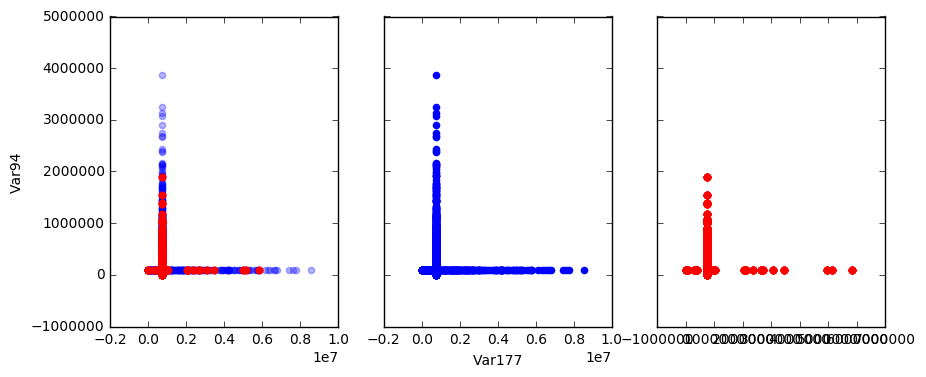

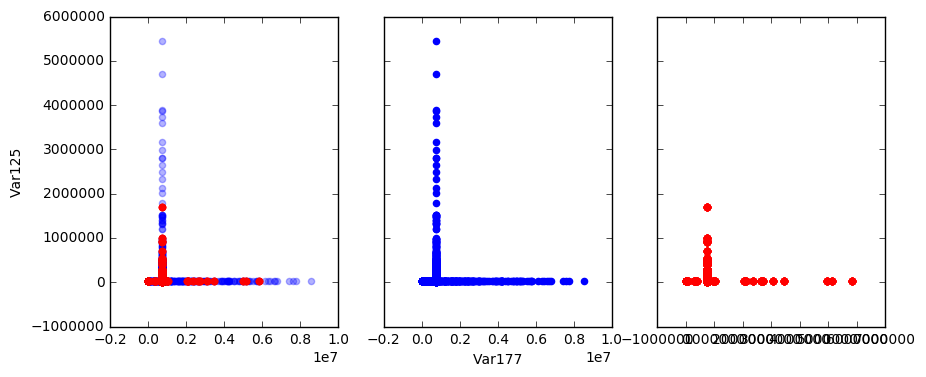

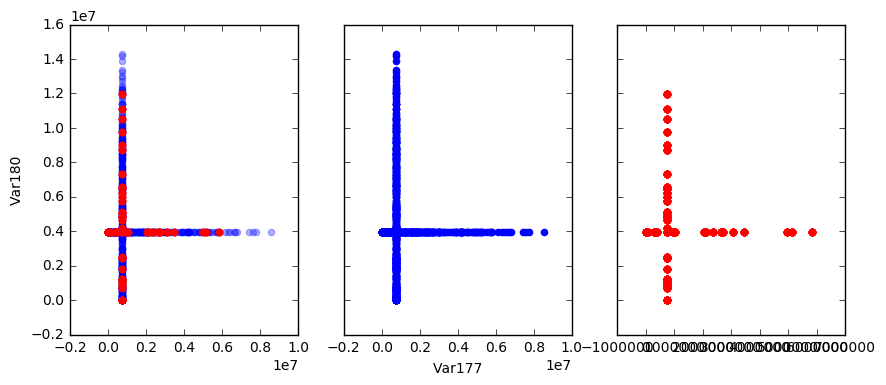

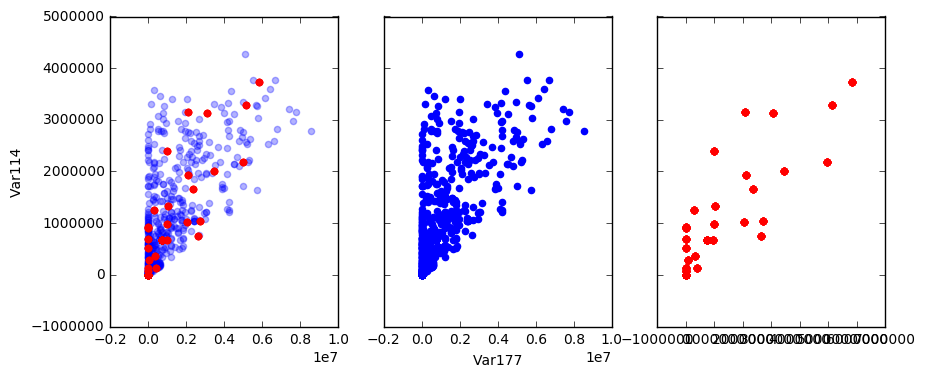

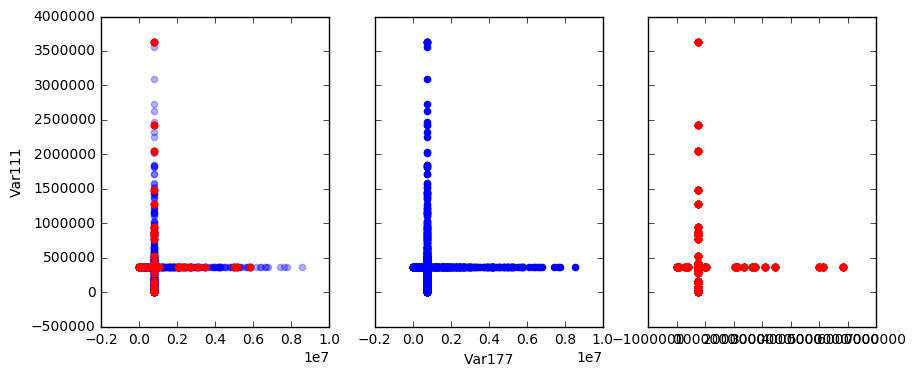

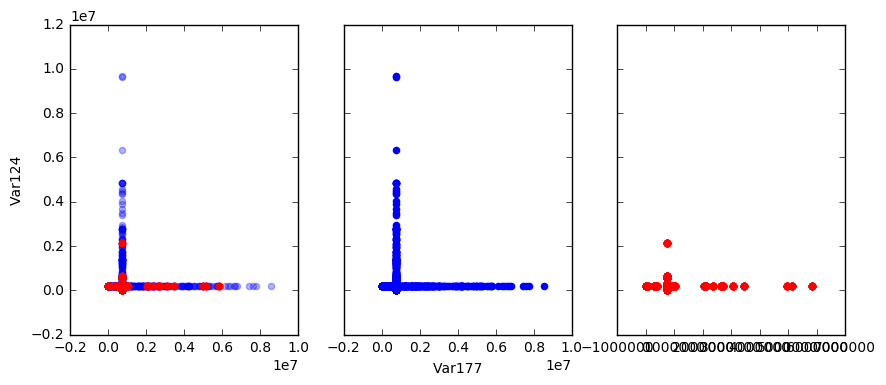

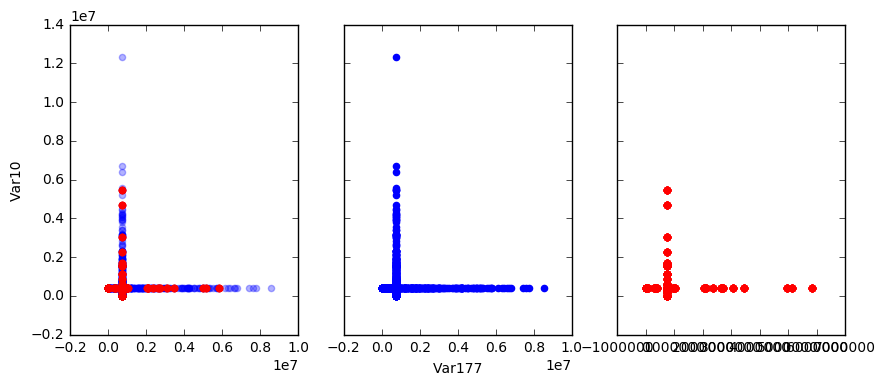

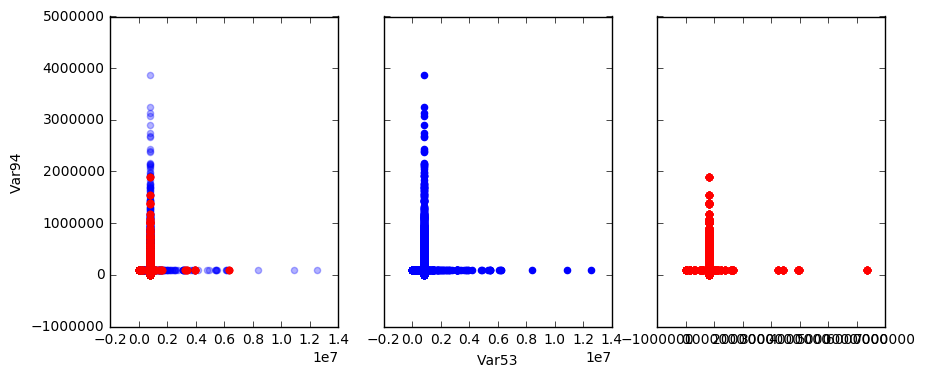

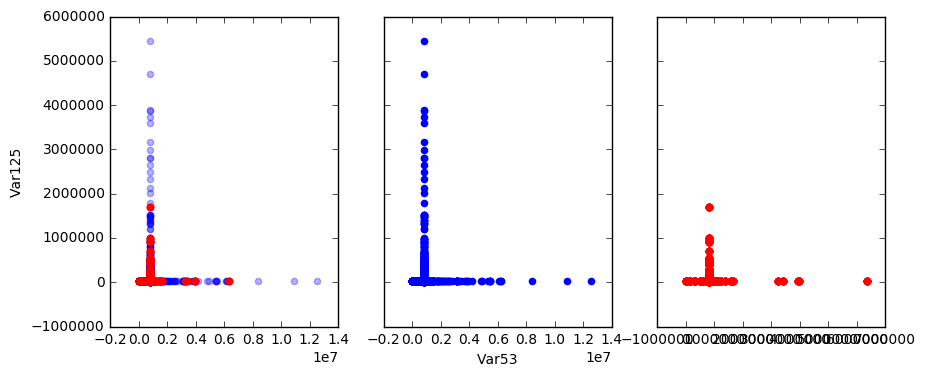

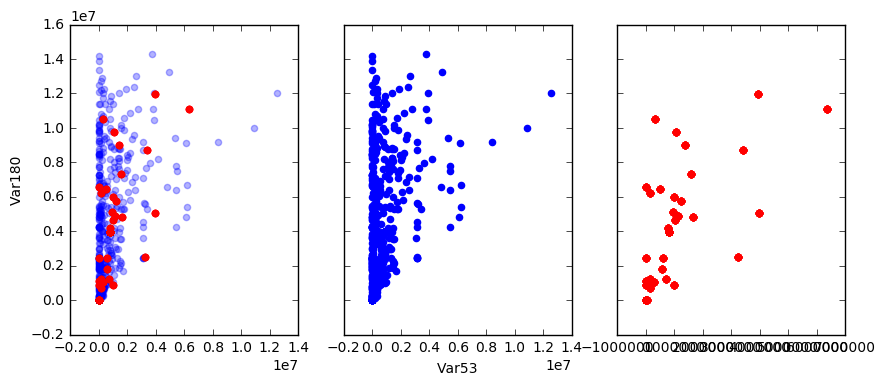

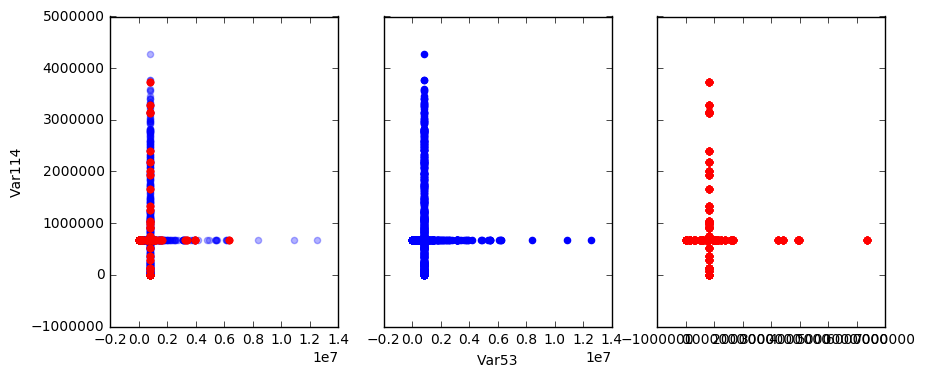

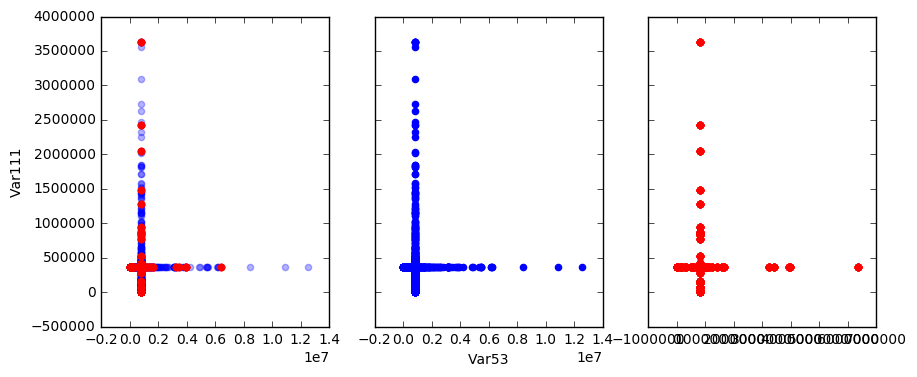

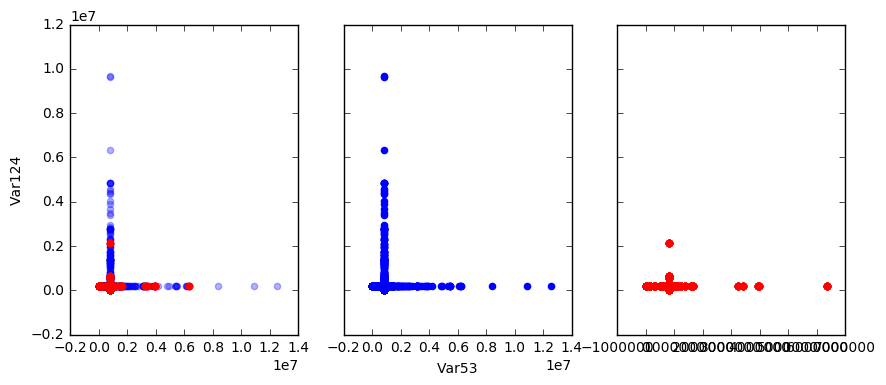

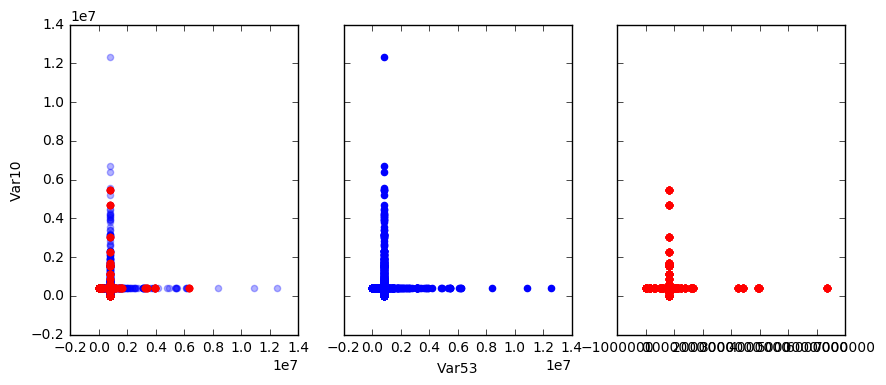

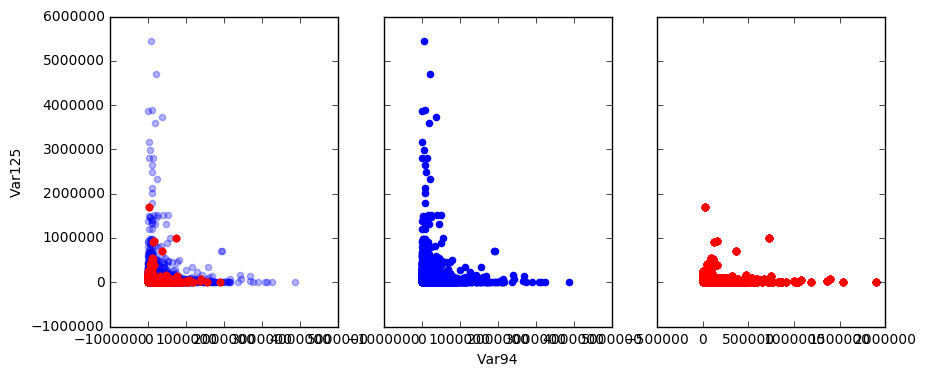

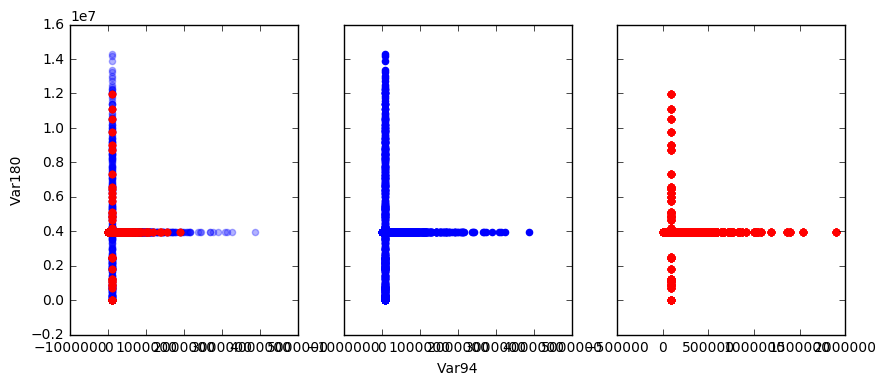

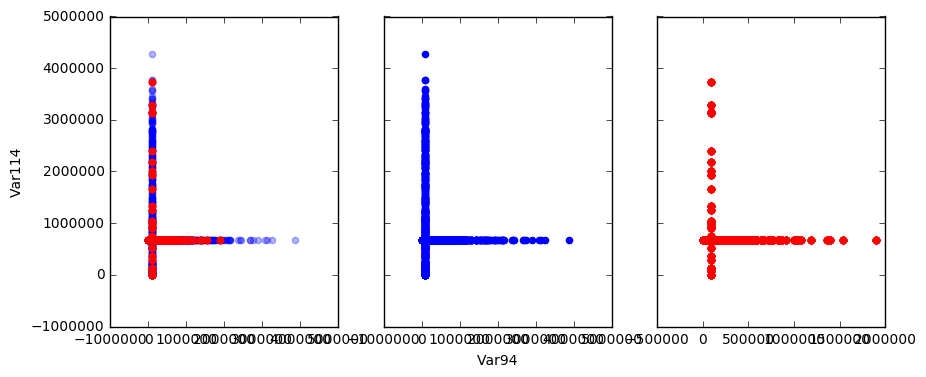

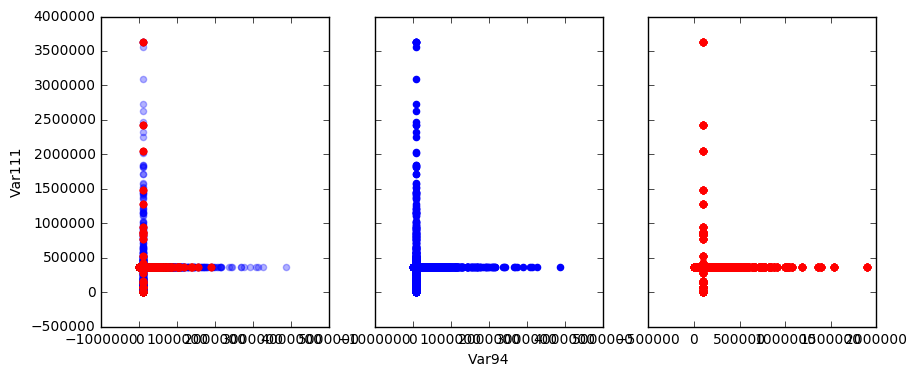

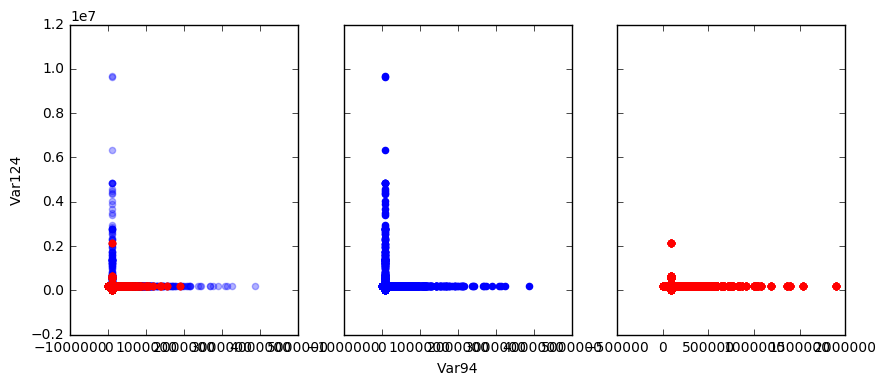

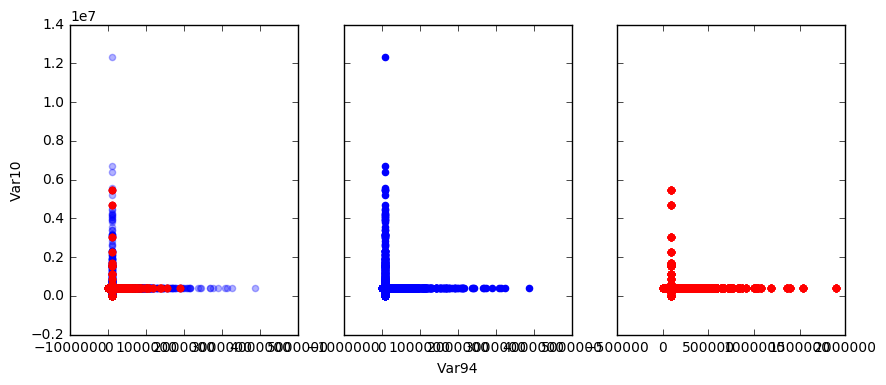

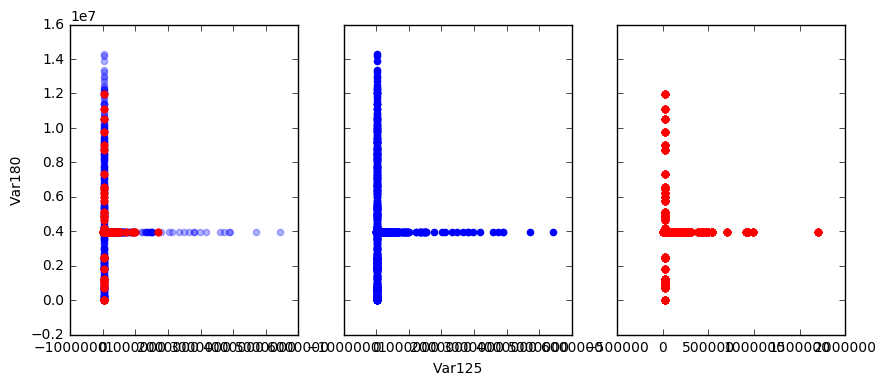

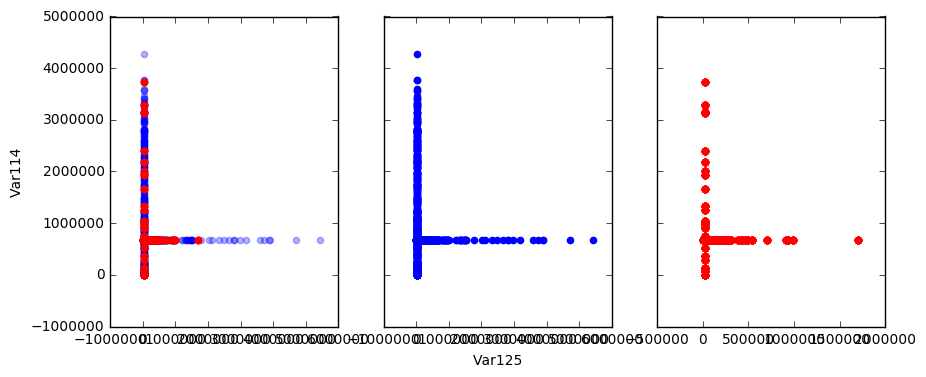

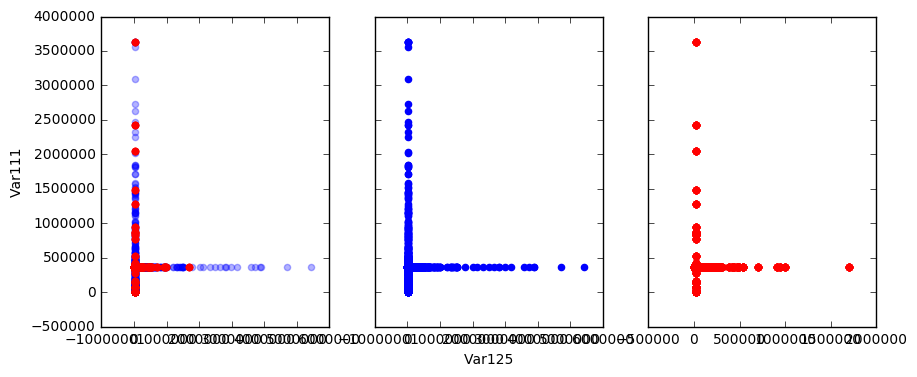

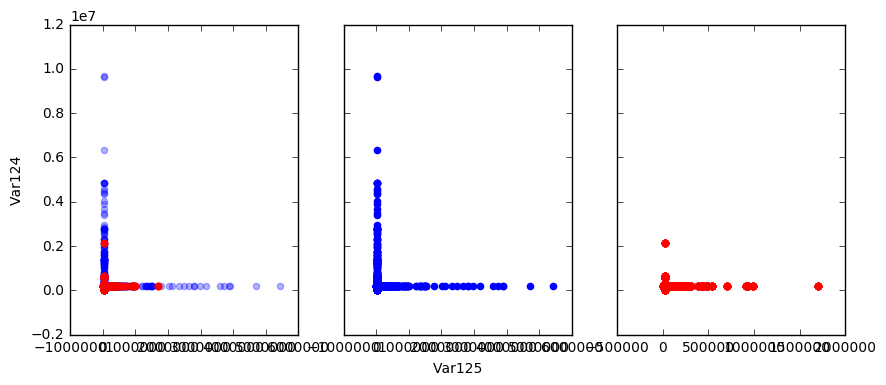

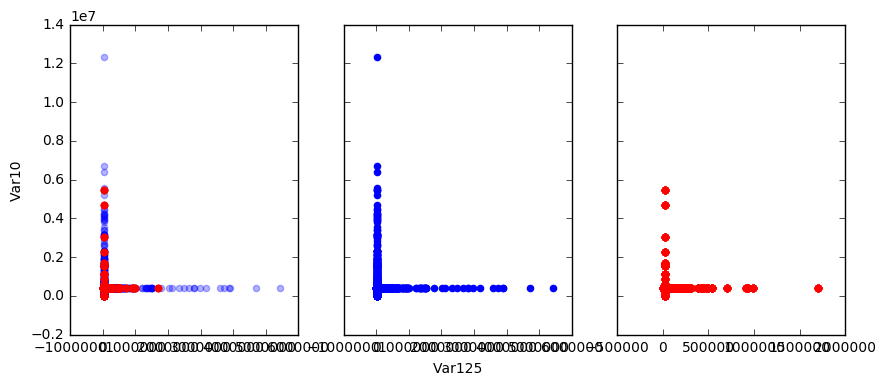

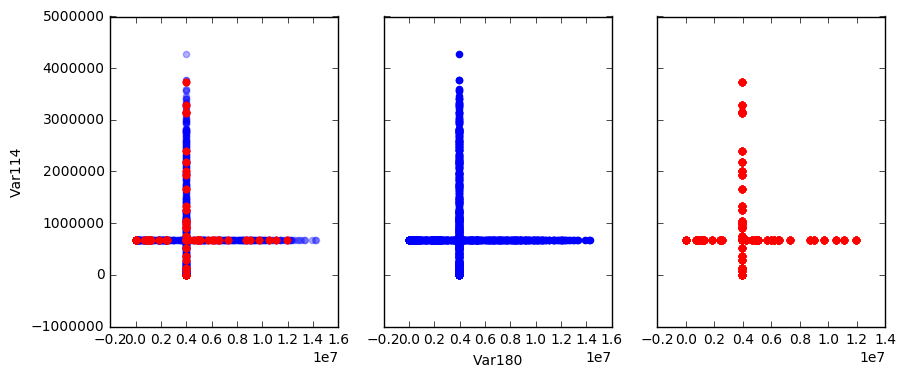

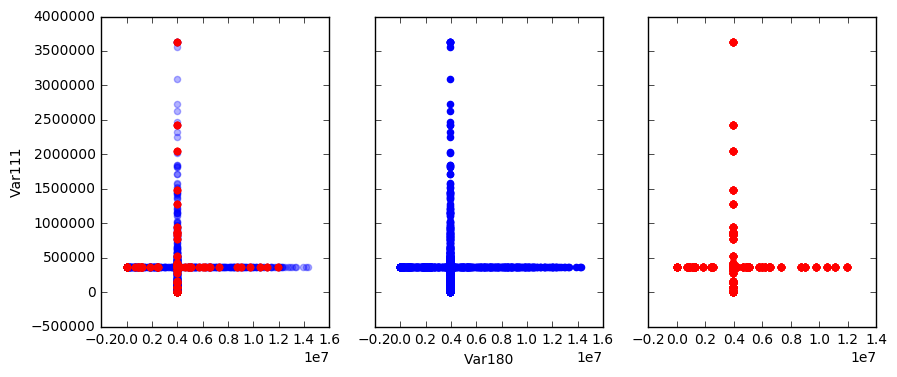

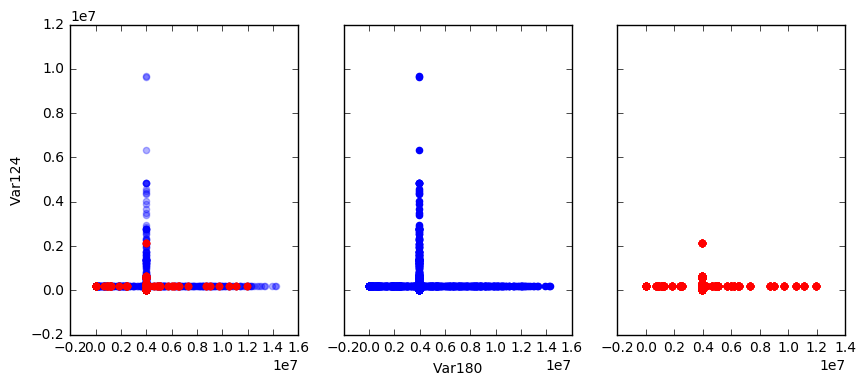

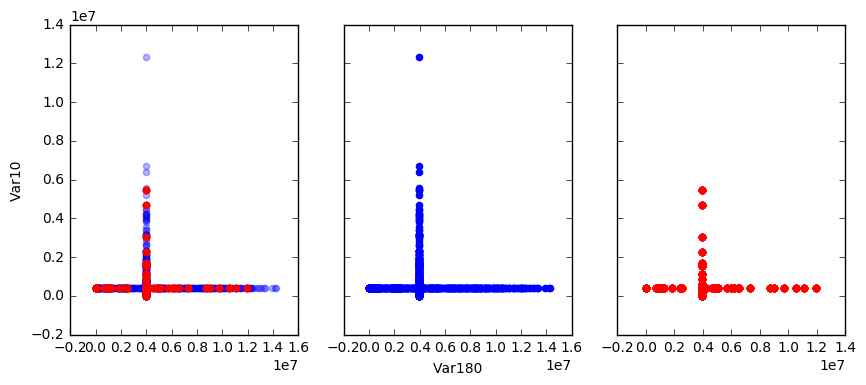

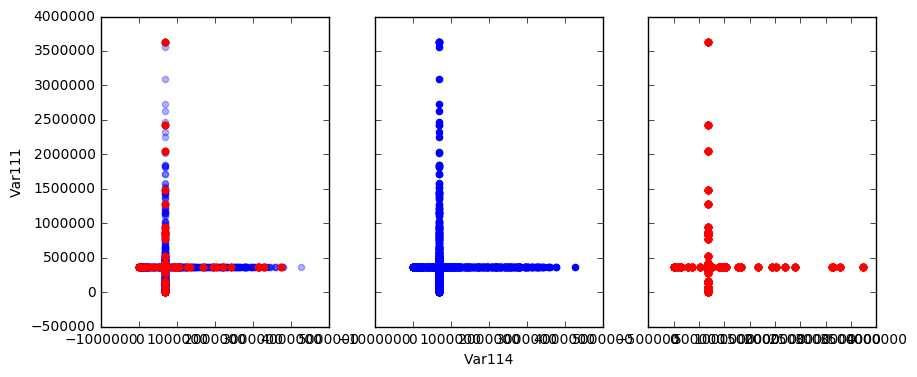

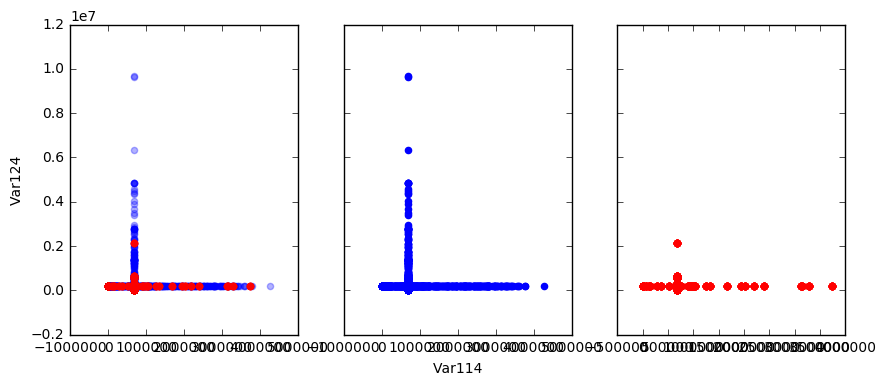

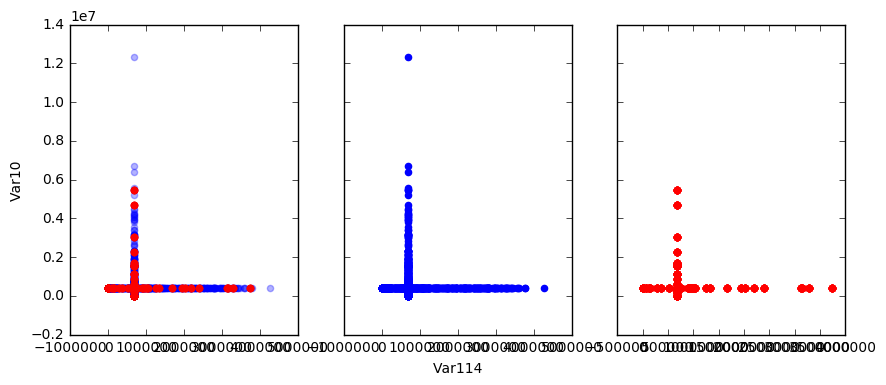

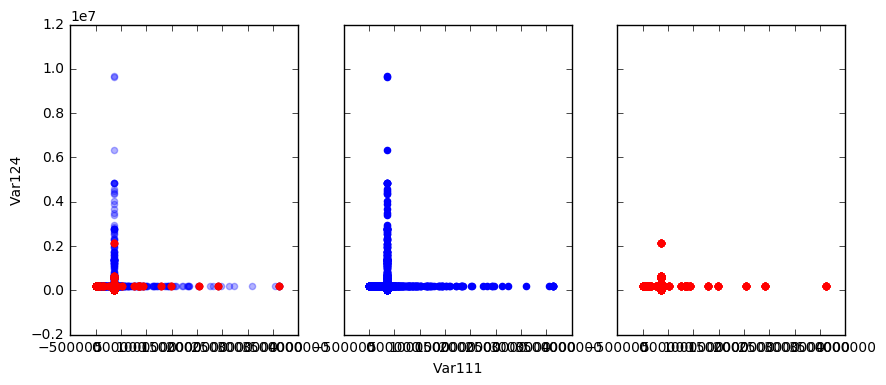

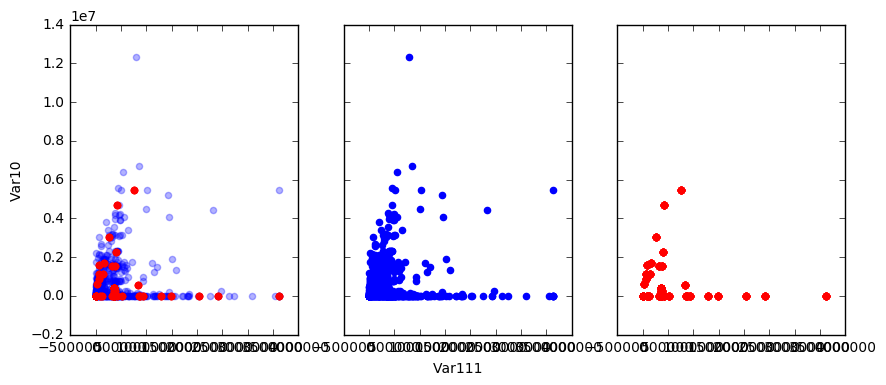

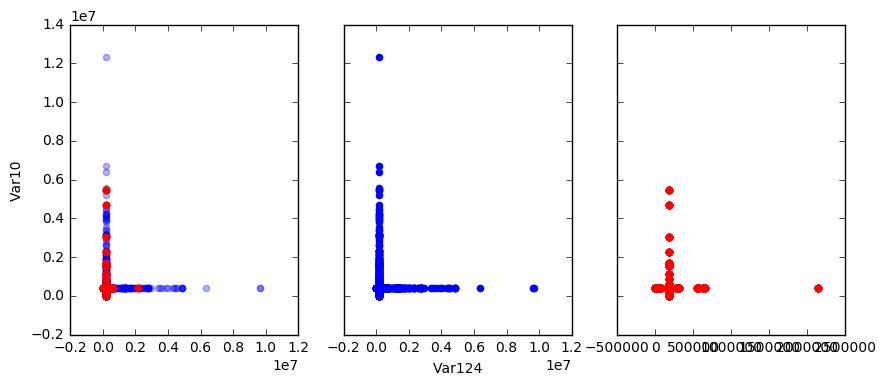

In [20]:
build_scatter_plots(
    numeric_balanced_frame,
    top_columns,
    class_descriptions)

5\. Проделайте аналогичные шаги для случайно выбранных 10 числовых признаков.

In [17]:
# Уберем из списка взаимосвязей top_columns и bottom_columns, т.к. мы их рассмотрим в заданиях 4 и 6
middle_interrelations = interrelations.drop(labels=top_balanced_columns, axis=0)
middle_interrelations = middle_interrelations.drop(labels=bottom_balanced_columns, axis=0)
# Сгенерируем случайный список из 10 индексов числовых признаков и выберем их
random_indices = random.sample(range(middle_interrelations.index.shape[0]), 10)
random_columns = middle_interrelations[random_indices].index

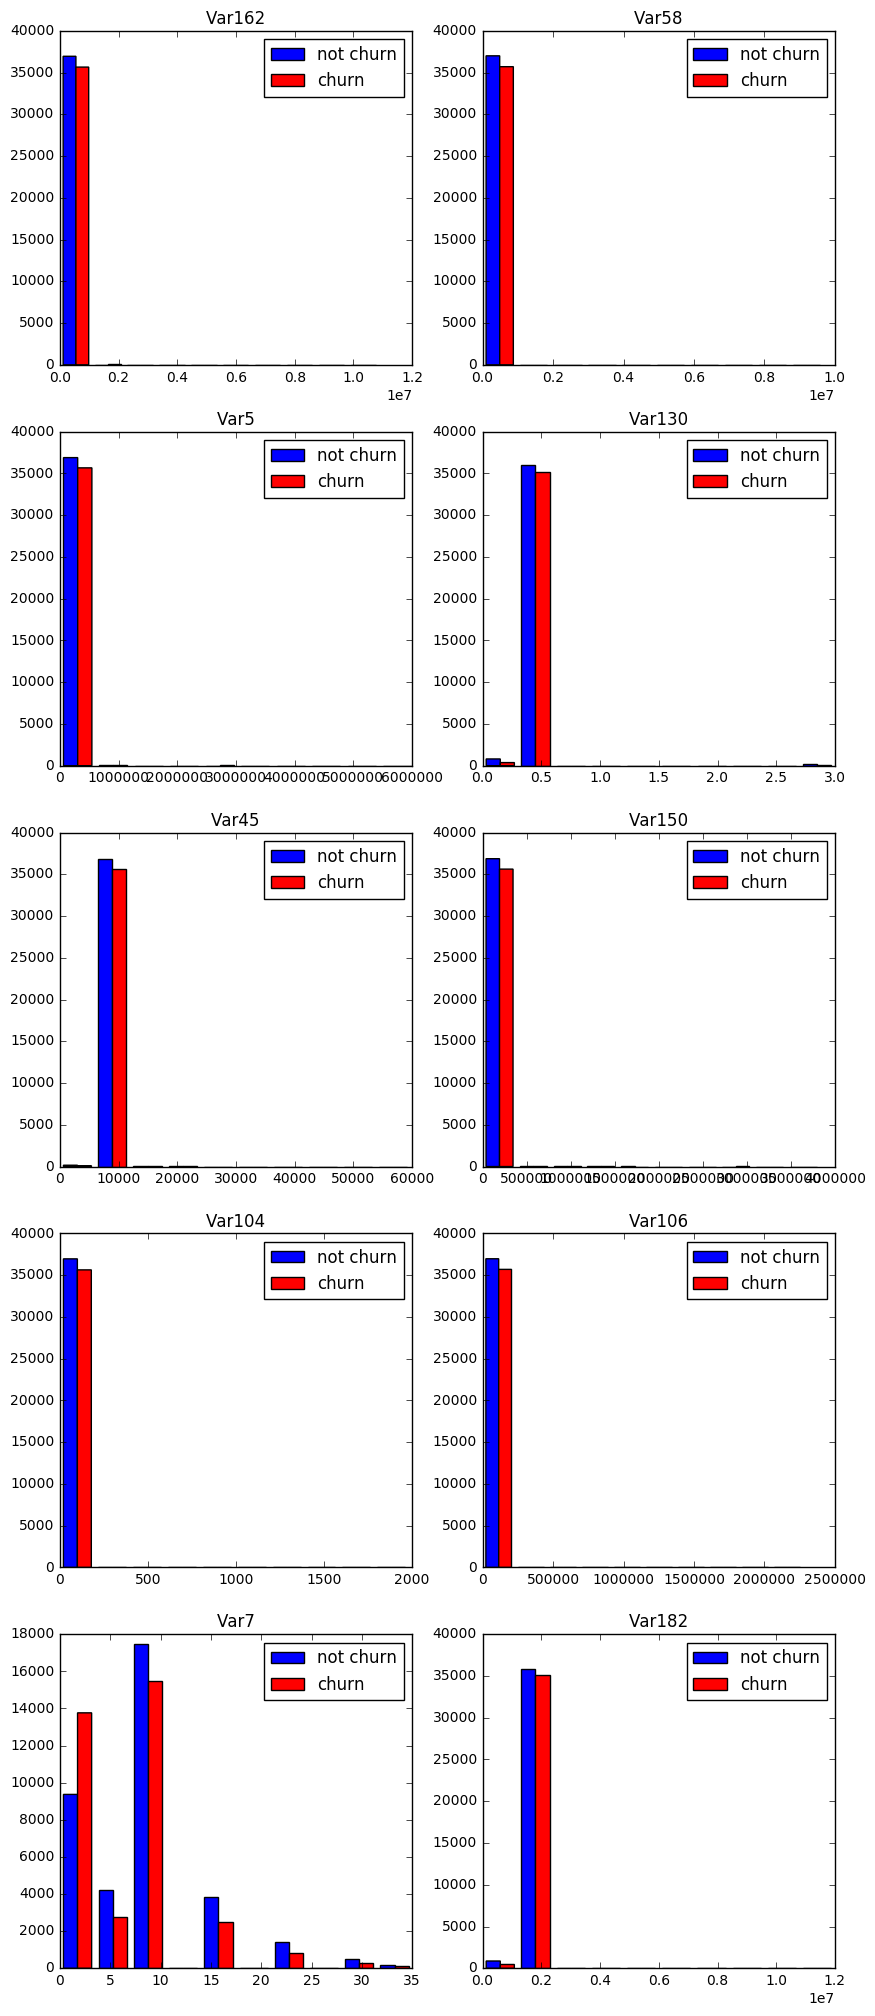

In [18]:
# Построим распределения
build_distribution_plots(numeric_balanced_frame, random_columns, class_descriptions)

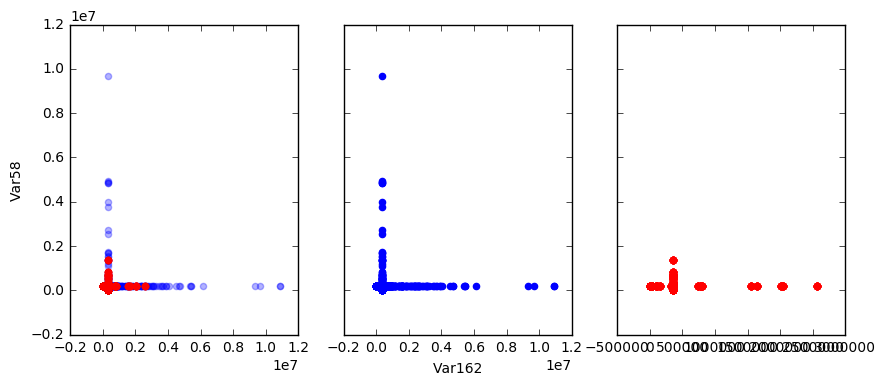

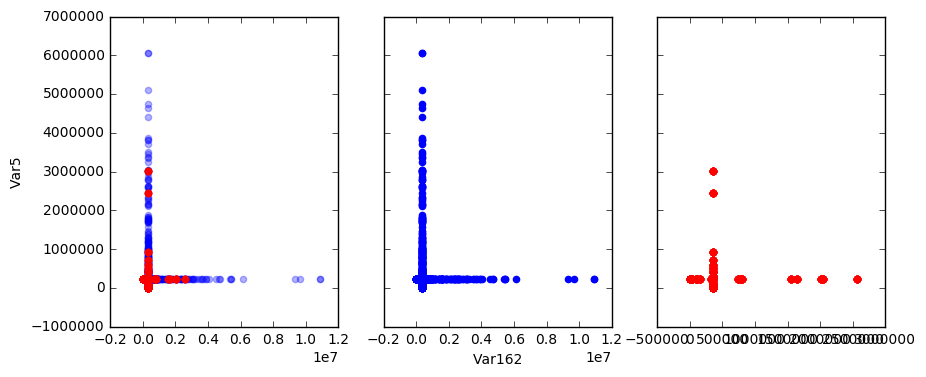

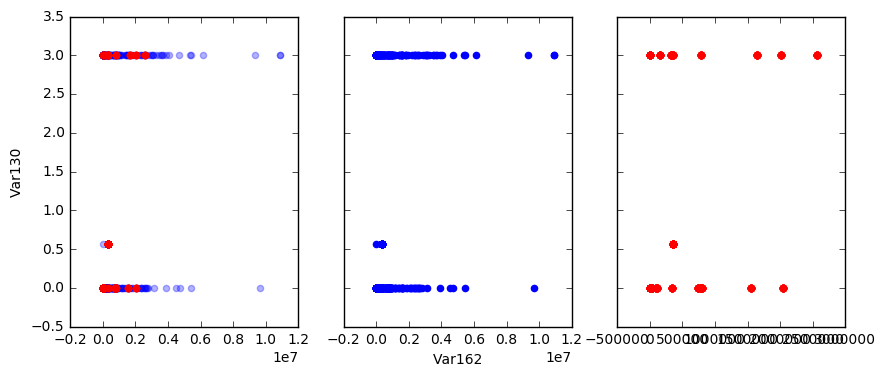

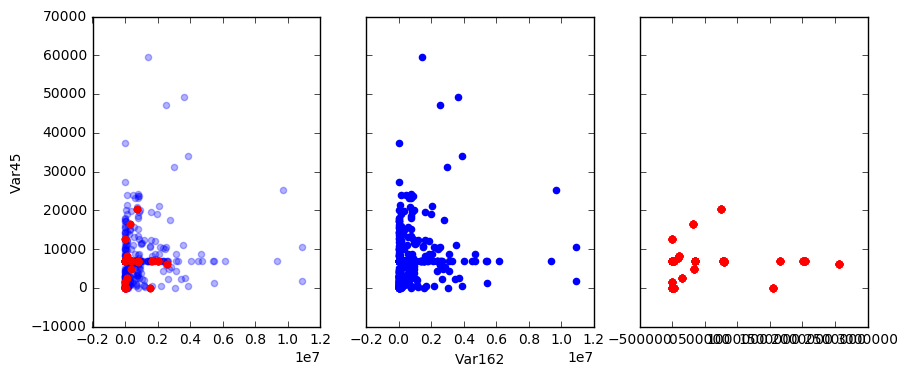

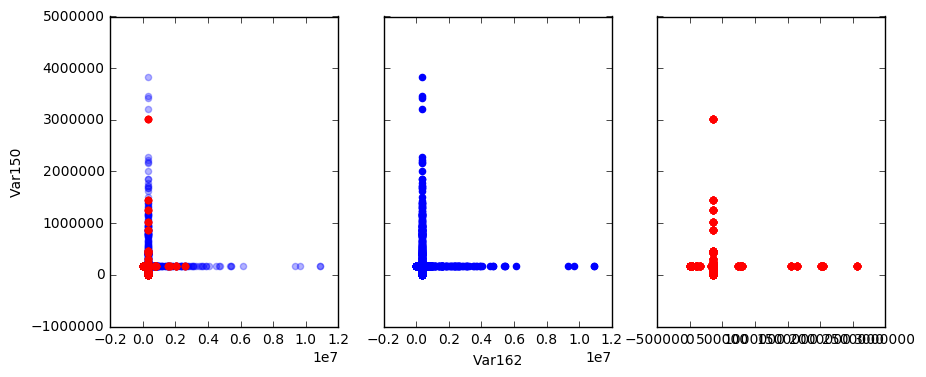

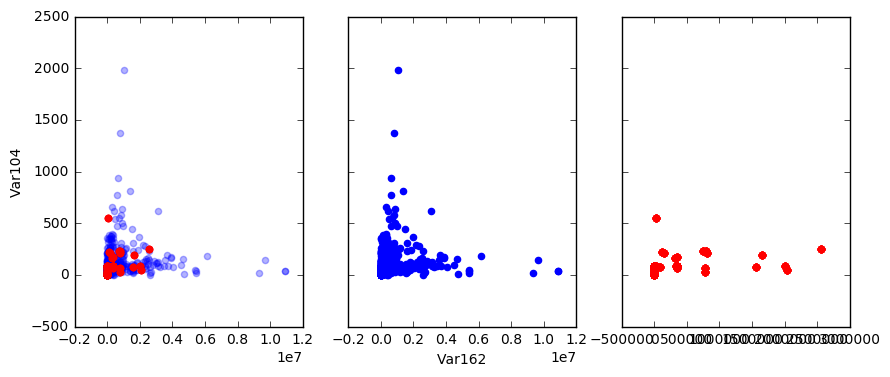

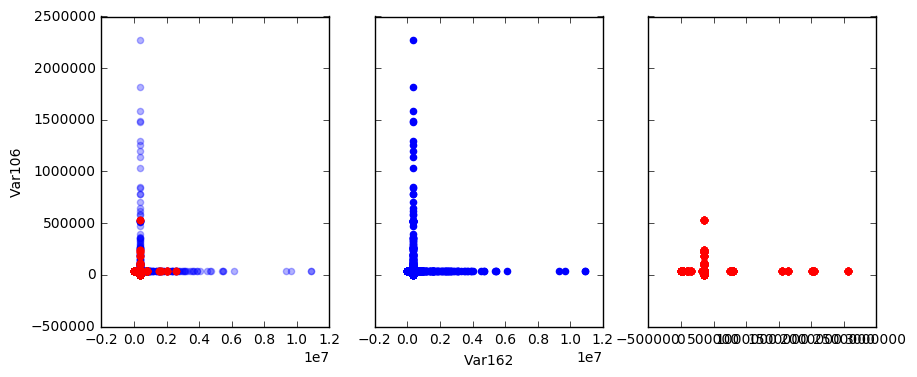

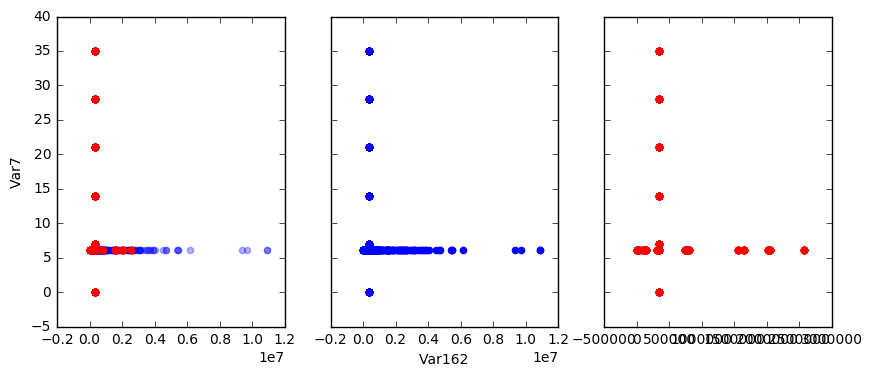

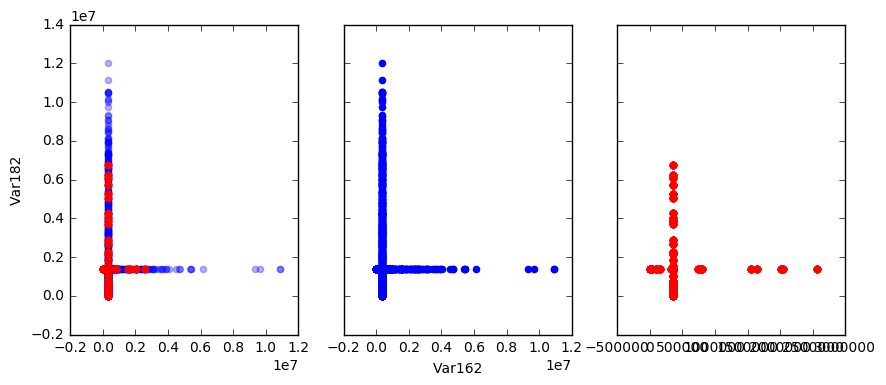

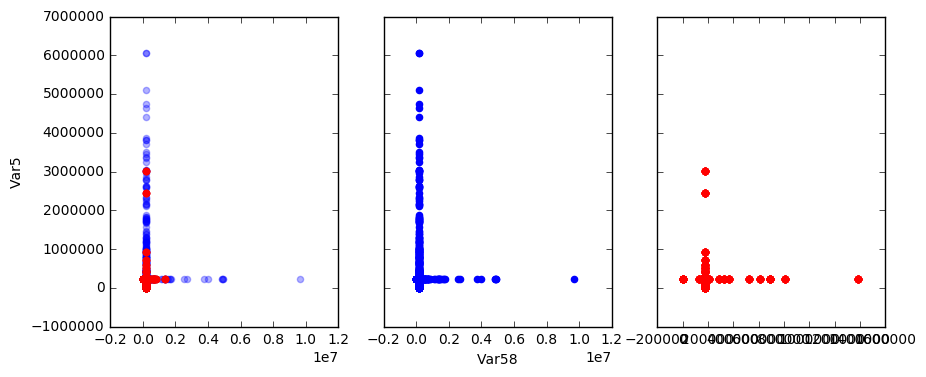

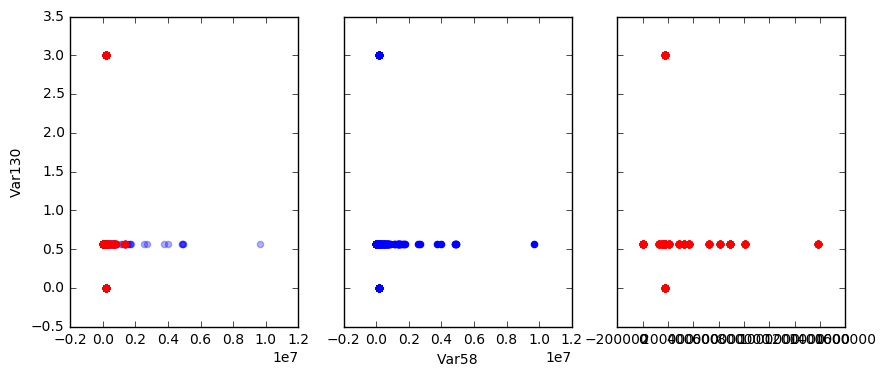

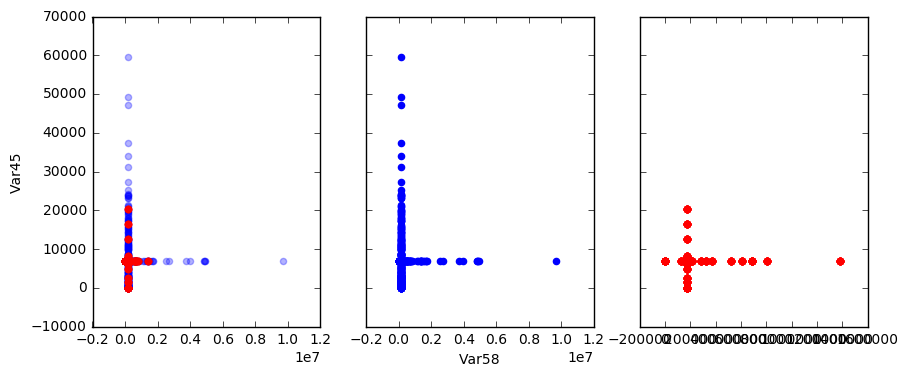

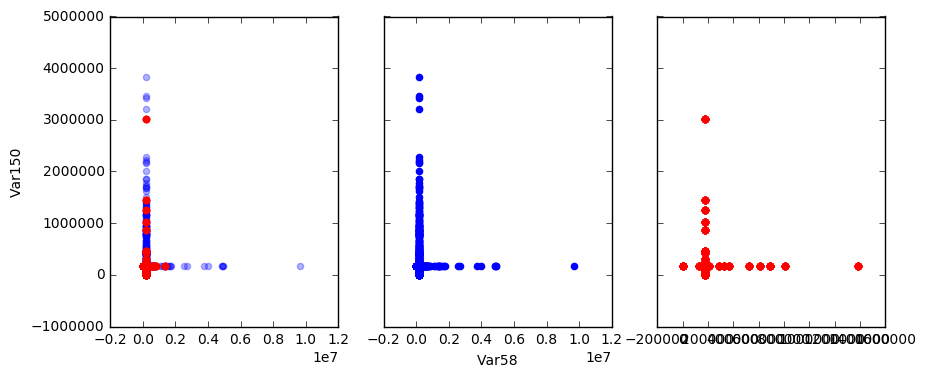

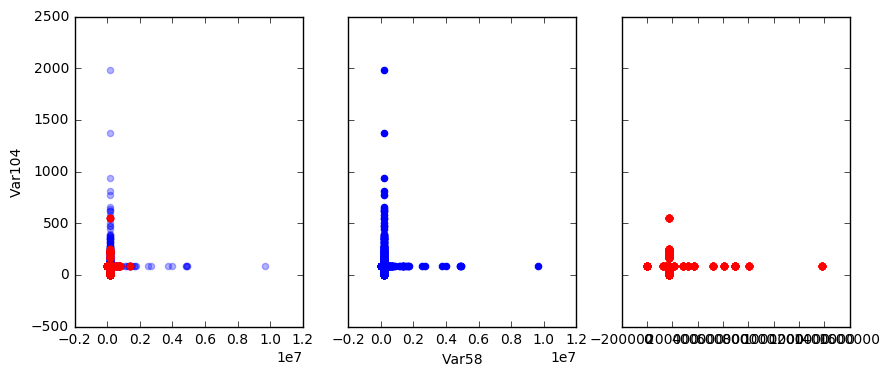

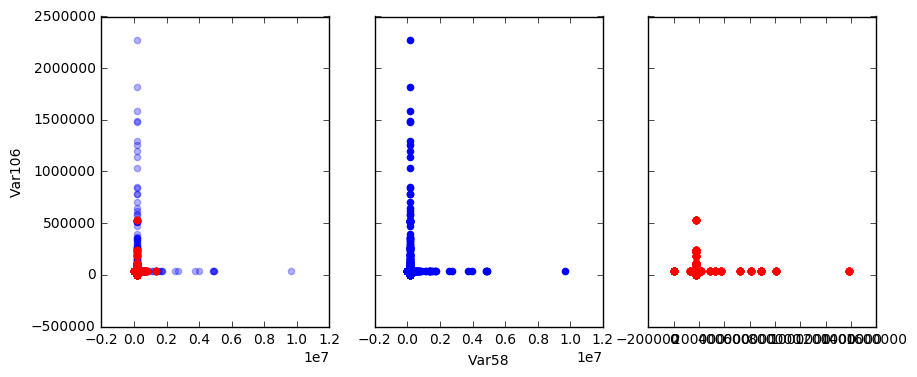

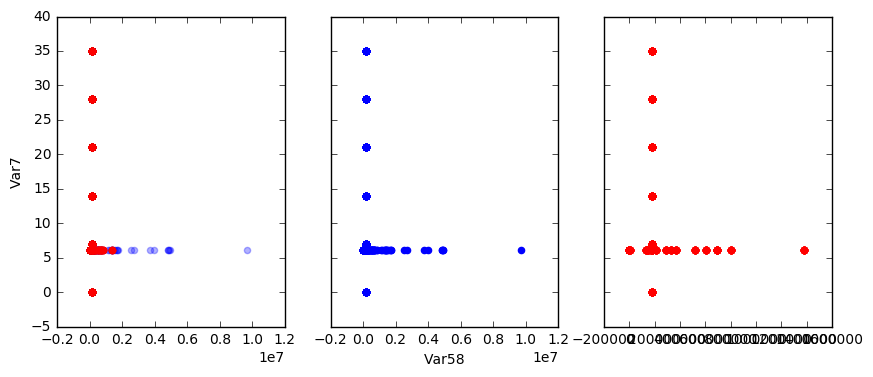

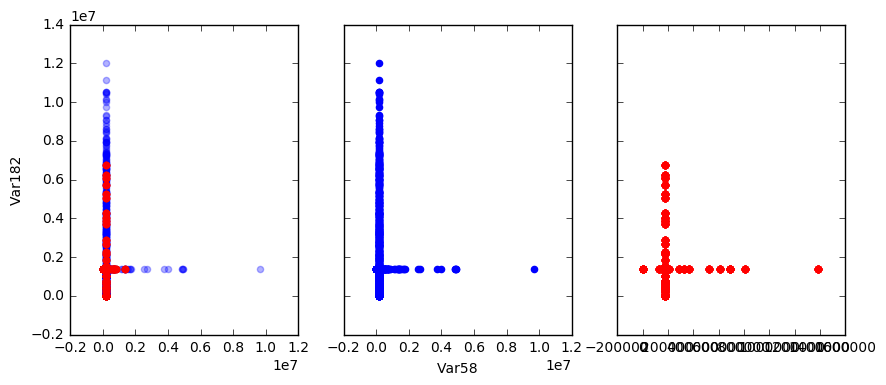

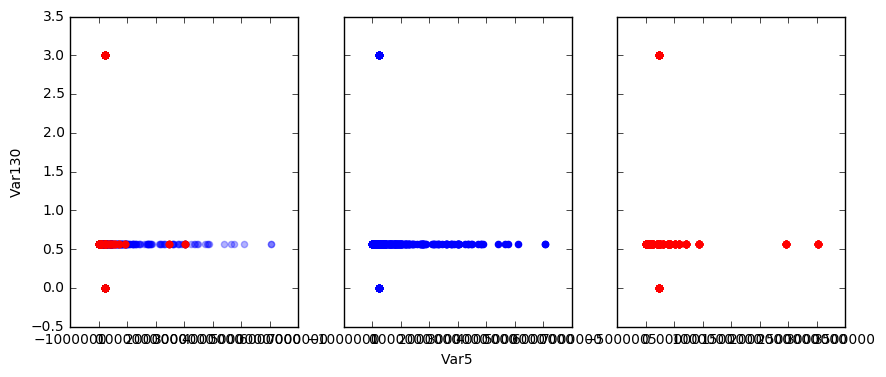

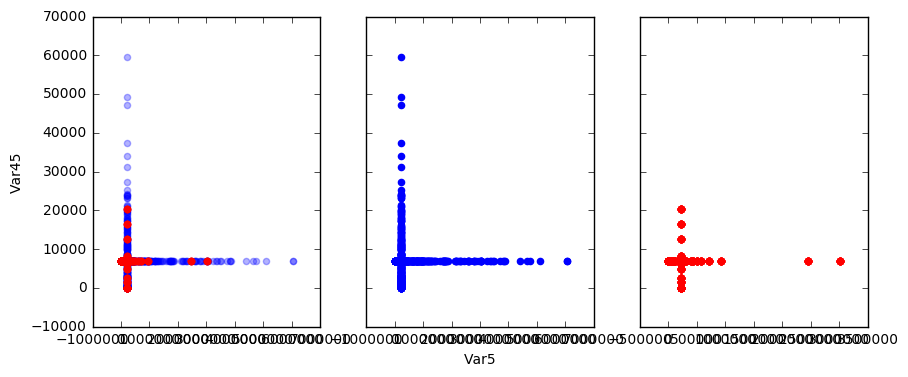

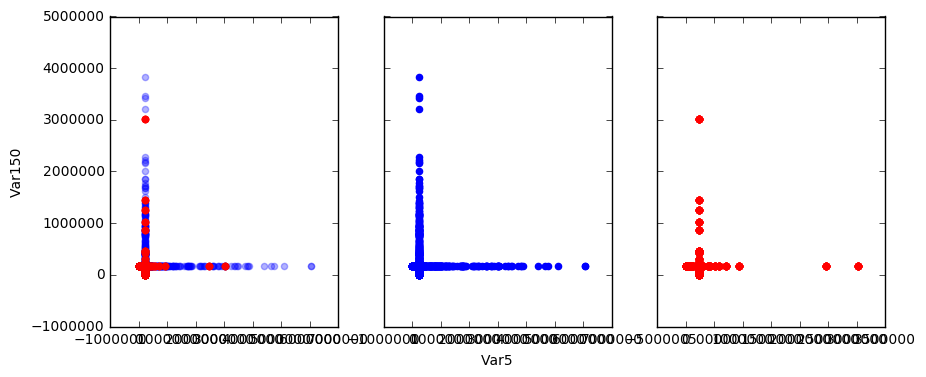

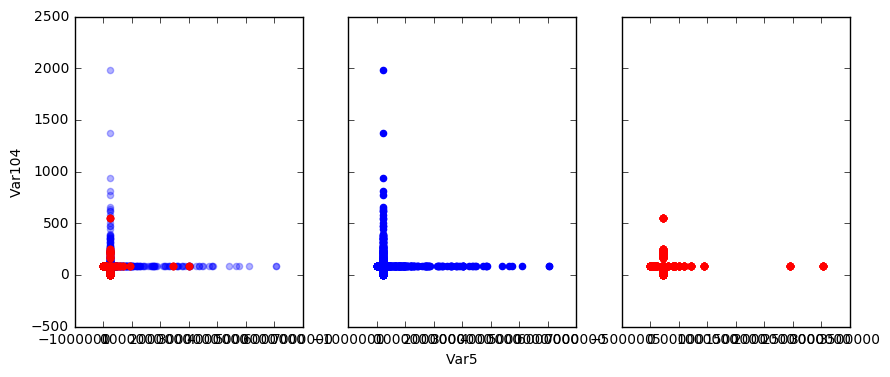

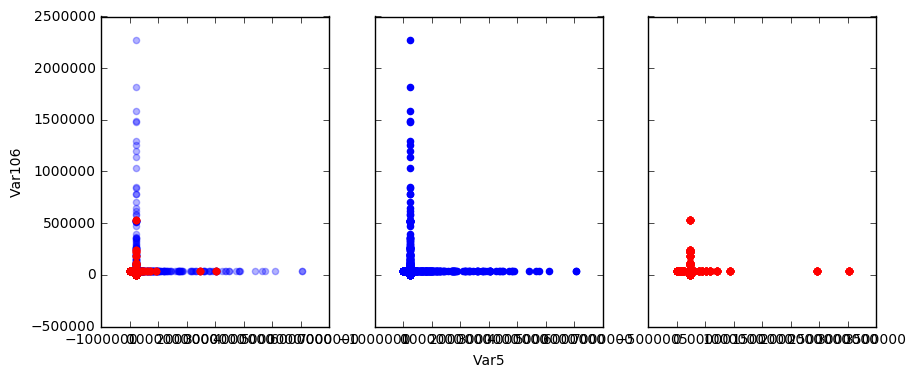

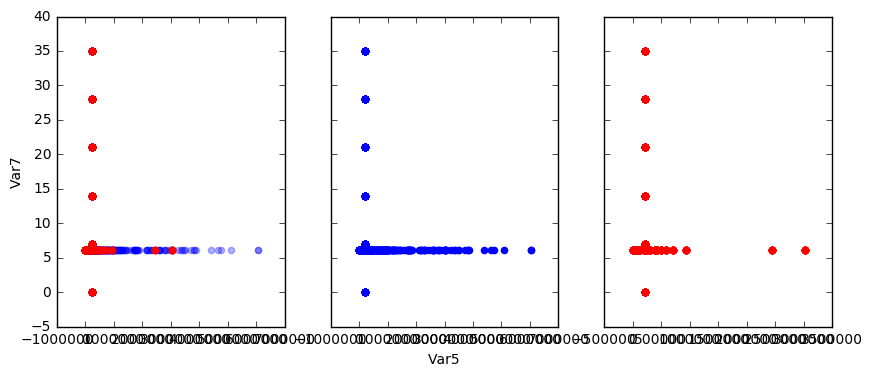

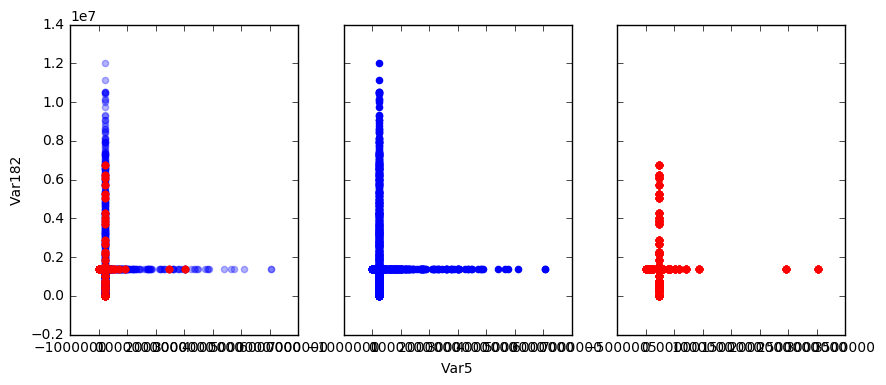

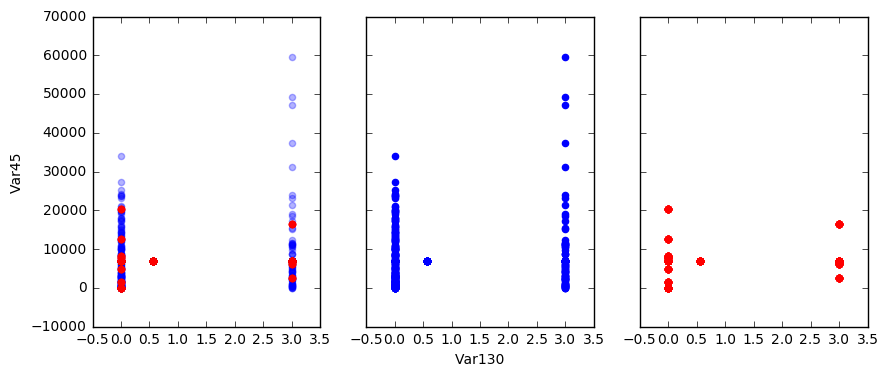

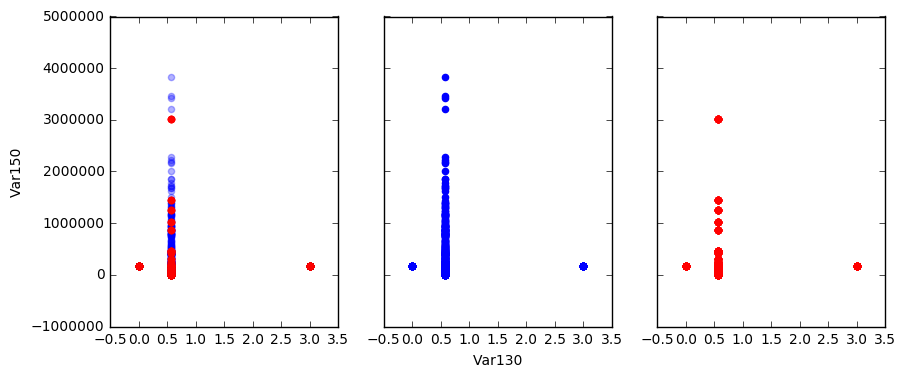

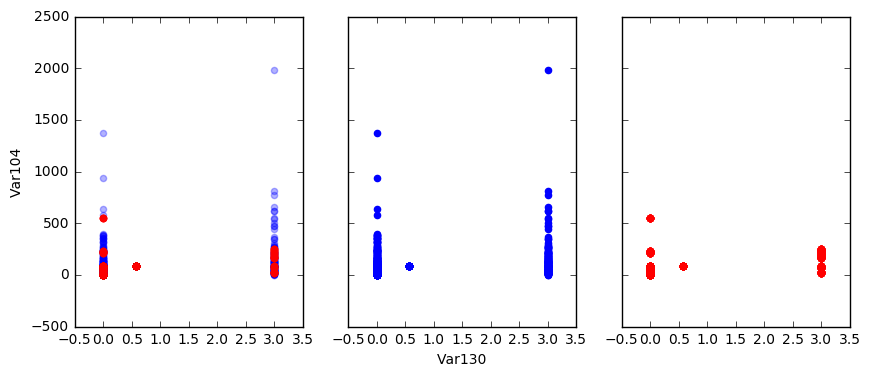

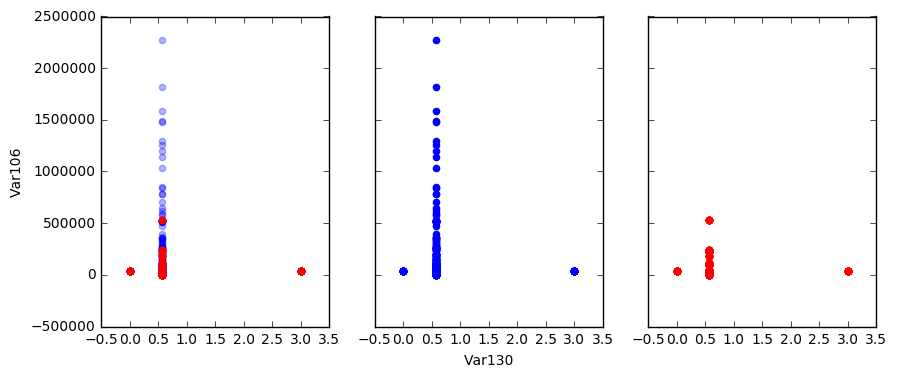

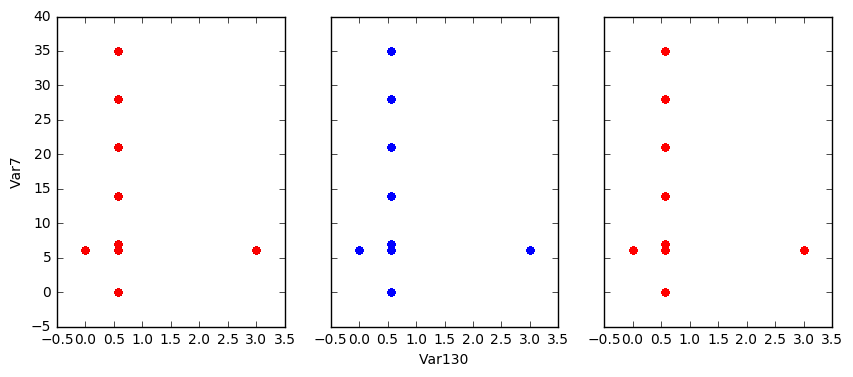

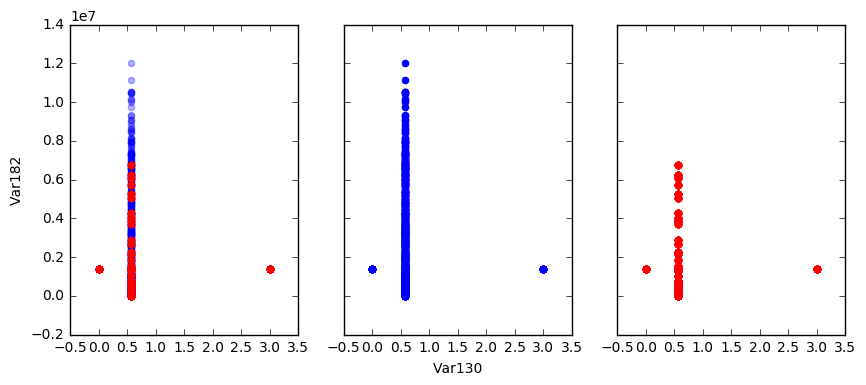

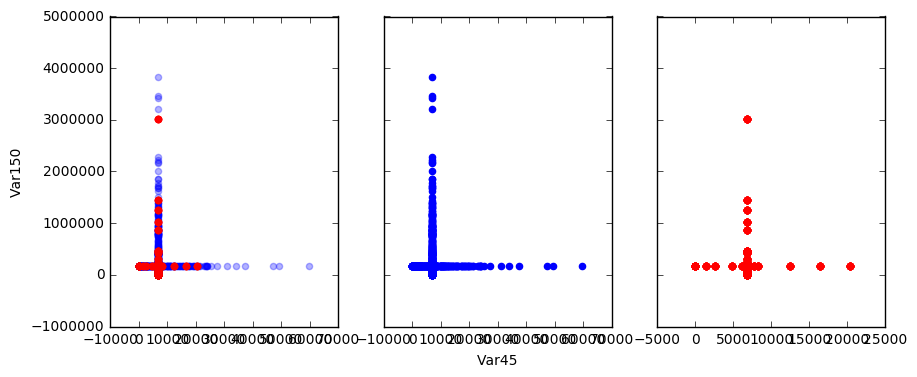

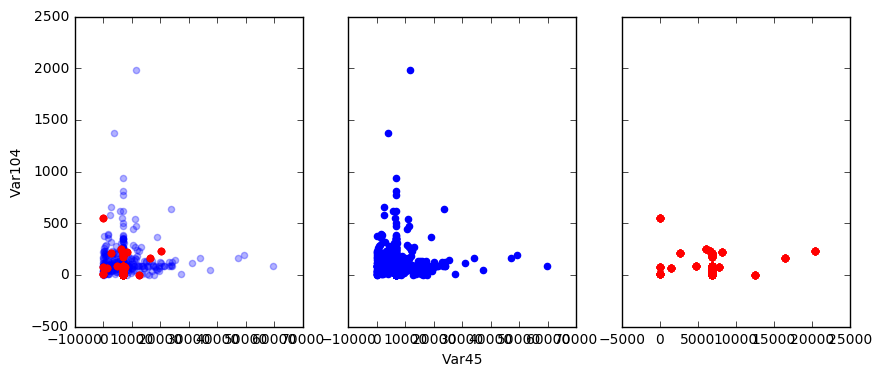

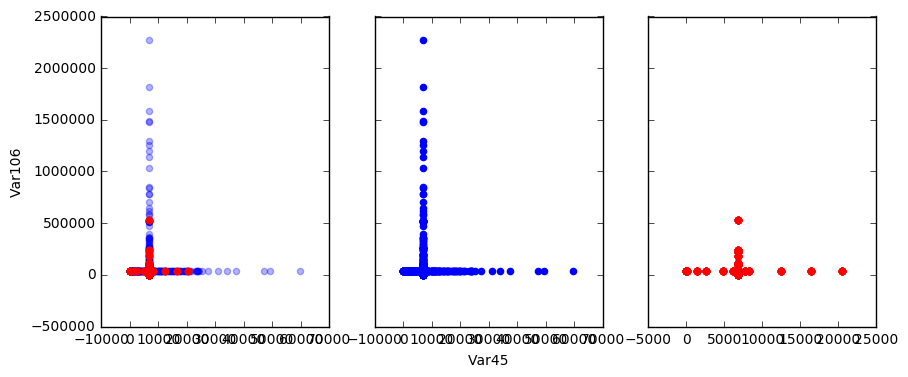

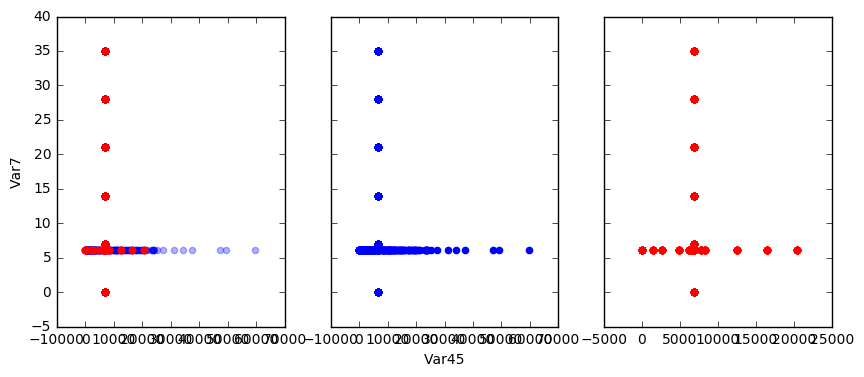

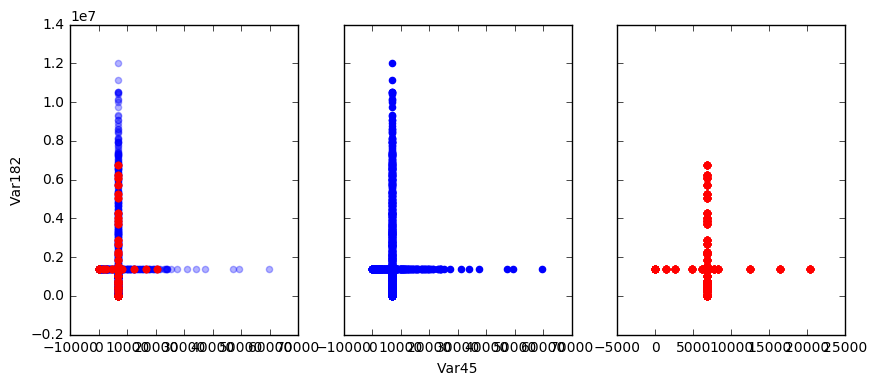

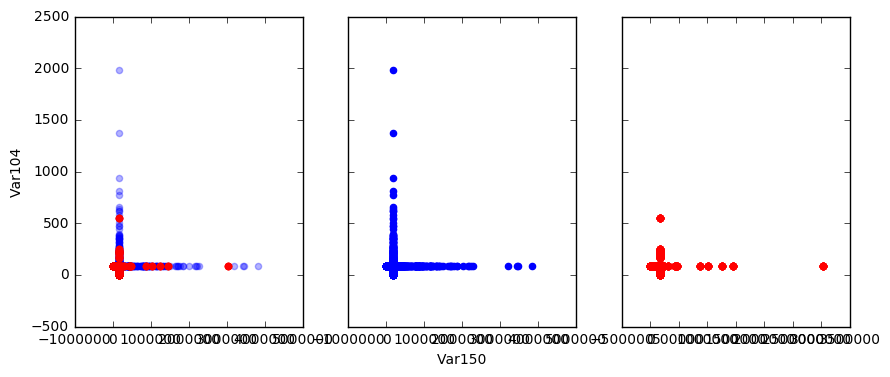

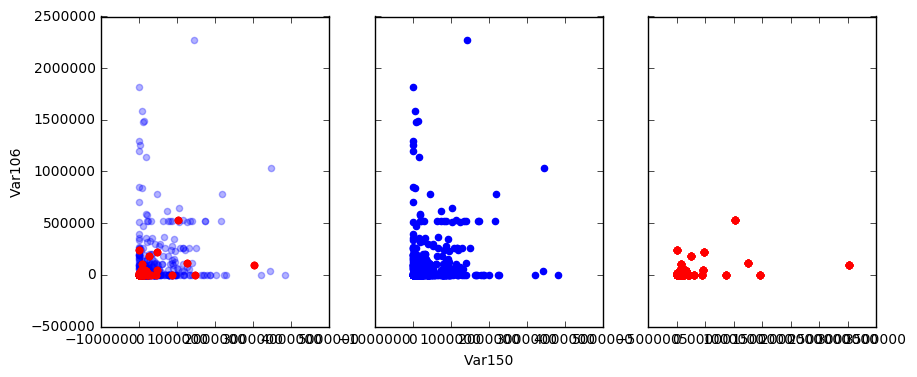

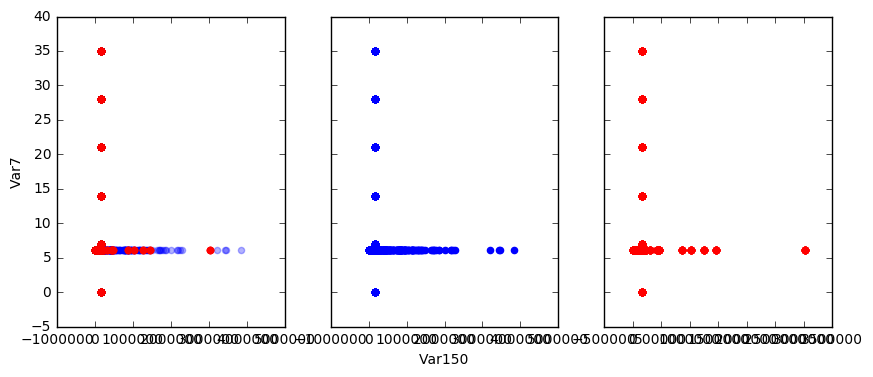

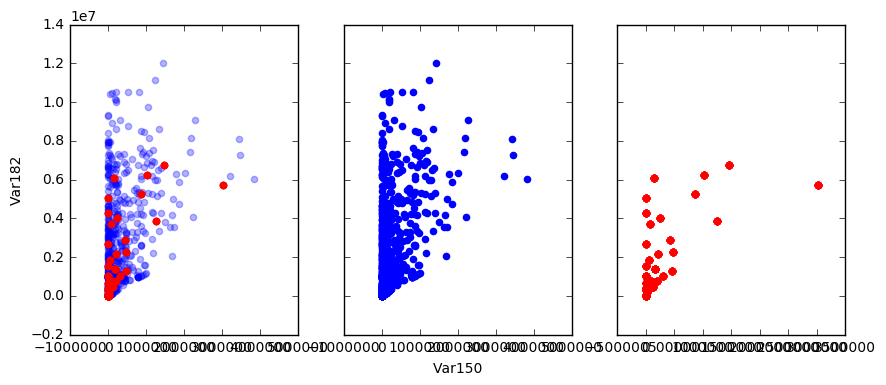

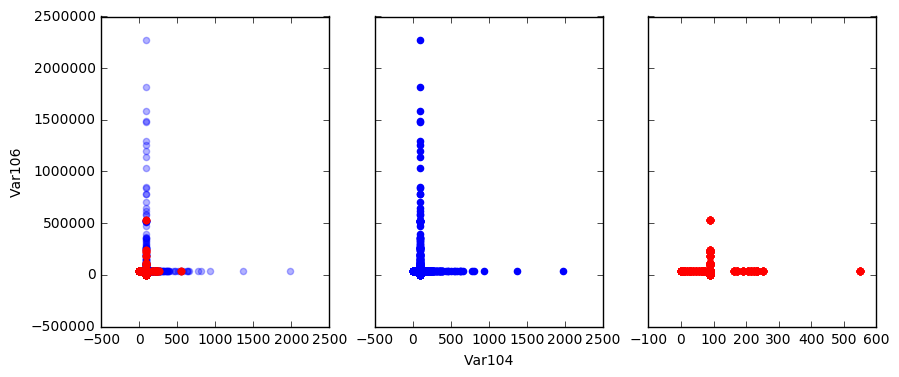

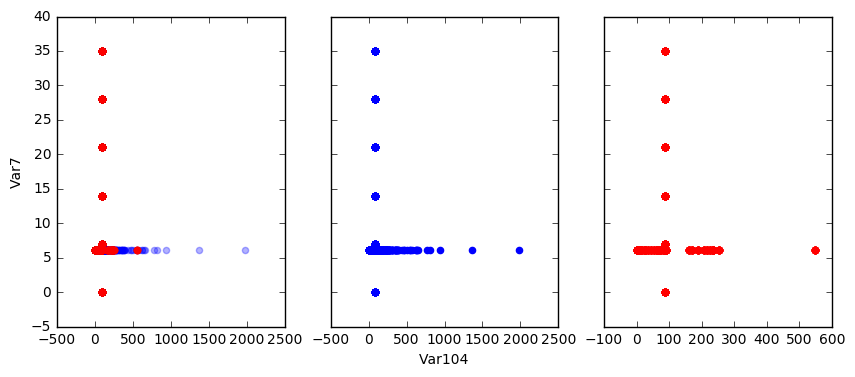

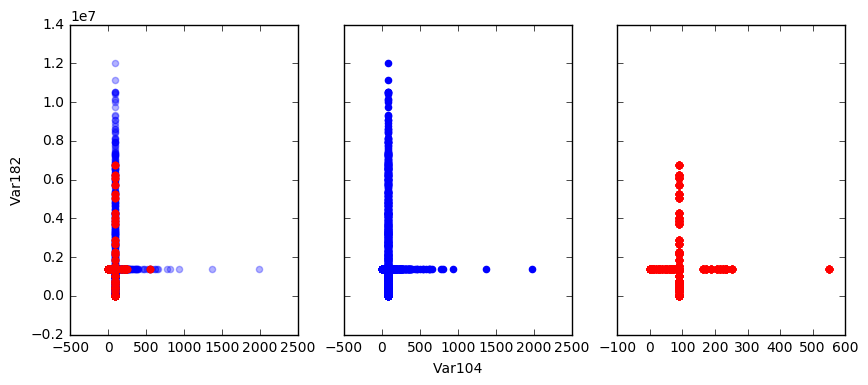

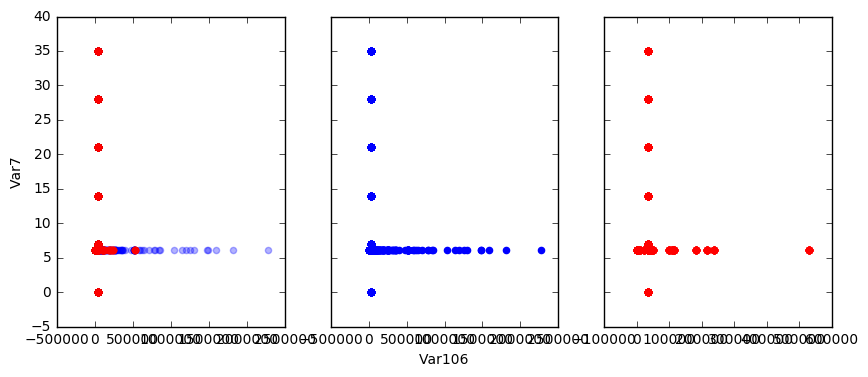

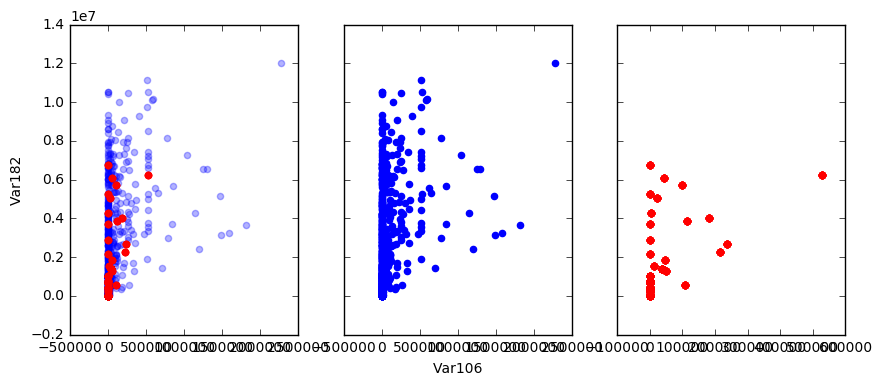

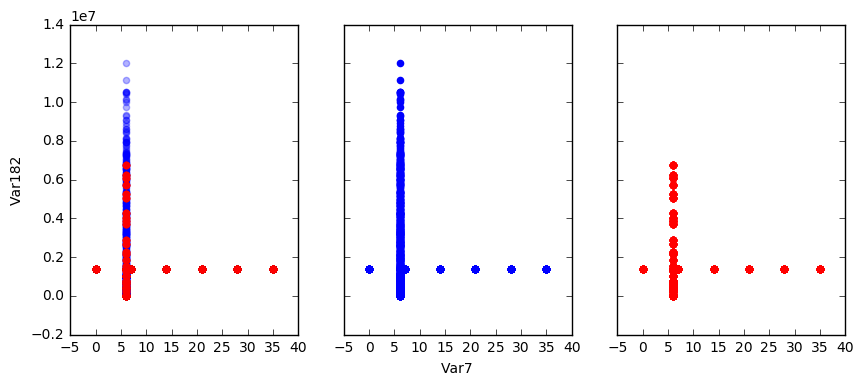

In [21]:
# И диаграммы рассеяния
build_scatter_plots(
    numeric_balanced_frame,
    random_columns,
    class_descriptions)

6\. Проделайте аналогичные шаги для 10 числовых признаков, наименее сильно коррелирующих с целевой переменной.

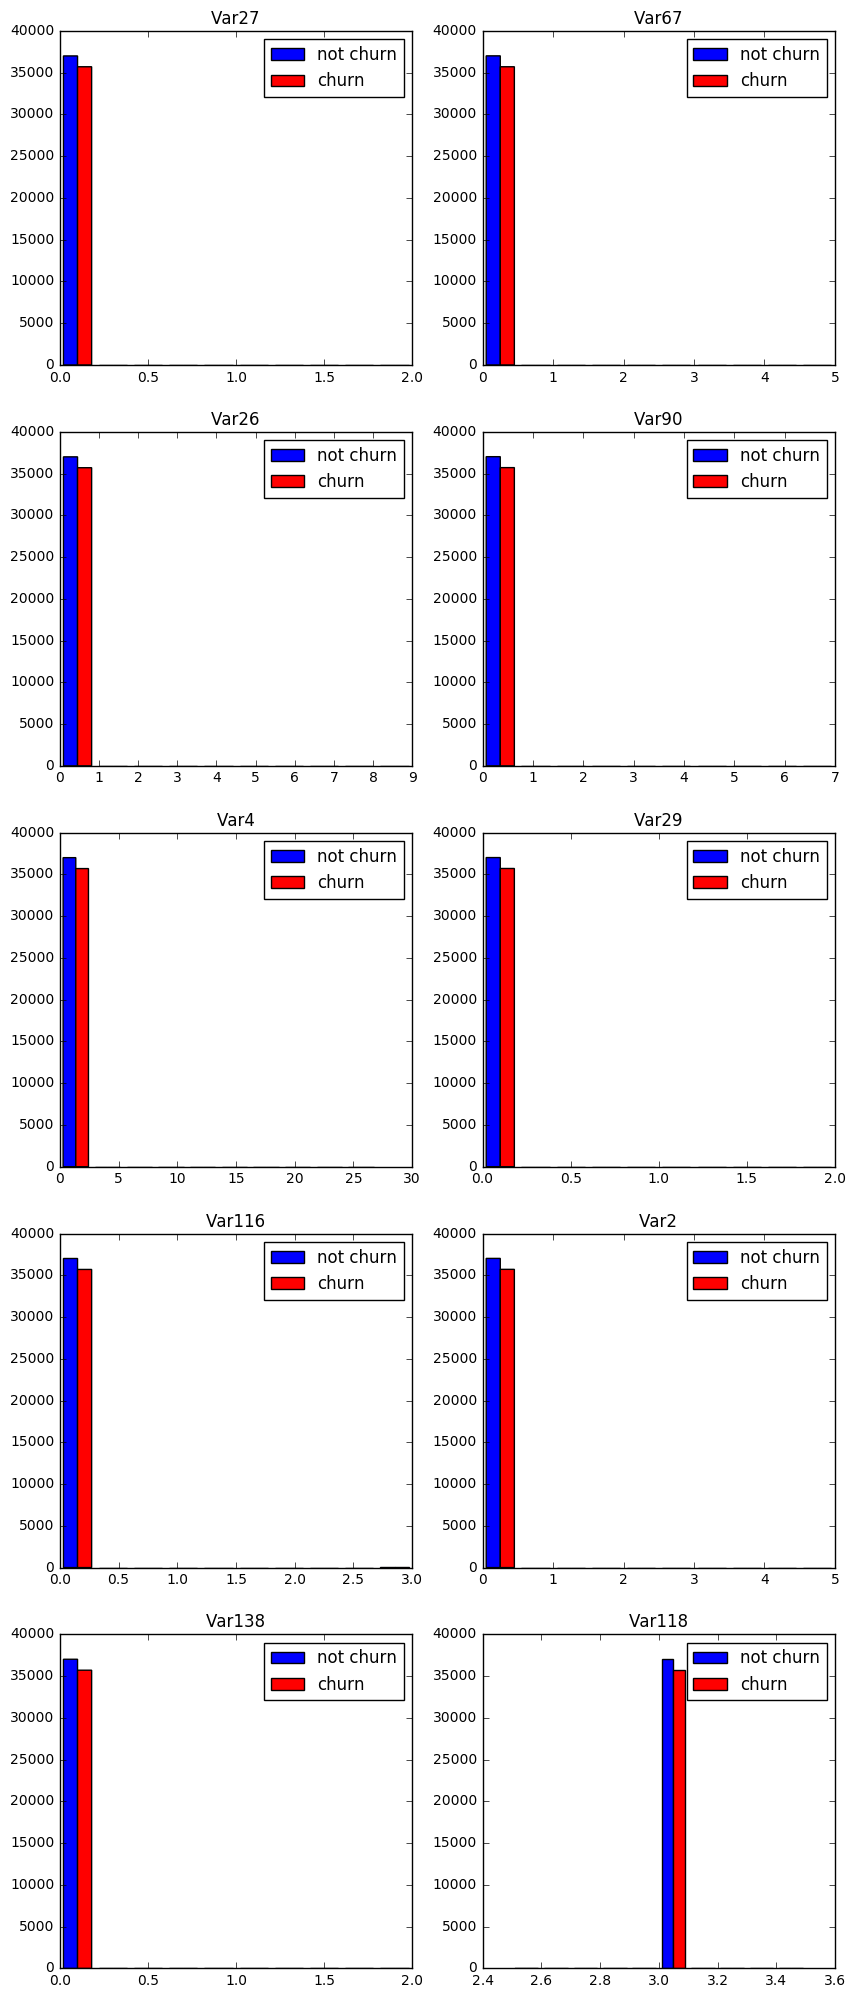

In [19]:
build_distribution_plots(numeric_balanced_frame, bottom_columns, class_descriptions)

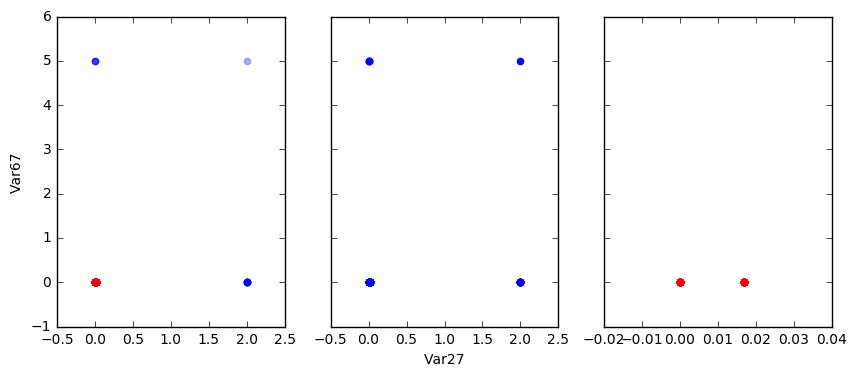

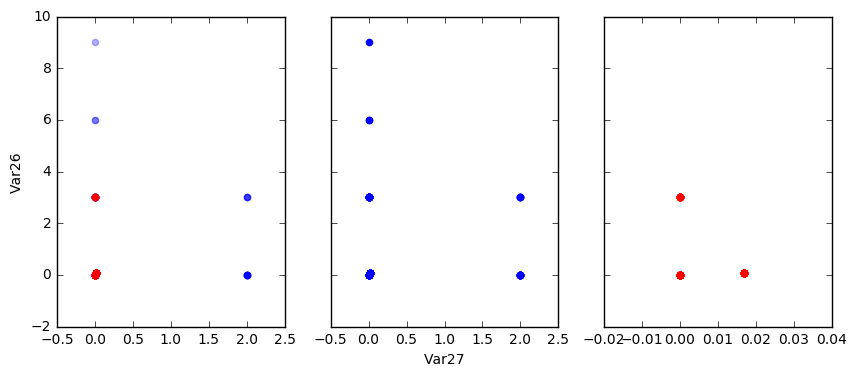

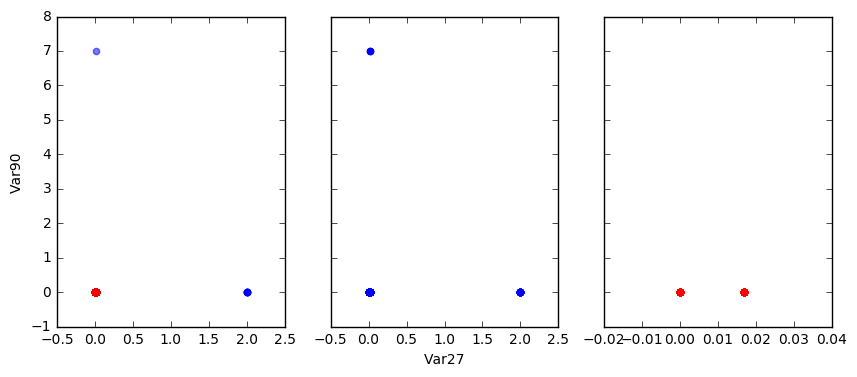

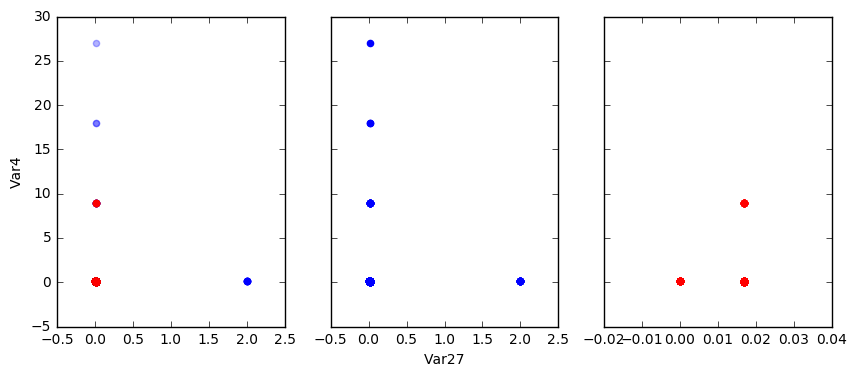

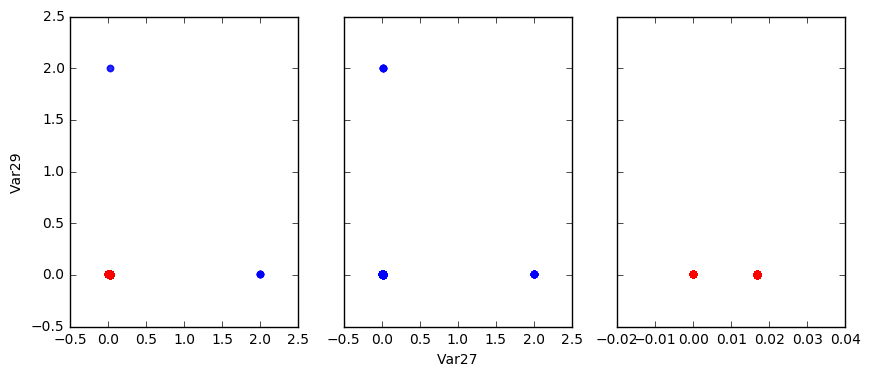

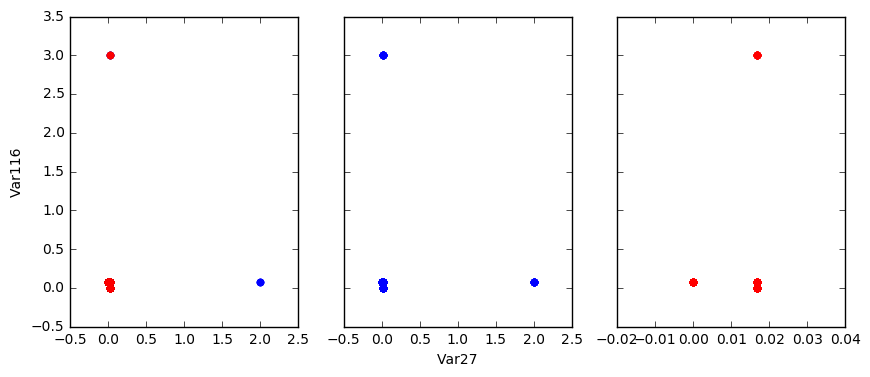

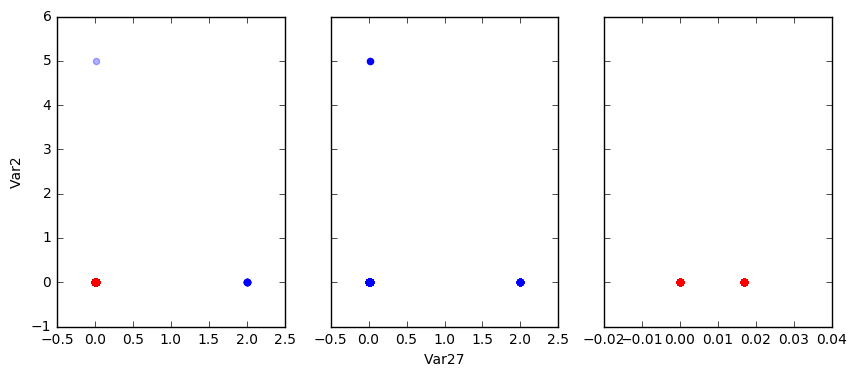

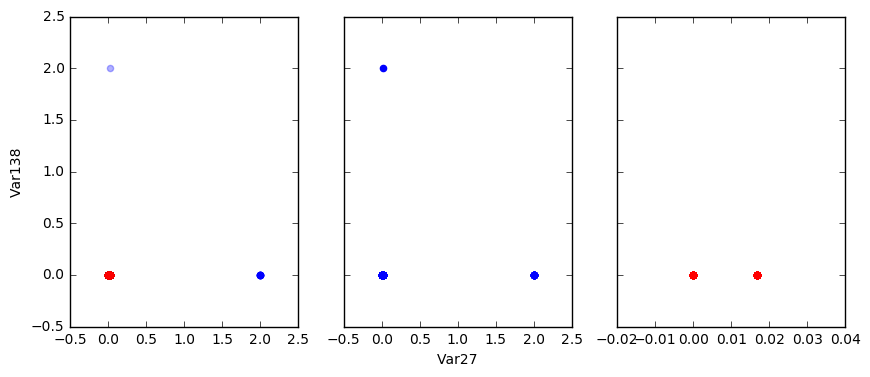

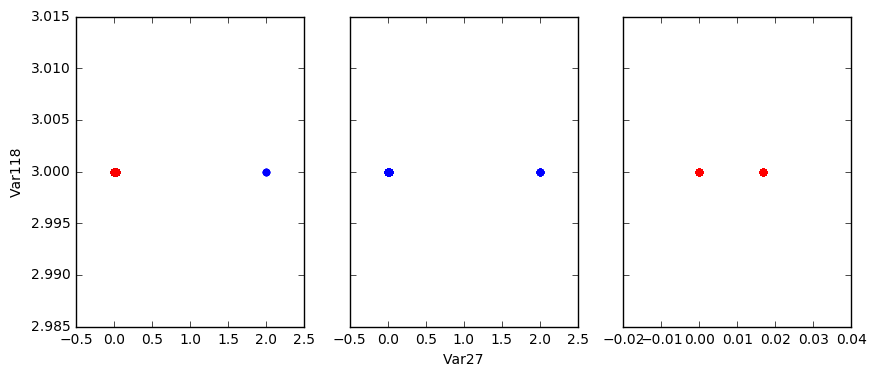

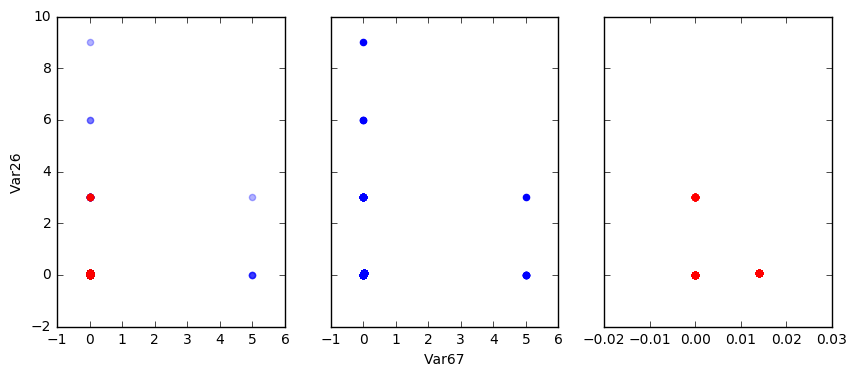

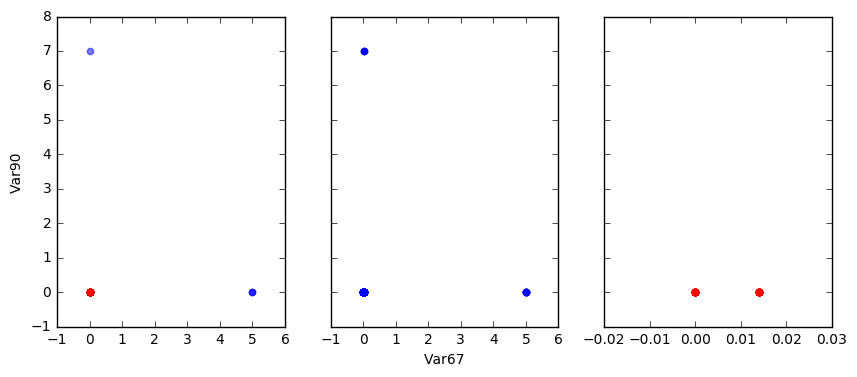

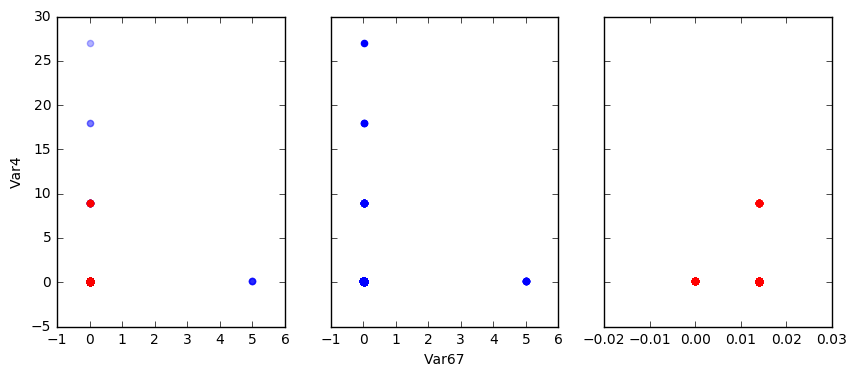

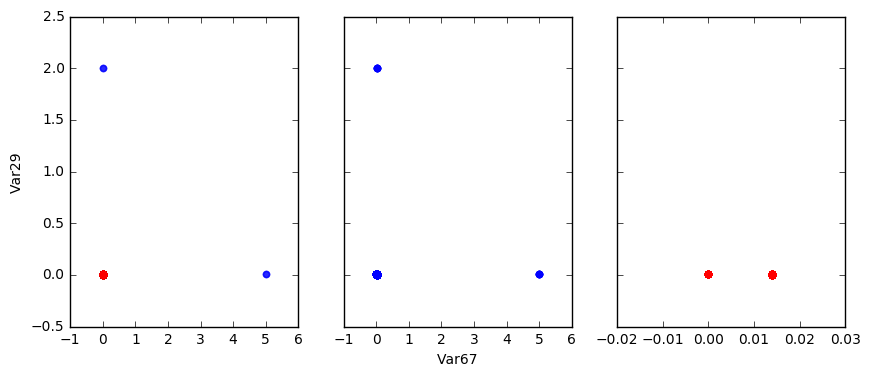

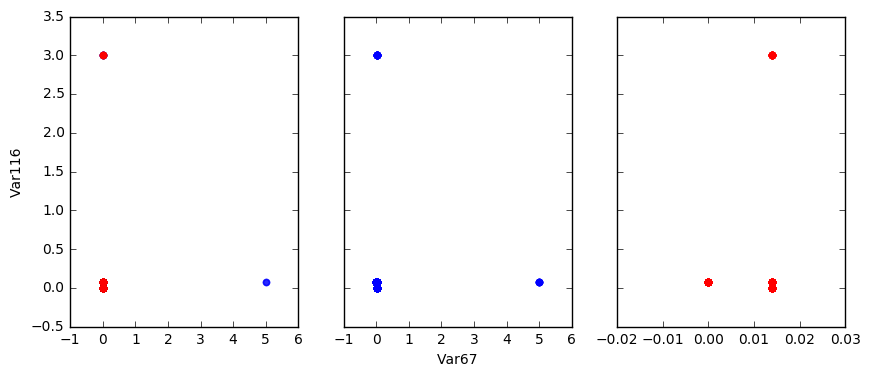

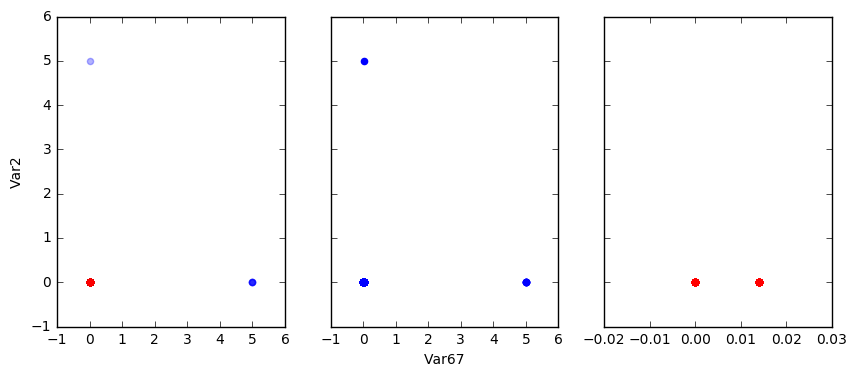

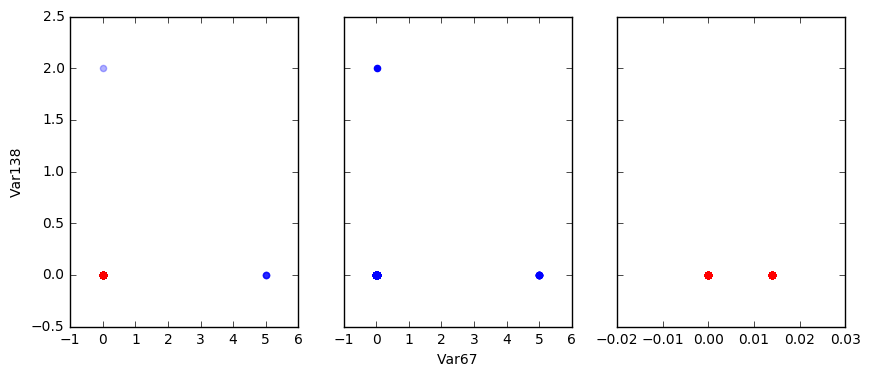

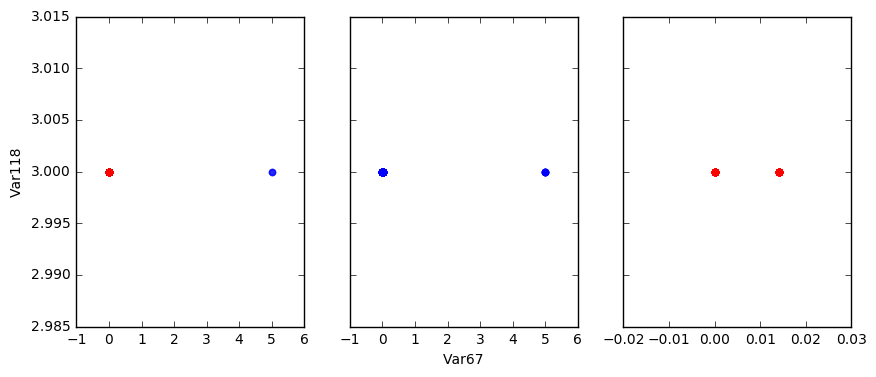

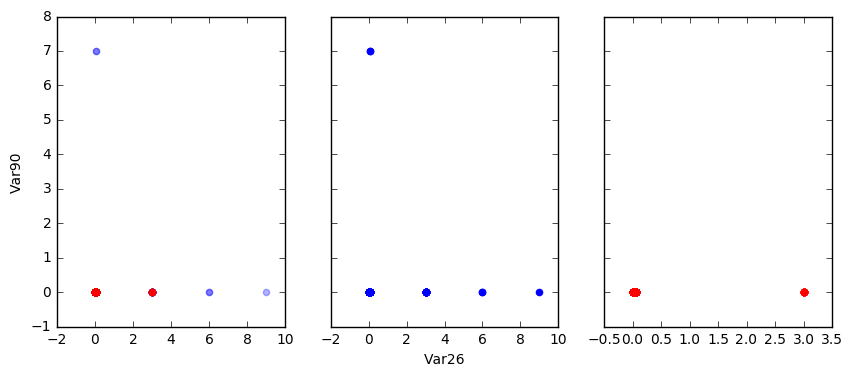

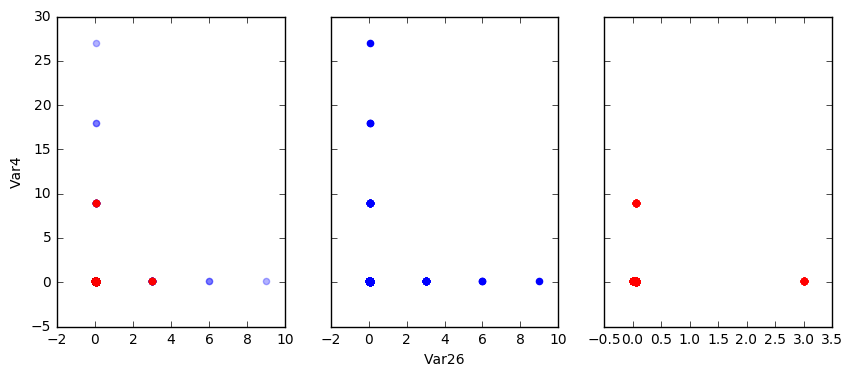

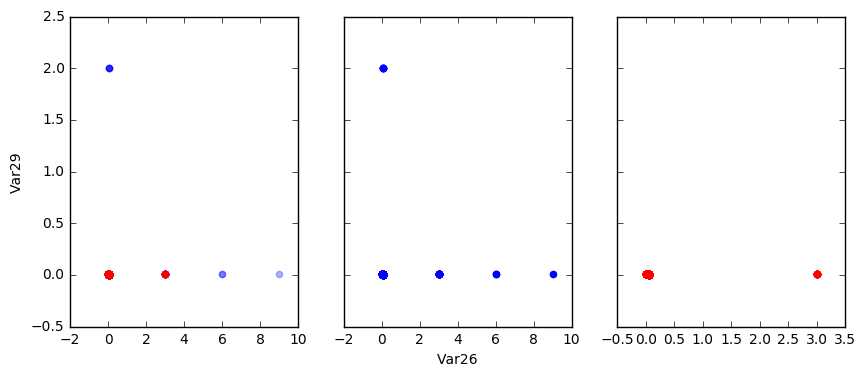

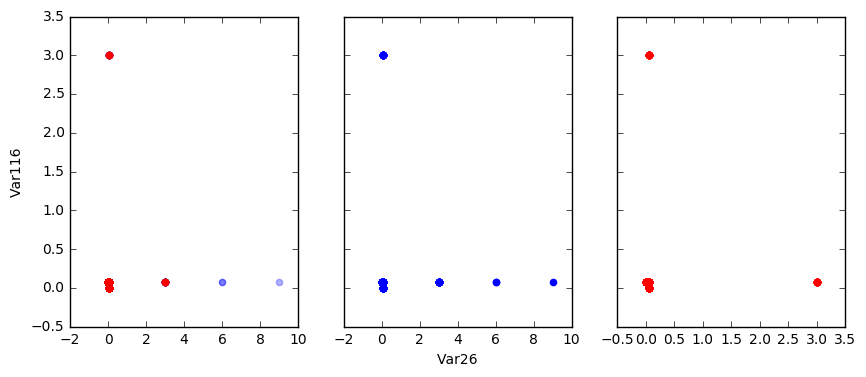

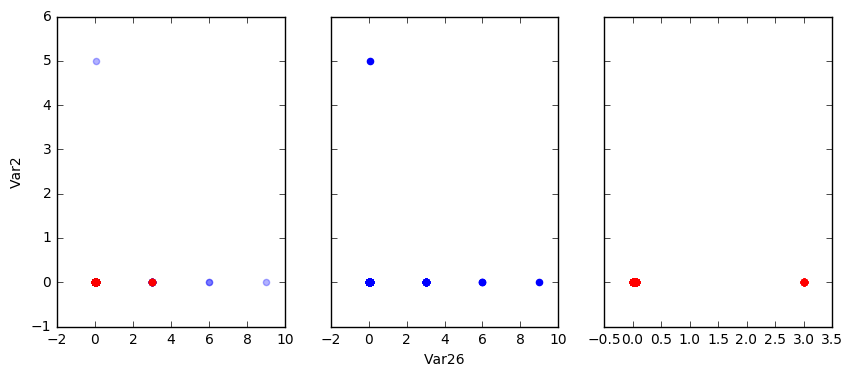

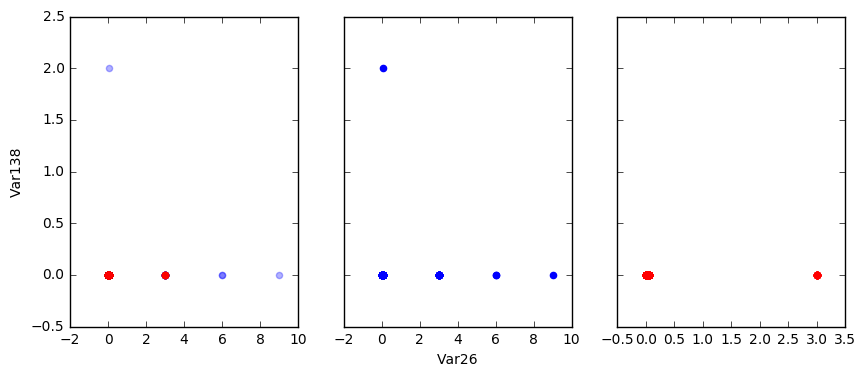

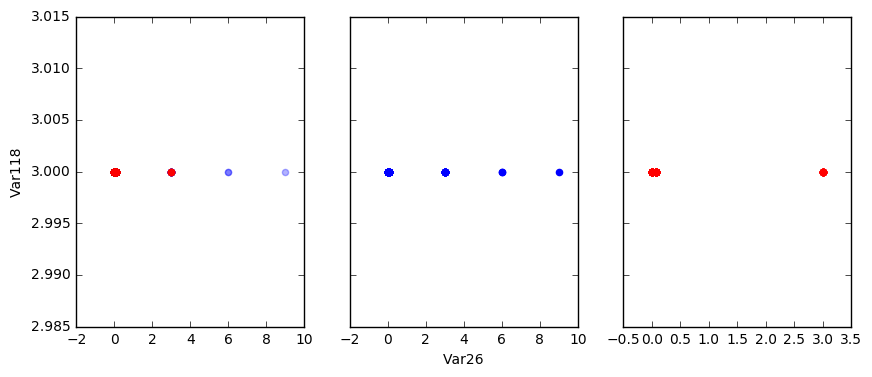

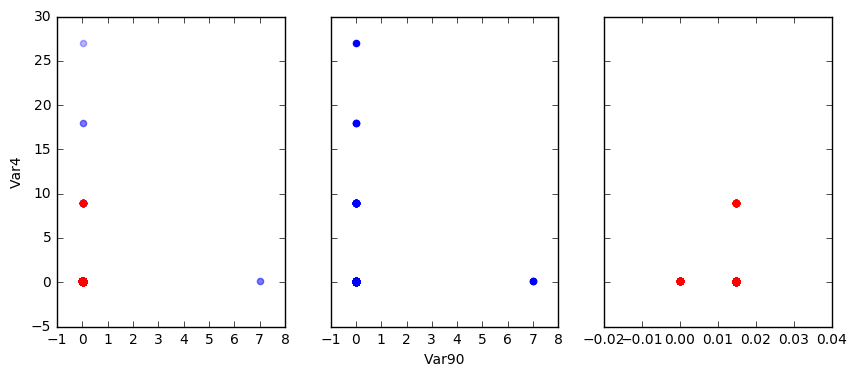

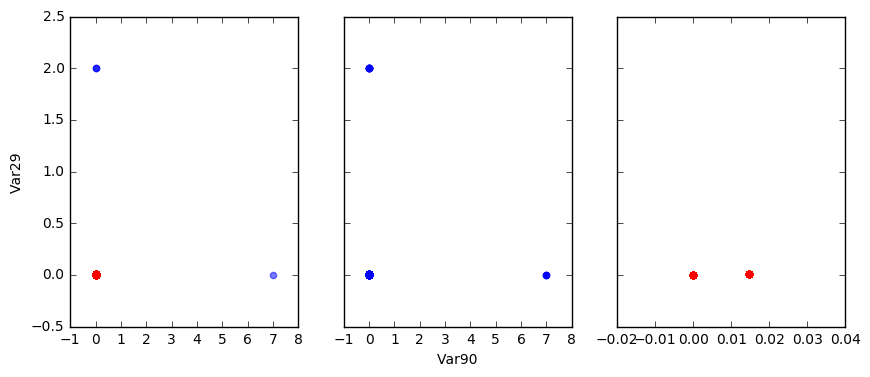

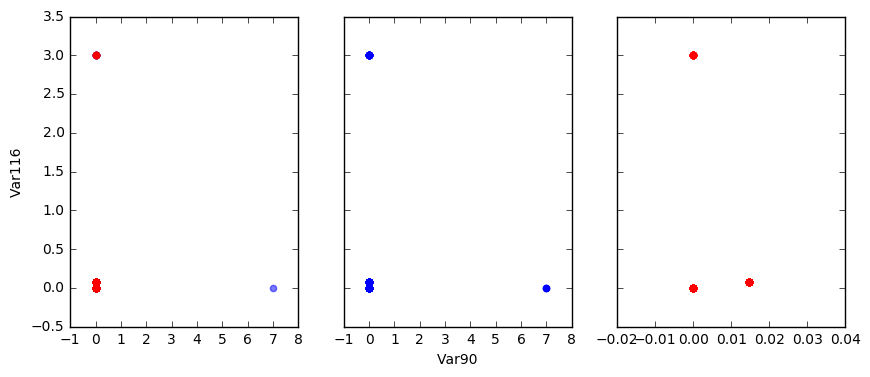

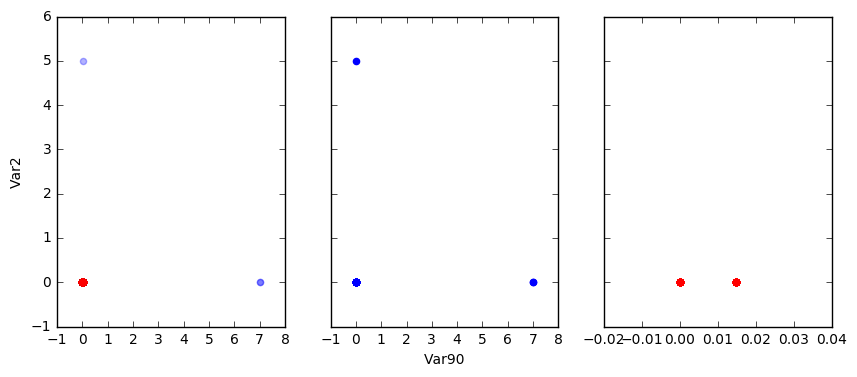

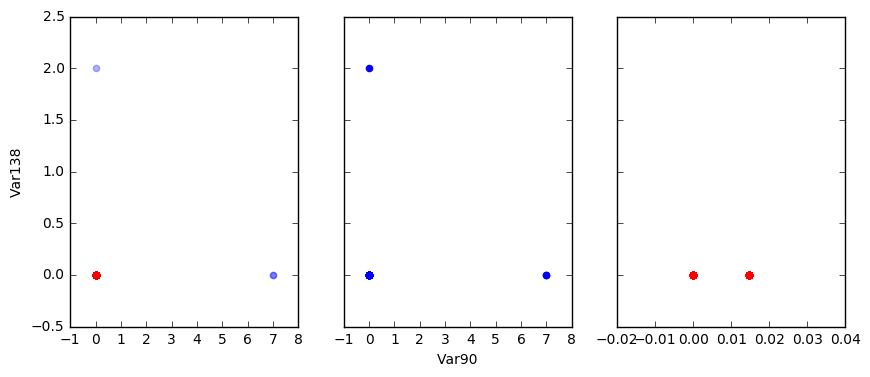

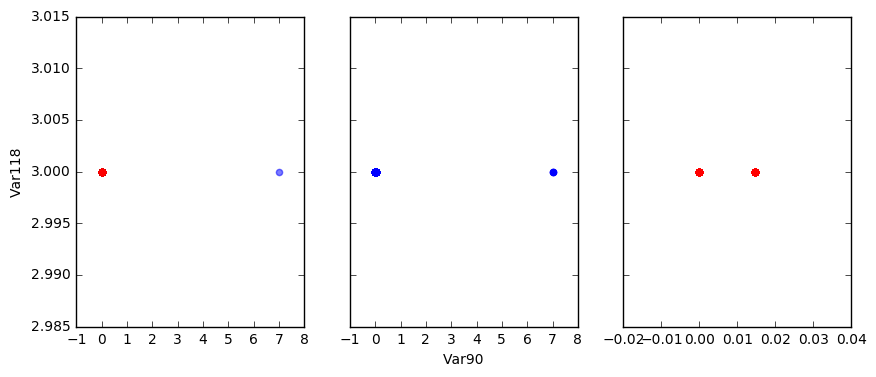

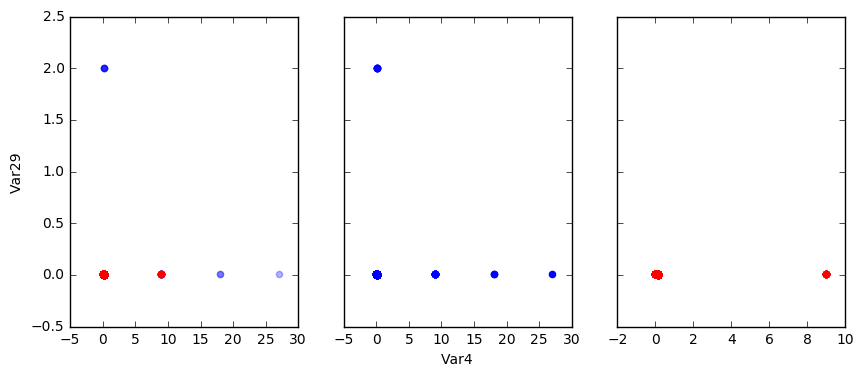

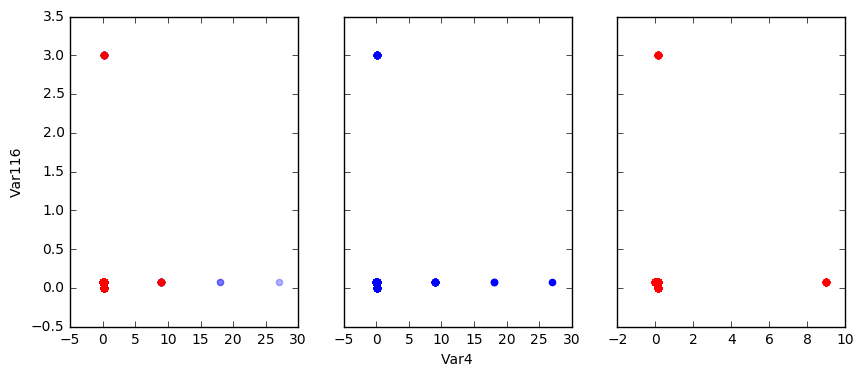

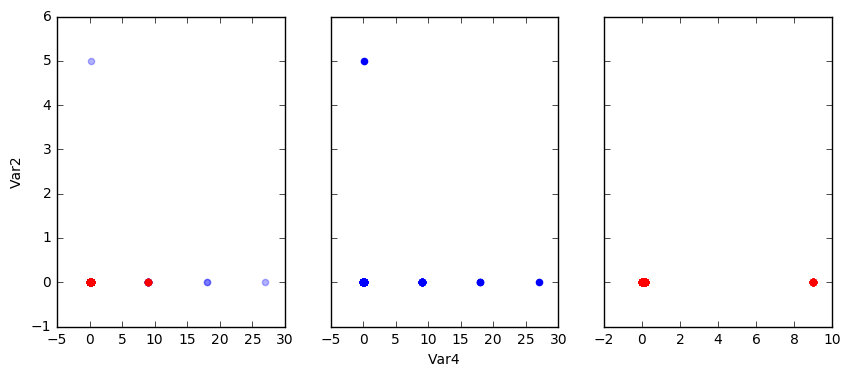

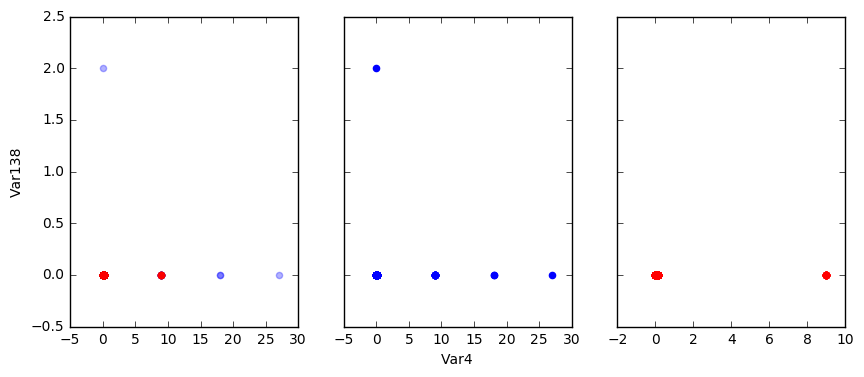

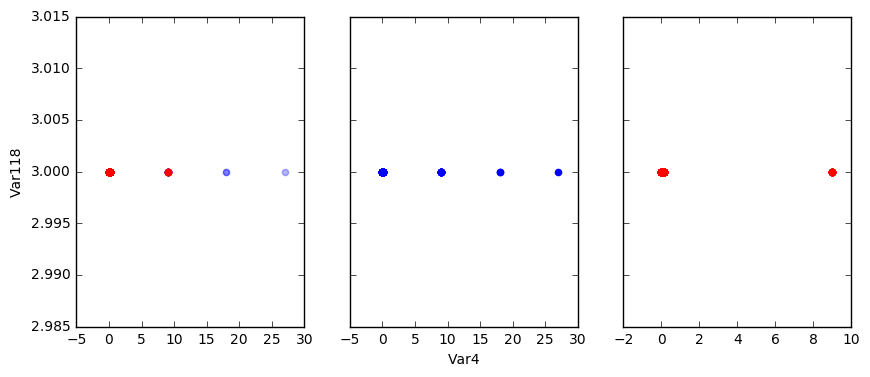

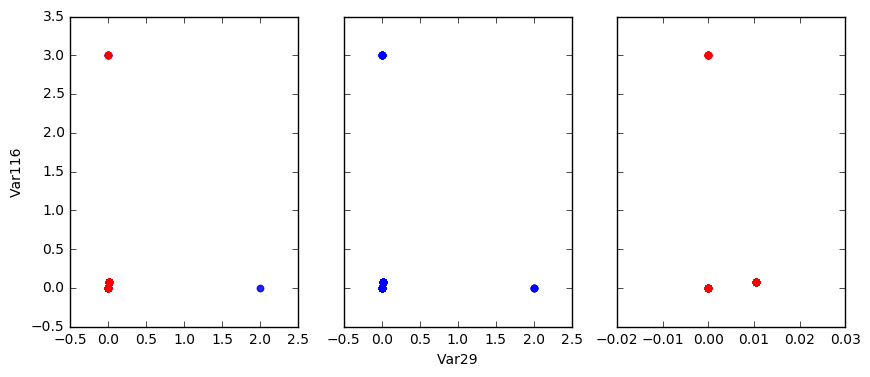

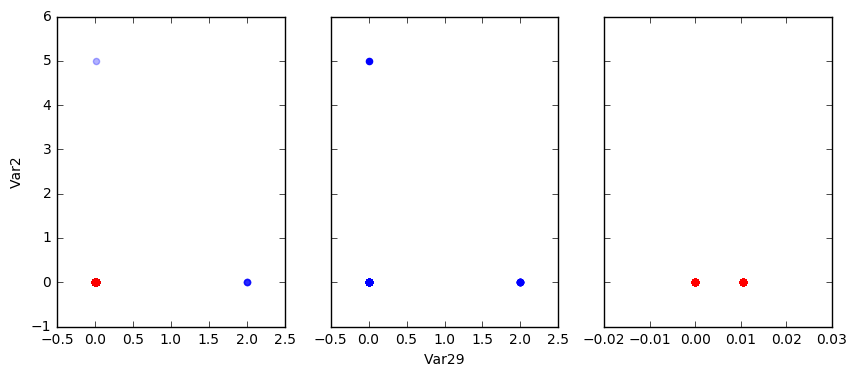

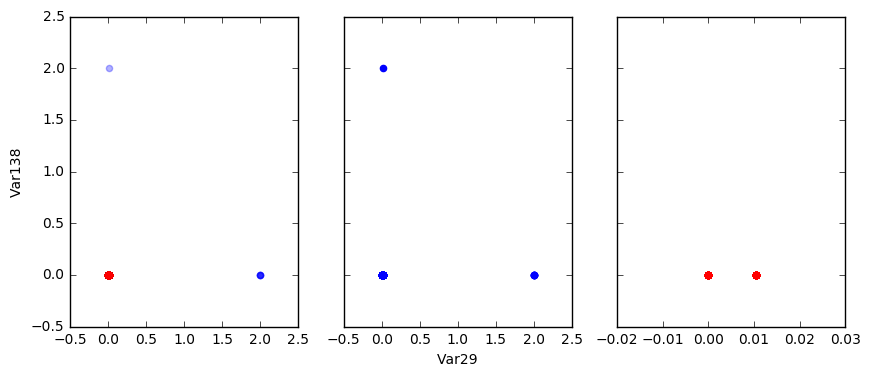

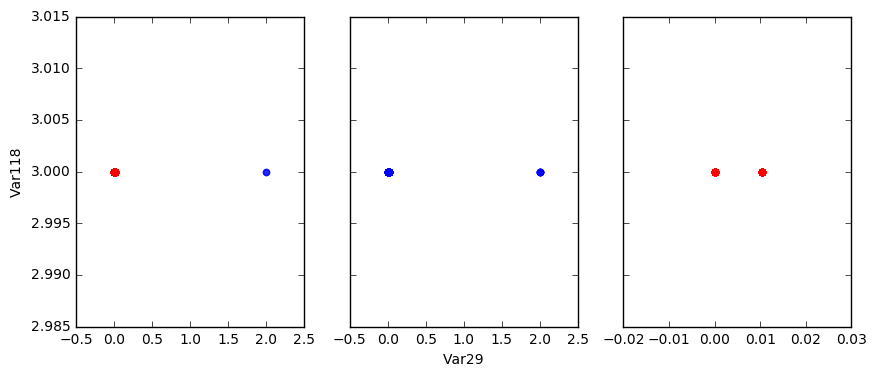

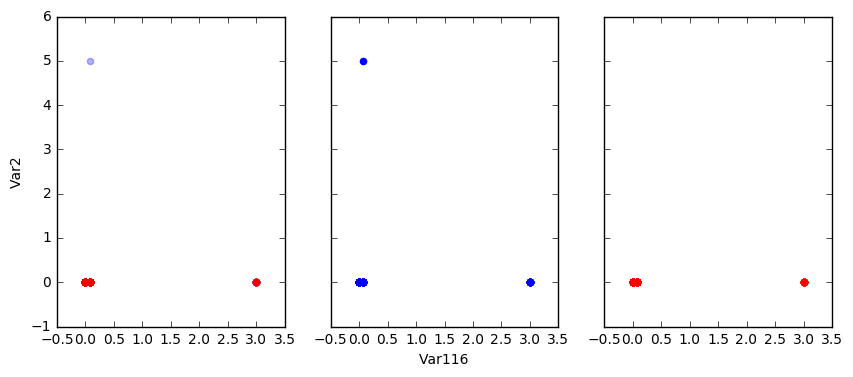

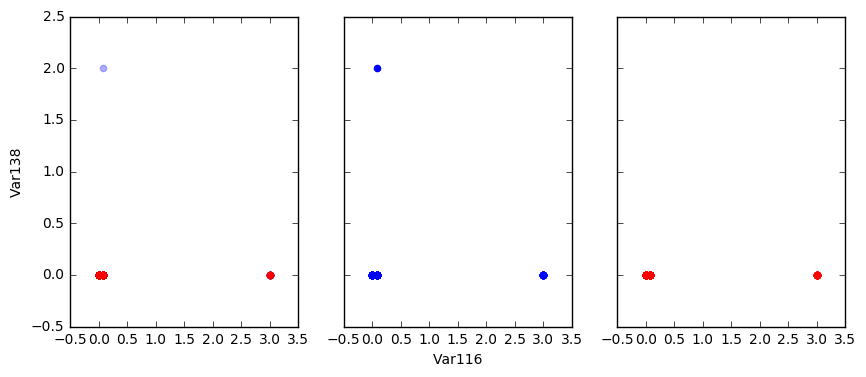

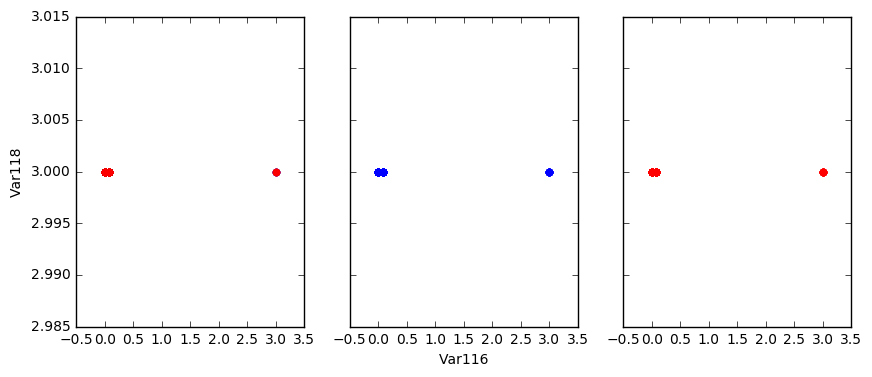

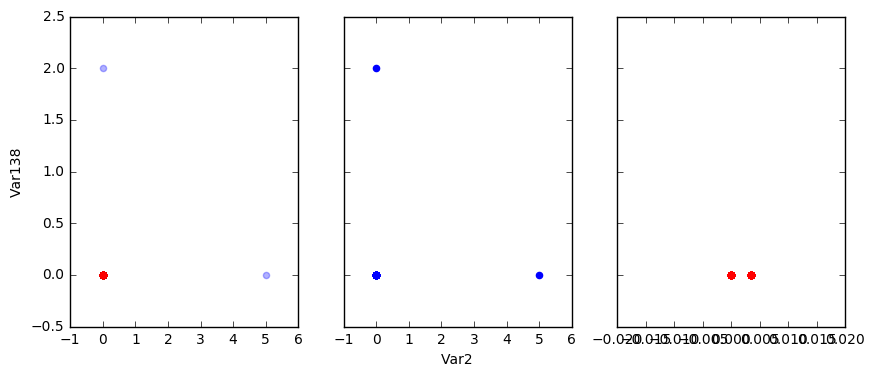

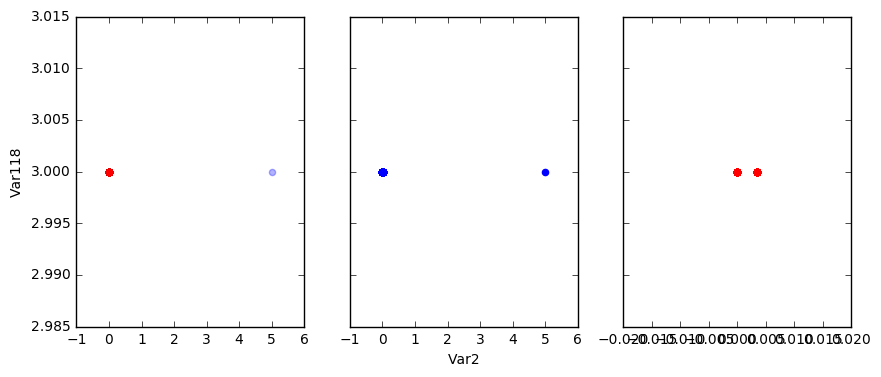

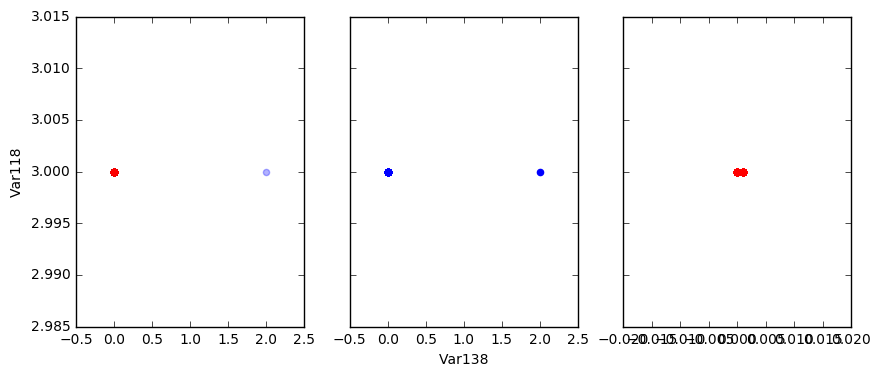

In [22]:
build_scatter_plots(
    numeric_balanced_frame,
    bottom_columns,
    class_descriptions)

7\. Посмотрите на категориальные переменные: постройте и сравните гистограммы значений категориальных переменных для разных классов.

In [ ]:
def build_histograms(frame, features, class_descriptions):
    fig, axes = plt.subplots(
        nrows=len(features),
        ncols=len(class_descriptions),
        figsize=(10, 25))
    for row_idx, col in enumerate(features):
        for col_idx, indices, data_class, color, alpha in class_descriptions:
            title = data_class + " histogram" if row_idx == 0 else ""
            plot = frame.loc[indices,col].apply(pd.value_counts).plot(
                kind="bar"
                ax=axes[row_idx, col_idx],
                legend=False,
                color=color,
                title=title)
            plot.set_ylabel(col if col_idx == 0 else "")

TypeError: unorderable types: str() < float()

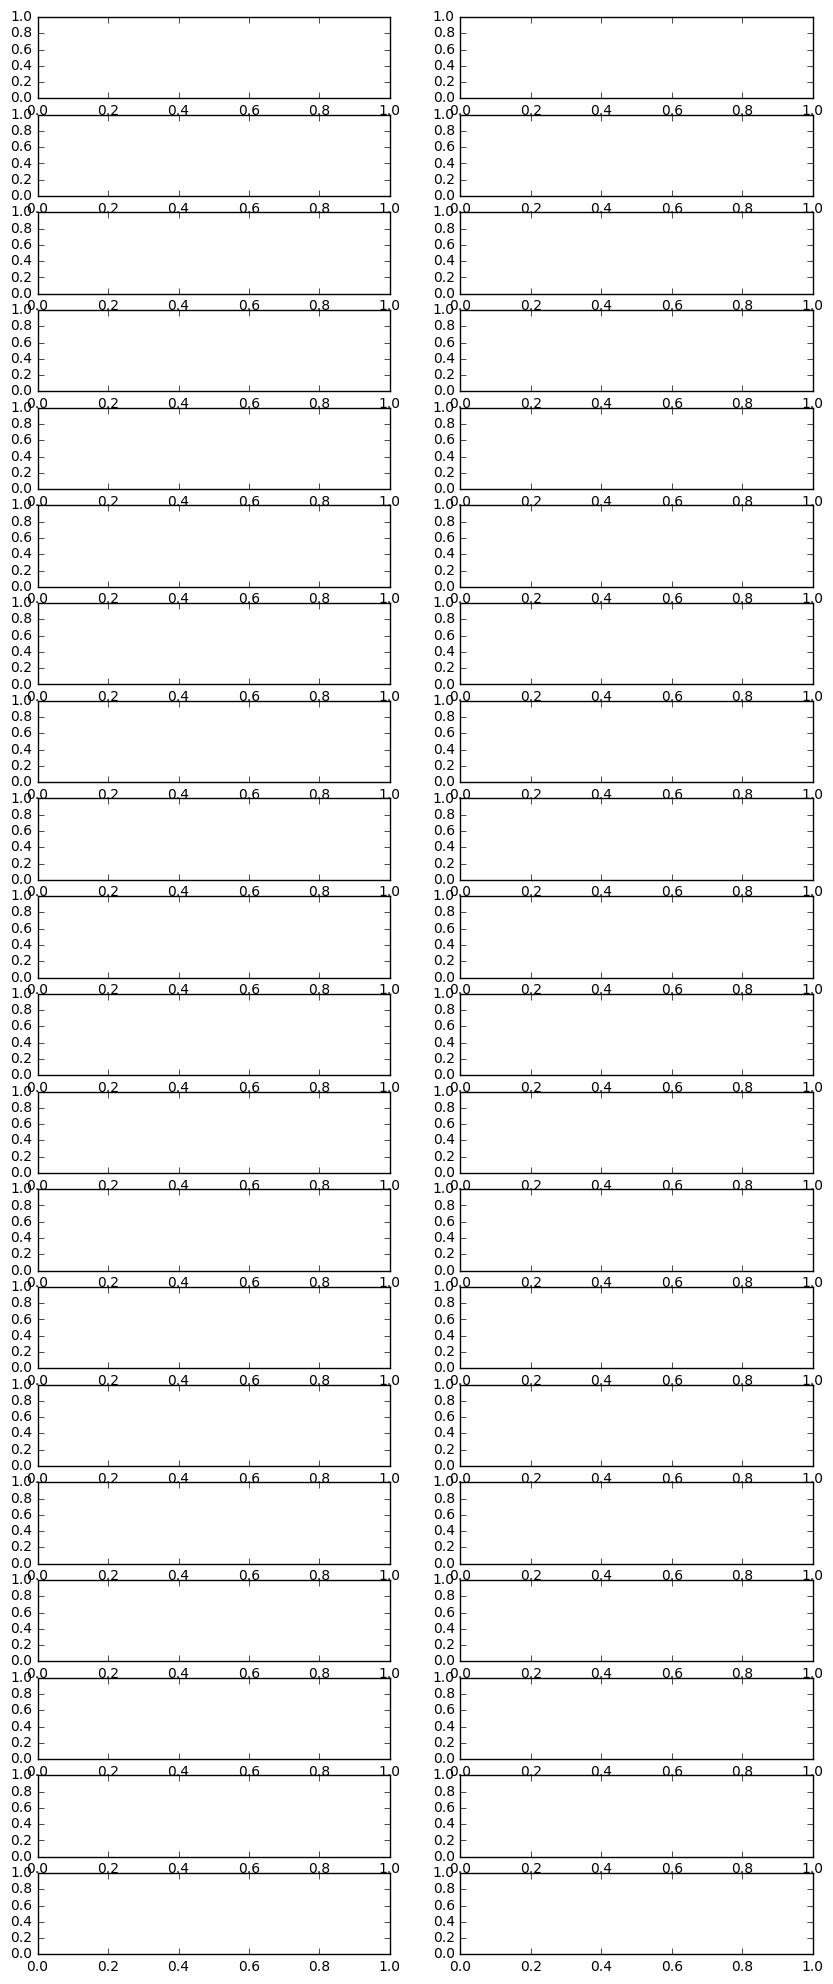

In [12]:
build_distribution_plots(categorial_frame, categorial_frame.columns, class_descriptions)

8\. Проанализируйте полученные результаты:
* Какие выводы вы можете сделать? Заметили ли вы какие-нибудь интересные закономерности?

* На основании полученных изображений и таблиц, предположите, какие переменные окажут наибольшее влияние (вклад) в модель?
* Какие переменные на ваш взгляд окажутся наименее полезными, шумовыми?
* Как вы думаете, окажется ли отбор признаков полезным для построения модели?

In [ ]:
# Сравнить Var133 и Var38, вероятно признаки коллинеарны
#          Var134 и Var76
#          Var163 и Var94
# Var177 значения not_churn в районе 0, значения churn в районе 1000000
# Var53 возможно скореллирован с Var177
# Var124 значения not_churn в районе 0, значения churn в районе 300000

# Перестроить гистограммы так, чтобы можно было их сравнить.
# Для этого сэмплировать данные класса "отток", чтобы выровнять классы и построить гистограммы на одном графике друг над другом
# Также можно уменьшить размеры корзин